## GDP PREDICTION PROJECT

### IMPORT LIST 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests
import seaborn as sns
import statsmodels.api as sm
import xgboost as xgb

from collections import Counter
from yellowbrick.cluster import KElbowVisualizer
from linearmodels.panel import PooledOLS, RandomEffects
from matplotlib.ticker import MaxNLocator
from sklearn.cluster import KMeans
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as mae, mean_absolute_percentage_error as mape, mean_squared_error as mse
from sklearn.model_selection import GridSearchCV, KFold, train_test_split 
from sklearn.preprocessing import StandardScaler


Turn off warnings: 

In [2]:
pd.options.mode.chained_assignment = None  # default='warn'

### USED FUNCTIONS 

* #### FOR PLOTTING

<br>**SETTING DATA LABELS IN PLOTS**<br>
> Additional funcion for set data labels in plot, used in def cluster_plot.

In [3]:
def label_point(x, y, val, f):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        f.text(point['x']+.02, point['y']+.02, str(point['val']), size=12)

<br>**PLOTTING OF DEPENDENT AND INDEPENDENT VARIABLES WITH TREND LINE**<br>
#### Input :
> **df** : DataFrame with y (dep_var; dependent variable) and X (column_list; independent variables);<br>
> **dep_var** : dependent variable name of df (will be visualized on x axis);<br>
> **dep_var_short** : dep_var short name for title;<br>
> **X_vars** : list of independent variables of df for visual analysis (will be visualized on y axis);<br>
> **hue** : variable name for grouping (for legend of plots).<br>
#### Output :
> ***plot*** : Plots by one of dependent (dep_var) and independent variables (X_vars);<br>

In [4]:
def plot_with_trend(df, dep_var, dep_var_short, X_vars, hue):
    for i in X_vars:
        sns.scatterplot(y=df[i],  
                    x=df[dep_var],
                    hue=df[hue]).set(title=                
                    f'"{dep_var_short}" vs "{i}"')
        # Fit a linear trend line
        z = np.polyfit(df[dep_var], df[i], 1)
        p = np.poly1d(z)
        plt.plot(df[dep_var],p(df[dep_var]),"r--")

        plt.legend(bbox_to_anchor=(1.1, 1), loc='upper left', borderaxespad=0) 
        plt.show()

<br>**PLOTTING OF PREDICTED CLUSTERS + COUNTING AND PLOTTING TOP_N OF VARIABLE**<br>
#### Input :
> <span style='color:#d30000'>***data*** : DataFrame : only output of **def clusters_no_scale** (not recommended) </span><br>
> ***top_num*** : number of TOP_N of Variable to be marked in plot. <br><span style='color:white'> ------------ </span> <span style='color:#d30000'>TOP_N is counted for input "sub1_name" of **def clusters_no_scale** (not recommended)</span>.<br>
#### Output :
> ***plot*** : Plot of clusters with selected TOP_N;<br>
> <span style='color:green'> ***data*** : DataFrame with selected number of TOP_N of Variable by Clusters : **clusters_plot.topN_list**. </span><br>

In [5]:
def clusters_plot(data, top_num):
    sub1_name = data.columns[-3]
    sub2_name = data.columns[-2]
    print(f'\n>>> CLUSTERS PLOT WITH TOP{top_num} LABELS')
    print('----------------------------------')
    
    # plotting
    f = sns.relplot(
        x=sub1_name, y=sub2_name, hue="Cluster", data=data, height=7)
    #sns.color_palette()
    f.fig.set_size_inches(15,10)
    
    # topN counting
    topN = (data.groupby(['Cluster'])
        .apply(lambda x: x.nlargest(top_num,[sub1_name]))
        .reset_index(drop=True))
    topN_country = topN['Country']
    topN_sub1 = topN[sub1_name]
    topN_sub2 = topN[sub2_name]
    
    # topN labels
    label_point(topN_sub1, topN_sub2, topN_country, plt.gca())
    
    # cenroids lables - output of def
    # plt.scatter(clusters_scale.centers[:,0], clusters_scale.centers[:,1], marker="x", color='r')
    
    # topN list (table)
    print(f'\n>>> >>> TOP{top_num} CLUSTERS LIST')
    print('--------------------------')
    topN_list = topN[['Country', 'Cluster']].pivot(columns='Cluster', values='Country').apply(lambda x: pd.Series(x.dropna().values)).fillna('')
    topN_list.index = np.arange(1, len(topN_list) + 1)
    display(topN_list)
    
    # plotting by continent
    f = sns.relplot(x=sub1_name, y=sub2_name, hue="Cluster", data=data, height=7, col="Continent")
    f.fig.set_size_inches(20,7)
    
    # def output - df with predicted clusters
    clusters_plot.topN_list = topN_list
    

<br>**REGRESSION MODEL RESULTS**<br>
<br>**PLOTTING OF DEPENDENT VARIABLE (y) : (REAL VALUE vs PREDICTED VALUE) AND (REAL VALUE vs PREDICTION ERROR)**
#### Input :
> ***y_test*** : real value of dependent variable;<br>
> <span style='color:#d30000'>***y_pred*** : predicted value of dependent variable. Output of **def LinReg_model**, or **def XGB_model**, or **def XBG_Grid_model**;</span> <br>
> ***color_pred*** : color of output plot no.1;<br>
> ***color_error*** : color of output plot no.2.<br>
#### Output :
> ***plot no.1*** : Plot of dependent variable real value and predicted value;<br>
> ***plot no.2*** : Plot of dependent variable real value and prediction error.

In [6]:
def pred_err_plot(y_test, y_pred, color_pred, color_error):
    fig, axs = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(11, 4.5))
    axs[0].scatter(y_test, y_pred, marker="o", color=color_pred)
    axs[0].set_xlabel("Real")
    axs[0].set_ylabel("Prediction")
    axs[0].set_title("Y : REAL vs PREDICTION")
    axs[1].scatter(y_test, y_test-y_pred, marker="x", color=color_error)
    axs[1].set_xlabel("Real")
    axs[1].set_ylabel("Error")
    axs[1].set_title("Y : REAL vs PRED.ERROR")
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
    plt.show()

* #### FOR CLUSTERING

<br>**CLUSTERING WITHOUT DATA SCALING (not recommended)**<br>
> 1. Preparing data of DataFrame 'df_all' for clustering;
> 2. K-means clustering of selected 2 subjects by selected clusters number.
#### Input : 
> ***year*** : Year of data, must be selected from [2000, 2026];<br>
> ***c_num*** : Number of clusters;<br>
> ***sub1_name*** : Variable no.1,<span style='color:#d30000'> must be selected from **df_all['Full Subject']** unique values;</span><br>
> ***sub2_name*** : Variable no.2,<span style='color:#d30000'> must be selected from **df_all['Full Subject']** unique values.</span><br>
#### Output :
> <span style='color:green'> ***data*** : DataFrame with new column "Cluster" of predicted clusters : **clusters_no_scale.df_Clust**. </span><br>
> <span style='color:green'> ***centroids*** : np.array of cluster centers : **clusters_no_scale.centers**. </span><br>

In [7]:
def clusters_no_scale(year, c_num, sub1_name, sub2_name):
    # select data
    df_sub1 = df_all.loc[lambda df_all: (df_all['Full Subject'] == sub1_name), :]
    df_sub2 = df_all.loc[lambda df_all: (df_all['Full Subject'] == sub2_name), :]
    df_Clust = df_sub1.append(df_sub2)
    # select data by year
    df_Clust = df_Clust[['Country', 'Continent', 'Full Subject', year]]
    # pivot data
    df_Clust = df_Clust.pivot(index=['Country', 'Continent'], columns='Full Subject', values=year)
    # dropna
    df_Clust = df_Clust.dropna(axis=0, how='any')
    # final data-set
    df_Clust = df_Clust.reset_index().rename_axis(None, axis=1)
    
    # clusters!
    kmeans = KMeans(n_clusters=c_num)
    df_Clust["Cluster"] = kmeans.fit_predict(df_Clust[[sub1_name, sub2_name]])
    df_Clust["Cluster"] = df_Clust["Cluster"].astype("category")
    # final sorted data-set with Cluster
    df_Clust = df_Clust.sort_values(by=['Cluster', sub1_name], axis=0, ascending=False)
    
    # centroids
    clusters_no_scale.centers = np.array(kmeans.cluster_centers_)
    
    print(f'\n>>> DATA WITH PREDICTED CLUSTERS <<<')
    print(f'\n>>> !!! DATA ARE NOT SCALED !!! <<<')
    print('-----------------------------------------------------------------------------------------------')
    print(f'\n>>> Selected :\n>>> >>> Data Years : {year},\n>>> >>> Subject_1 : "{sub1_name}",\n>>> >>> Subject_2 : "{sub2_name}",\n>>> >>> Number of Clusters : {c_num}.')
    print('-----------------------------------------------------------------------------------------------')
    print(f'>>> Output - DataFrame by name "clusters_no_scale.df_Clust". ')
    print(f'>>> >>> Please use it for funcions: "clusters_plot". ')
    print('-----------------------------------------------------------------------------------------------')
    display(df_Clust)
    
    clusters_no_scale.df_Clust = df_Clust

<br>**CLUSTERING WITH DATA SCALING (recommended)**<br>
> 1. Preparing data of DataFrame 'df_all' for clustering;
> 2. Data scaling by StandardScaler;
> 3. K-means clustering of selected 2 subjects by selected clusters number.
#### Input : 
> ***year*** : Year of data, must be selected from [2000, 2026];<br>
> ***c_num*** : Number of clusters;<br>
> ***sub1_name*** : Variable no.1,<span style='color:#d30000'> must be selected from **df_all['Full Subject']** unique values;</span><br>
> ***sub2_name*** : Variable no.2,<span style='color:#d30000'> must be selected from **df_all['Full Subject']** unique values.</span><br>
#### Output :
> <span style='color:green'> ***data*** : DataFrame with new column "Cluster" of predicted clusters : **clusters_scale.df_Clust**. </span><br>
> <span style='color:green'> ***scaled data*** : DataFrame of sub1_name and sub2_name scaled data : **clusters_scale.scaled_data**. </span><br>
> <span style='color:green'> ***centroids*** : np.array of cluster centers : **clusters_scale.centers**. </span><br>

In [8]:
def clusters_scale(year, c_num, sub1_name, sub2_name):
    # select data
    df_sub1 = df_all.loc[lambda df_all: (df_all['Full Subject'] == sub1_name), :]
    df_sub2 = df_all.loc[lambda df_all: (df_all['Full Subject'] == sub2_name), :]
    df_Clust = df_sub1.append(df_sub2)
    # select data by year
    df_Clust = df_Clust[['Country', 'Continent', 'Full Subject', year]]
    # pivot data
    df_Clust = df_Clust.pivot(index=['Country', 'Continent'], columns='Full Subject', values=year)
    # dropna
    df_Clust = df_Clust.dropna(axis=0, how='any')
    # final data-set
    df_Clust = df_Clust.reset_index().rename_axis(None, axis=1)
    
    # scaling data # selecting features
    col_names = [sub1_name, sub2_name]
    features = df_Clust[col_names]
    # scaling data 
    scaler = StandardScaler().fit(features.values)
    features = scaler.transform(features.values)
    scaled_data = pd.DataFrame(features, columns = col_names)
    
    # clusters!
    kmeans = KMeans(n_clusters=c_num)
    kmeans.fit(scaled_data)  # fit'inam scaled duomenis
    df_Clust["Cluster"] = kmeans.labels_
    # final sorted data-set with Cluster
    df_Clust = df_Clust.sort_values(by=['Cluster', sub1_name], axis=0, ascending=False)
    
    # centroids
    clusters_scale.centers = np.array(kmeans.cluster_centers_)
    
    print(f'\n>>> DATA WITH PREDICTED CLUSTERS <<<')
    print(f'\n>>> >> DATA ARE SCALED << <<<')
    print('-----------------------------------------------------------------------------------------------')
    print(f'\n>>> Selected :\n>>> >>> Data Years : {year},\n>>> >>> Subject_1 : "{sub1_name}",\n>>> >>> Subject_2 : "{sub2_name}",\n>>> >>> Number of Clusters : {c_num}.')
    print('-----------------------------------------------------------------------------------------------')
    print(f'>>> Output : DataFrame by name "clusters_scale.df_Clust". ')
    print(f'>>> >>> Please use it for funcions: "clusters_plot".')
    print('-----------------------------------------------------------------------------------------------')
    display(df_Clust)
    print(f'>>> Output : DataFrame of scaled data by name "clusters_scale.scaled_data". ')
    print(f'>>> >>> Please use it for funcions: "Elbow".')
    print('-----------------------------------------------------------------------------------------------')
    display(scaled_data.head(5))
    
    clusters_scale.scaled_data = scaled_data
    clusters_scale.df_Clust = df_Clust
      
    

<br>**ELBOW METHOD TO FIND THE OPTIMAL NUMBER OF CLUSTERS**<br>
> 1. Perform K-means clustering with all these different values of K. For each of the K values, calculate average distances to the centroid across all data points.
> 2. Plot these points and find the point where the average distance from the centroid falls suddenly (“Elbow”).
#### Input : 
> <span style='color:#d30000'>***scaled_data*** : output of **def clusters_scale**.</span> <br>
#### Output :
> *COUNTING INTERTIAS* :<br> 
> ***plot no.1*** : plotted inertias: "Clasters Quantity" vs "Inertia"; <br>
> ***plot no.2*** : plotted inertias: "Clasters Quantity" vs "Inertia - Delta". <br>
<br>
> *USING KElbowVisualizer* :<br> 
> ***plot no.3*** : The optimal number of clusters (k) is plotted against the distortion (total of within-cluster sum of squares for a given number of k). The optimal number of k is a point where there is a bend in the curve ("Elbow"). <br>

In [9]:
def Elbow(scaled_data):    
    model = KMeans()
    k_values = list(range(2,20))
    
    print('\n>>> USING KElbowVisualizer:')
    print('----------------------------------------------------------------')
    visualizer = KElbowVisualizer(model, k=k_values).fit(scaled_data)
    visualizer.show();
    
    print('>>> COUNTING INERTIAS:')
    print('----------------------------------------------------------------')
    inertias = []
    for k in k_values:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(scaled_data)
        inertias.append(kmeans.inertia_)

    fig, axs = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(10, 5))

    set_color = "#9C2162"

    axs[0].plot(k_values, inertias, marker='o', color=set_color)
    axs[0].xaxis.set_major_locator(MaxNLocator(integer=True)) # set x axis only as integer
    axs[0].set_xlabel('Clasters Quantity')
    axs[0].set_ylabel('WCSS = Inertia')

    axs[1].plot(k_values[1:], np.diff(inertias), marker='o', color=set_color)
    axs[1].xaxis.set_major_locator(MaxNLocator(integer=True)) # set x axis only as integer
    axs[1].set_xlabel('Clasters Quantity')
    axs[1].set_ylabel('WCSS = Inertia - Delta')


* #### FOR REGRESSION MODEL

<br>**ORDINARY LEAST SQUARES (OLS) REGRESSION**<br>
> Ordinary Least Squares regression (OLS) is a common technique for estimating coefficients of linear regression equations which describe the relationship between one or more independent quantitative variables and a dependent variable.
#### Input : 
> ***y*** : dependent variable;<br>
> ***X*** : independent variables.<br>
#### Output :
> ***OLS Regression Results summary***<br>

In [10]:
def OLS_model(y, X):
    X = sm.add_constant(X) # Statsmodels doesn't include a constant by default. Scikit-learn does.
    model = sm.OLS(y,X)
    results = model.fit()
    display(results.summary())

<br>**PooledOLS REGRESSION - BASIC REGRESSION ON PANEL DATA**<br>
> Pooled OLS regression model is simply a linear regression model fitted using the OLS technique on a flattened version of the panel data set. It is useful as a base model. Here the log wage is modeled using all of the variables and time dummies.<br>
<br>
> Pooled OLS  is employed when you select a different sample for each year/month/period of the panel data. If you are using the same sample along all periods, than your results are correct by now and Fixed or Random effects models are recommended.
#### Input : 
> ***dep_var*** : dependent variable <span style='color:#d30000'>any from DataFrame **"df3_reg_eu_final"**;</span><br>
#### Output :
> ***PooledOLS Estimation Summary*** : Pooled OLS results of all variables of  DataFrame 'df3_reg_eu_final'.<br> 

In [11]:
def PooledOLS_model(dep_var):
    # data loading
    df_panel = df3_reg_eu_final.copy()
    year = pd.Categorical(df_panel.Year)
    df_panel = df_panel.set_index(["Country_EU", "Year"])
    df_panel["Year_categorical"] = year
    # Select y and X
    y = df_panel[dep_var]
    df_panel2 = df_panel.drop([dep_var], axis=1)
    X = df_panel2 
    # PooledOLS model
    exog = sm.add_constant(df_panel2)
    model_POLS = RandomEffects(y, exog)
    pooled_res = model_POLS.fit()
    display(pooled_res)


<br>**REGRESSION MODEL MEASURES**<br>
> #### MSE: 
Mean square error (MSE) is the average of the square of the errors.<br> 
**The larger the number - the larger the error**.<br> 
The MSE is the average squared distance between the observed and predicted values. Because it uses squared units rather than the natural data units, the interpretation is less intuitive.<br>
> #### MAPE: 
The Mean Absolute Percentage Error (MAPE) is one of the most commonly used KPIs to measure forecast accuracy.
MAPE is the sum of the individual absolute errors divided by the demand (each period separately). <br> 
**It is the average of the percentage errors**.
#### Input : 
> ***y_test*** : real value of dependent variable;<br>
> <span style='color:#d30000'>***y_pred*** : predicted value of dependent variable. Output of **def LinReg_model**, or **def XGB_model**, or **def XBG_Grid_model**;</span> <br>
#### Output :
> ***MSE*** : the average of the square of the errors;<br>
> ***MAPE*** : the average of the percentage errors.

In [12]:
def model_results(y_test, y_pred):   
    mse_res = mse(y_test, y_pred, squared=False)
    mape_res = mape(y_test, y_pred)
    print('>>> Results :')
    print('-------------')
    print(f'MSE: {mse_res}')
    print(f'MAPE: {mape_res}')

<br>**LINEAR REGRESSION**<br>
> Linear Regression is a linear approach for modelling the relationship between a scalar response and one or more explanatory variables (also known as dependent and independent variables).
#### Input : 
> ***X_train*** : train part of data of independent variables;<br>
> ***y_train*** : train part of data of dependent variable;<br>
> ***X_test*** : test part of data of independent variables;<br>
> ***y_test*** : test part of data of dependent variable;<br>
#### Output :
> <span style='color:green'> ***LinReg_model.y_pred_lr*** : predicted values of dependent variable by LinearRegression(); </span><br>
> ***model results*** : output of def model_results; <br>
> ***model predictions plots*** : output of def pred_err_plot.

In [13]:
def LinReg_model(X_train, y_train, X_test, y_test):
    model = LinearRegression()
    lr = model.fit(X_train, y_train)
    LinReg_model.y_pred_lr = lr.predict(X_test) # Create function attribute
    # RESULTS
    model_results(y_test, LinReg_model.y_pred_lr)
    pred_err_plot(y_test, LinReg_model.y_pred_lr, color_pred='#24788F', color_error='#F18A85')
    # ADDITIONAL INDICATORS
    #r_sq = lr_fit.score(X_test, y_test)
    #intercept = lr_fit.intercept_
    #slope = lr_fit.coef_
    #print(f'r_sq: {lr_fit.score(X_test, y_test)}')
    #print(f'intercept: {lr_fit.intercept_}')
    #print(f'slope: {lr_fit.coef_}')

<br>**EXTREME GRADIENT BOOSTING - XGBOOST**<br>
> ***Extreme Gradient Boosting (XGBoost)*** is an open-source library that provides an efficient and effective implementation of the gradient boosting algorithm.<br>
> Shortly after its development and initial release, XGBoost became the go-to method and often the key component in winning solutions for a range of problems in machine learning competitions.<br>
> XGBoost can be used directly for regression predictive modeling.
#### Input : 
> ***X_train*** : train part of data of independent variables;<br>
> ***y_train*** : train part of data of dependent variable;<br>
> ***X_test*** : test part of data of independent variables;<br>
> ***y_test*** : test part of data of dependent variable;<br>
> ***max_depth*** : (training parameter, int); the maximum depth of each tree, ***often values are between 1 and 10***. We should be a bit careful while setting this parameter, as a very high value may cause the algorithm to overfit. 
high value may cause the algorithm to overfit. <br>
> ***eta*** : (training parameter, int); the learning rate used to weight each model, ***often set to small values such as 0.3, 0.1, 0.01, or smaller***.<br>
> ***iter_num*** : (training parameter, int); number of iterations.<br>
#### Output :
> <span style='color:green'> ***XGB_model.y_pred_xgb*** : predicted values of dependent variable by XGBOOST(); </span><br>
> ***model results*** : output of def model_results; <br>
> ***model predictions plots*** : output of def pred_err_plot.

In [14]:
def XGB_model(X_train, y_train, X_test, y_test, max_depth, eta, iter_num):
    # DMatrix is an optimized data structure that provides better memory efficiency and training speed
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    # TRAIN
    param = {'max_depth': max_depth, 'eta': eta, 'objective': 'reg:squarederror'}
    param['eval_metric'] = 'mape'
    evallist = [(dtest,'test'),(dtrain, 'train')]
    xgboost = xgb.train(param, dtrain, iter_num, evallist, early_stopping_rounds=5)
    # PREDICT
    XGB_model.y_pred_xgb = xgboost.predict(dtest) # Create function attribute
    # RESULTS
    print('\n')
    model_results(y_test, XGB_model.y_pred_xgb)
    pred_err_plot(y_test, XGB_model.y_pred_xgb, color_pred='#24788F', color_error='#F18A85')

<br>**EXTREME GRADIENT BOOSTING (XGBOOST) WITH GRIDSEARCH**<br>
#### Input : 
> ***X_train*** : train part of data of independent variables;<br>
> ***y_train*** : train part of data of dependent variable;<br>
> ***X_test*** : test part of data of independent variables;<br>
> ***y_test*** : test part of data of dependent variable;<br>
<br>
> *lists for searching the best parametres:*<br>
> ***learning_rate*** : (training parameter, float); specify how fast the algorithm will converge to an optimal solution;<br>
> ***max_depth*** : (training parameter, int); the maximum depth of each tree;<br>
> ***n_estimators*** : (training parameter, int); the number of trees in the ensemble, often increased until no further improvements are seen;<br>
> ***n_jobs*** : the number of parallel threads used to run XGBoost;<br>
> ***iter_num*** : (training parameter, int); number of iterations.<br>
#### Output :
> <span style='color:green'> ***XGB_Grid_model.xgb_grid*** : XGBoost-GridSearch model with selected best parametres of given for final prediction (project goal); </span><br>
> <span style='color:green'> ***XGB_Grid_model.y_pred_xgb_grid*** : predicted values of dependent variable by XGBoost-GridSearch; </span><br>
> ***XGB_Grid_model.xgb_grid*** : trained XGBoost-GridSearch model for reuse in def GDP_prediction;<br>
> ***model results*** : output of def model_results; <br>
> ***model predictions plots*** : output of def pred_err_plot.

In [15]:
def XGB_Grid_model(X_train, y_train, X_test, y_test, learning_rate, max_depth, n_estimators, n_jobs, iter_num):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    parameters = {'objective': ['reg:squarederror'],
              'learning_rate': learning_rate, 
              'max_depth': max_depth,
              'verbosity': [0],
              'n_estimators': n_estimators, # number of trees, 1000 for better results
              }
    bst = xgb.XGBRegressor()
    best = GridSearchCV(bst, parameters, n_jobs=n_jobs, 
                   scoring="neg_mean_absolute_error",
                   verbose=2, refit=True)
    xgb_grid = best.fit(X_train, y_train)
    best_params = xgb_grid.best_params_
    print('\n>>>Selected the best parametres:')
    print('--------------------------------')
    print(f'{best_params}\n')
    best_params['eval_metric'] = 'mape'
    evallist = [(dtest,'test'),(dtrain, 'train')]
    # TRAIN
    XGB_Grid_model.xgb_grid = xgb.train(best_params, dtrain, iter_num, evallist)
    # PREDICT 
    XGB_Grid_model.y_pred_xgb_grid = XGB_Grid_model.xgb_grid.predict(dtest) # Create function attribute
    # RESULTS
    print('\n')
    model_results(y_test, XGB_Grid_model.y_pred_xgb_grid)
    pred_err_plot(y_test, XGB_Grid_model.y_pred_xgb_grid, color_pred='#24788F', color_error='#F18A85')

<br>**GDP PREDICTION BY INPUT VALUES**<br>
> GDP is predicted by final XGB_Grid_model:
>> *Selected 5 independent variables:*<br> 1. 'General government revenue / Percent of GDP / ';<br> 2. 'General government total expenditure / National currency / Billions';<br> 3. 'Gross national savings / Percent of GDP / ';<br> 4. 'Total investment / Percent of GDP / ';<br> 5. 'Unemployment rate / Percent of total labor force / '.<br>
>> <br>*Model was trained with data without outliers (dropped Luxembourg).*
#### Input :
> The input of the 5 variables will be provided on running function.
#### Output :
> ***predicted GDP*** : result by input of 5 variables;

In [16]:
def GDP_prediction():

    columns = ['General government revenue / Percent of GDP / ',
               'General government total expenditure / National currency / Billions',
               'Gross national savings / Percent of GDP / ',
               'Total investment / Percent of GDP / ',
               'Unemployment rate / Percent of total labor force / ']
    print(f'>>> Please enter 5 values of subjects for GDP prediction.\n')
    
    revenue = float(input('1. "General government revenue / Percent of GDP / " : '))
    expenditure = float(input('2. "General government total expenditure / National currency / Billions" : '))
    savings = float(input('3. "Gross national savings / Percent of GDP / " : '))
    investment = float(input('4. "Total investment / Percent of GDP / " : '))
    unemployment = float(input('5. "Unemployment rate / Percent of total labor force / " : '))
    
    values = [revenue, expenditure, savings, investment, unemployment]
    new_line = xgb.DMatrix(pd.DataFrame([values], columns=columns))
    return print(f'Predicted GDP value:  {XGB_Grid_model.xgb_grid.predict(new_line)}')

### 1. DATA INPUT : LOADING AND CLEANING 

* #### df : INTERNATIONAL MONETARY FUND, IMF (MAIN DATA)

In [17]:
print('\n*** DATA LOADING.   1.1. df : International Monetary Fund, IMF (main data) ***')
print('------------------------------------------------------------------------------')

# get data
df = pd.read_excel('data/IMF_Data.xlsx', engine='openpyxl')
df.head(5)

print('\n>>> DATA VERIFICATION <<<')
print(f'\n>>> >> > Shape of df: {df.shape}')
print(f'\nNulls of df.ISO: {df.ISO.isnull().sum()}')
print(f'\nCheck and drop of df.ISO is null:')
display(df[df.ISO.isnull()])
df = df.dropna(subset=['ISO'])
print(f'\n>>> >> > Shape of df: {df.shape}')
print('------------------------------------------------------------------------------')

print('\n>>> DATA CLEANING AND CHANGING DTYPES <<<')
col_list = list(range(2000, 2027))
for col in col_list:
    df[col] = df[col].astype(str).str.replace("--", "NaN")
    df[col] = df[col].astype(str).str.replace(",", "")
    df[col] = df[col].astype(float)
    
df = df.dropna(subset=['Estimates Start After'])
df['Estimates Start After'] = df['Estimates Start After'].astype(int)
print(f'\nDropped nan "Estimates Start After":')
print(f'\n>>> >> > Shape of df: {df.shape}')
print('\n------------------------------------------------------------------------------')

print('\n>>> COLUMNS VERIFICATION : JOINING "Subject Descriptor" ATTRIBUTES <<<')
df['Scale'] = df['Scale'].fillna('')
df['Full Subject'] = df['Subject Descriptor'] + ' / ' + df['Units'] + ' / ' + df['Scale']
col_delete4 = ['Subject Descriptor', 'Units', 'Scale']
df = df.drop(col_delete4, axis=1)
print(f'\nAdded new column "Full Subject" of joined columns, dropped ["Subject Descriptor", "Units", "Scale"]:')
print(f'\n>>> >> > Shape of df: {df.shape}')
print('\n------------------------------------------------------------------------------')

print('\n>>> FINAL IMF DATA <<<')
display(df.head(3))
print('\n>>> DTYPES OF FINAL IMF DATA <<<')
display(df.dtypes)


*** DATA LOADING.   1.1. df : International Monetary Fund, IMF (main data) ***
------------------------------------------------------------------------------

>>> DATA VERIFICATION <<<

>>> >> > Shape of df: (8822, 36)

Nulls of df.ISO: 2

Check and drop of df.ISO is null:


WEO Country Code  ISO WEO Subject Code  \
8820                                                NaN  NaN              NaN   
8821  International Monetary Fund, World Economic Ou...  NaN              NaN   

     Country Subject Descriptor Units Scale Country/Series-specific Notes  \
8820     NaN                NaN   NaN   NaN                           NaN   
8821     NaN                NaN   NaN   NaN                           NaN   

     2000 2001  ... 2018 2019 2020 2021 2022 2023 2024 2025 2026  \
8820  NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
8821  NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

     Estimates Start After  
8820                   NaN  
8821                   NaN  

[2 rows x 36 columns]


>>> >> > Shape of df: (8820, 36)
------------------------------------------------------------------------------

>>> DATA CLEANING AND CHANGING DTYPES <<<

Dropped nan "Estimates Start After":

>>> >> > Shape of df: (7635, 36)

------------------------------------------------------------------------------

>>> COLUMNS VERIFICATION : JOINING "Subject Descriptor" ATTRIBUTES <<<

Added new column "Full Subject" of joined columns, dropped ["Subject Descriptor", "Units", "Scale"]:

>>> >> > Shape of df: (7635, 34)

------------------------------------------------------------------------------

>>> FINAL IMF DATA <<<


WEO Country Code  ISO WEO Subject Code      Country  \
0              512  AFG           NGDP_R  Afghanistan   
1              512  AFG        NGDP_RPCH  Afghanistan   
2              512  AFG             NGDP  Afghanistan   

                       Country/Series-specific Notes  2000  2001     2002  \
0  Source: National Statistics Office Latest actu...   NaN   NaN  453.484   
1  See notes for:  Gross domestic product, consta...   NaN   NaN      NaN   
2  Source: National Statistics Office Latest actu...   NaN   NaN  178.756   

      2003     2004  ...      2019      2020  2021  2022  2023  2024  2025  \
0  492.903  496.209  ...  1319.902  1288.869   NaN   NaN   NaN   NaN   NaN   
1    8.692    0.671  ...     3.912    -2.351   NaN   NaN   NaN   NaN   NaN   
2  220.013  246.210  ...  1469.596  1547.289   NaN   NaN   NaN   NaN   NaN   

   2026  Estimates Start After  \
0   NaN                   2019   
1   NaN                   2019   
2   NaN                   2019   

                                        Full Subject  
0  Gross domestic product, constant prices / Nati...  
1  Gross domestic product, constant prices / Perc...  
2  Gross domestic product, current prices / Natio...  

[3 rows x 34 columns]


>>> DTYPES OF FINAL IMF DATA <<<


WEO Country Code                  object
ISO                               object
WEO Subject Code                  object
Country                           object
Country/Series-specific Notes     object
2000                             float64
2001                             float64
2002                             float64
2003                             float64
2004                             float64
2005                             float64
2006                             float64
2007                             float64
2008                             float64
2009                             float64
2010                             float64
2011                             float64
2012                             float64
2013                             float64
2014                             float64
2015                             float64
2016                             float64
2017                             float64
2018                             float64
2019            

* #### df_cont_list : COUNTRIES BY CONTINENT (ADDITIONAL DATA)

In [18]:
print('\n*** DATA LOADING.   1.2. df_cont_list : Countries by continent (additional data) ***')
print('------------------------------------------------------------------------------------')

# get data
url = 'https://statisticstimes.com/geography/countries-by-continents.php'
html = requests.get(url).content
df_cont_list = pd.read_html(html)
df_cont_list = df_cont_list[-1]

# prepare data
df_cont_list = df_cont_list.rename({'ISO-alpha3 Code': 'ISO', 'Country or Area': 'Country'}, axis='columns')
df_cont_list = df_cont_list.drop(['No', 'M49 Code', 'Country'], axis=1)

print('\n*** DATA VERIFICATION ***')
print('--------------------------')
print(f'Shape of df_cont_list: {df_cont_list.shape}')
print(f'\nNull of df_cont_list.ISO: {df_cont_list.ISO.isnull().sum()}')
print(f'\nCheck and drop of df_cont_list.ISO is null:')
display(df_cont_list[df_cont_list.ISO.isnull()])
df_cont_list = df_cont_list.dropna(subset=['ISO'])

print('\n\n*** FINAL COUNTRIES & CONTINENT LIST ***')
print('----------------------------------------')
print(f'\nFinal shape of df_cont_list: {df_cont_list.shape}')
print(f'\nFinal df_cont_list:')
display(df_cont_list.head(5))


*** DATA LOADING.   1.2. df_cont_list : Countries by continent (additional data) ***
------------------------------------------------------------------------------------

*** DATA VERIFICATION ***
--------------------------
Shape of df_cont_list: (249, 4)

Null of df_cont_list.ISO: 1

Check and drop of df_cont_list.ISO is null:


ISO         Region 1         Region 2 Continent
195  NaN  Northern Europe  Channel Islands    Europe



*** FINAL COUNTRIES & CONTINENT LIST ***
----------------------------------------

Final shape of df_cont_list: (248, 4)

Final df_cont_list:


ISO         Region 1 Region 2 Continent
0  AFG    Southern Asia      NaN      Asia
1  ALA  Northern Europe      NaN    Europe
2  ALB  Southern Europe      NaN    Europe
3  DZA  Northern Africa      NaN    Africa
4  ASM        Polynesia      NaN   Oceania

* #### df_all : MERGED DATA (MAIN DATA/COUNTRY + ADDITIONAL DATA/CONTINENT)

In [19]:
print('\n*** DATA LOADING.   1.3. df_all : Merged data (main data/country + additional data/continent) ***')
print('-------------------------------------------------------------------------------------------------')

print('\n*** MERGED DATA ***')
print('-------------------')
df_all = pd.merge(df, df_cont_list[['ISO', 'Continent']], on="ISO")
print(f'\nShape of df_all: {df_all.shape}')

print('\n*** DATA VERIFICATION ***')
print('--------------------------')
print(f'\nNull of df_all.Country: {df_all.Country.isnull().sum()}')
print(f'\nCheck and drop of df_all.Country is null:')
display(df_all[df_all.Country.isnull()])
df_all = df_all.dropna(subset=['Country'])
print(f'\nNull of df_all.Continent: {df_all.Continent.isnull().sum()}')
# print(f'\nCheck of df_all.Continent is null:')
# display(df_all[df_all.Continent.isnull()])
# df_all = df_all.dropna(subset=['Continent'])

print('\n\n*** FINAL MERGED DATA ***')
print('-------------------------')
print(f'\nFinal shape of df_all: {df_all.shape}')
print(f'\nFinal df_all:')
display(df_all.head(3))


*** DATA LOADING.   1.3. df_all : Merged data (main data/country + additional data/continent) ***
-------------------------------------------------------------------------------------------------

*** MERGED DATA ***
-------------------

Shape of df_all: (7519, 35)

*** DATA VERIFICATION ***
--------------------------

Null of df_all.Country: 0

Check and drop of df_all.Country is null:


Empty DataFrame
Columns: [WEO Country Code, ISO, WEO Subject Code, Country, Country/Series-specific Notes, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, Estimates Start After, Full Subject, Continent]
Index: []

[0 rows x 35 columns]


Null of df_all.Continent: 0


*** FINAL MERGED DATA ***
-------------------------

Final shape of df_all: (7519, 35)

Final df_all:


WEO Country Code  ISO WEO Subject Code      Country  \
0              512  AFG           NGDP_R  Afghanistan   
1              512  AFG        NGDP_RPCH  Afghanistan   
2              512  AFG             NGDP  Afghanistan   

                       Country/Series-specific Notes  2000  2001     2002  \
0  Source: National Statistics Office Latest actu...   NaN   NaN  453.484   
1  See notes for:  Gross domestic product, consta...   NaN   NaN      NaN   
2  Source: National Statistics Office Latest actu...   NaN   NaN  178.756   

      2003     2004  ...      2020  2021  2022  2023  2024  2025  2026  \
0  492.903  496.209  ...  1288.869   NaN   NaN   NaN   NaN   NaN   NaN   
1    8.692    0.671  ...    -2.351   NaN   NaN   NaN   NaN   NaN   NaN   
2  220.013  246.210  ...  1547.289   NaN   NaN   NaN   NaN   NaN   NaN   

   Estimates Start After                                       Full Subject  \
0                   2019  Gross domestic product, constant prices / Nati...   
1                   2019  Gross domestic product, constant prices / Perc...   
2                   2019  Gross domestic product, current prices / Natio...   

   Continent  
0       Asia  
1       Asia  
2       Asia  

[3 rows x 35 columns]

* #### df_GDP : GDP DATA (Gross domestic product per capita, current prices)

In [20]:
# select data
df_GDP = df_all.loc[lambda df_all: (df_all['Full Subject']=='Gross domestic product per capita, current prices / U.S. dollars / Units'), :]

# check dtypes
# print(df_GDP.dtypes)
# print('/n*** FINAL GDP DATA ***')
# print('----------------------')
# df_GDP.head(3)

* #### oecd_country_list : OECD MEMBERS LIST

**The Organisation for Economic Co-operation and Development (OECD)** is an intergovernmental economic organisation with 38 member countries, founded in 1961 to stimulate economic progress and world trade. It is a forum of countries describing themselves as committed to democracy and the market economy, providing a platform to compare policy experiences, seek answers to common problems, identify good practices and coordinate domestic and international policies of its members. The majority of OECD members are high-income economies with a very high Human Development Index (HDI) and are regarded as developed countries. As of 2017, the OECD member countries collectively comprised 62.2% of global nominal GDP (US dollars 49.6 trillion) and 42.8% of global GDP (Int dollars 54.2 trillion) at purchasing power parity. The OECD is an official United Nations observer.

In [21]:
# get data - OECD members
# only Country name
url = 'https://www.oecd.org/about/document/ratification-oecd-convention.htm'
html = requests.get(url).content
oecd_country_list = pd.read_html(html)
oecd_country_list = oecd_country_list[-1]
oecd_country_list = oecd_country_list.drop([0, 3], axis=1).rename({1: 'Country', 2: 'Membership date'}, axis=1)
oecd_country_list = oecd_country_list.drop(0, axis=0)
oecd_country_list['Country'] = oecd_country_list['Country'].str.title()
# add ISO data by Country name from df (main data))
oecd_country_list = pd.merge(oecd_country_list, df[['Country', 'ISO']].drop_duplicates(subset='Country', keep='first', inplace=False, ignore_index=True), on="Country")
oecd_country_list.index = oecd_country_list.index + 1
oecd_country_list.tail(5)

Country    Membership date  ISO
34          Sweden  28 September 1961  SWE
35     Switzerland  28 September 1961  CHE
36          Turkey      2 August 1961  TUR
37  United Kingdom         2 May 1961  GBR
38   United States      12 April 1961  USA

* #### eu_country_list : EU MEMBERS LIST

In [22]:
# get data
url_eu = 'https://en.wikipedia.org/wiki/List_of_European_Union_member_states_by_population'
html_eu = requests.get(url_eu).content
eu_country_list = pd.read_html(html_eu)
eu_country_list = eu_country_list[-1]

# drop total row
eu_country_list.drop(eu_country_list[eu_country_list.Country=='Total'].index, inplace=True)

# change Rank dtype
eu_country_list.Rank = eu_country_list.Rank.astype(int)

# correct country name due to main df
eu_country_list.loc[eu_country_list.Country == 'Slovakia', 'Country'] = 'Slovak Republic'

print('\n*** FINAL EU COUNTRIES LIST ***')
print('-------------------------------')
display(eu_country_list)


*** FINAL EU COUNTRIES LIST ***
-------------------------------


Rank          Country  2020Eurostat figure[1]  % ofpop.  \
0      1          Germany                83166711     18.59   
1      2           France                67320216     15.05   
2      3            Italy                59641488     13.33   
3      4            Spain                47332614     10.58   
4      5           Poland                37958138      8.49   
5      6          Romania                19328838      4.32   
6      7      Netherlands                17407585      3.89   
7      8          Belgium                11522440      2.58   
8      9           Greece                10718565      2.40   
9     10   Czech Republic                10693939      2.39   
10    11           Sweden                10327589      2.31   
11    12         Portugal                10295909      2.30   
12    13          Hungary                 9769526      2.18   
13    14          Austria                 8901064      1.99   
14    15         Bulgaria                 6951482      1.55   
15    16          Denmark                 5822763      1.30   
16    17          Finland                 5525292      1.24   
17    18  Slovak Republic                 5457873      1.22   
18    19          Ireland                 4964440      1.11   
19    20          Croatia                 4058165      0.91   
20    21        Lithuania                 2794090      0.62   
21    22         Slovenia                 2095861      0.47   
22    23           Latvia                 1907675      0.43   
23    24          Estonia                 1328976      0.30   
24    25           Cyprus                  888005      0.20   
25    26       Luxembourg                  626108      0.14   
26    27            Malta                  514564      0.12   

    Nationalofficial figure Date of nationalofficial figure  \
0                83129285.0                   June 30, 2021   
1                67399000.0                     March, 2021   
2                60391000.0                 January 1, 2020   
3                47351567.0                    July 1, 2020   
4                38230000.0               February 28, 2021   
5                19318000.0                 January 1, 2020   
6                17475908.0                February 1, 2021   
7                11560220.0                   March 1, 2021   
8                10718565.0                 January 1, 2020   
9                10701777.0               December 31, 2020   
10               10379285.0               December 31, 2020   
11               10295909.0                            2019   
12                9730000.0                 January 1, 2021   
13                8901064.0                 January 1, 2020   
14                6916548.0               December 31, 2020   
15                5840045.0                 January 1, 2021   
16                5537116.0                  March 31, 2021   
17                5459781.0               December 31, 2020   
18                4977400.0                   April 1, 2020   
19                4047200.0               December 31, 2020   
20                2785501.0                     May 1, 2021   
21                2108977.0                 January 1, 2021   
22                1887600.0                   April 1, 2021   
23                1330068.0                 January 1, 2021   
24                 888000.0               December 31, 2019   
25                 634700.0                 January 1, 2021   
26                 514564.0               December 31, 2019   

   Source of nationalofficial figure  
0                  Official estimate  
1          Monthly official estimate  
2          Monthly official estimate  
3                  Official estimate  
4                  Official estimate  
5                  Official estimate  
6          Monthly official estimate  
7          Monthly official estimate  
8                  Official estimate  
9                  Official estimate  
10         Monthly official estimate  
11    

### 2. DATA ANALYSIS

### 2.1. BASIC DATA ANALYSIS AND CHECK

* #### 'ESTIMATES START AFTER' : ANALYSIS OF ACTUAL AND PREDICTED DATA QUANTITY


*** ANALYSIS OF ACTUAL DATA BY YEARS ***
----------------------------------------
Total Countries: 193
GDP 2019 act data of all countries: (42+75)/193 = 61.0%
GDP 2020 act data of all countries: 75/193 = 39.0%


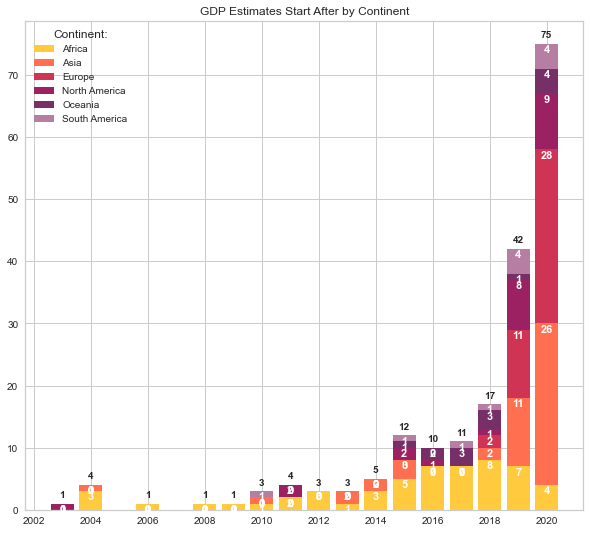

In [23]:
print('\n*** ANALYSIS OF ACTUAL DATA BY YEARS ***')
print('----------------------------------------')

temp_2019 = df_GDP[df_GDP['Estimates Start After']==2019].shape[0]
temp_2020 = df_GDP[df_GDP['Estimates Start After']==2020].shape[0]
all_countr = df_GDP.shape[0]

print(f'Total Countries: {all_countr}')
print(f'GDP 2019 act data of all countries: ({temp_2019}+{temp_2020})/{all_countr} = {round((temp_2019+temp_2020)/(all_countr)*100,0)}%')
print(f'GDP 2020 act data of all countries: {temp_2020}/{all_countr} = {round((temp_2020)/(all_countr)*100,0)}%')


data = df_GDP[['Country', 'Continent','Estimates Start After']]
data = df_GDP.groupby(['Estimates Start After', 'Continent'])['Country'].count().unstack().fillna(0)

fig, ax = plt.subplots(figsize=(10,9))

#colors = ["#619ED6", "#6BA547", "#F7D027", "#E48F1B", "#B77EA3", "#E64345"]
colors = ["#FFCA3E", "#FF6F50", "#D03454", "#9C2162", "#772F67", "#B77EA3"]
bottom = np.zeros(len(data))

for i, col in enumerate(data.columns):
    ax.bar(data.index, data[col], bottom=bottom, label=col, color=colors[i])
    bottom += np.array(data[col])


# total data labels
totals = data.sum(axis=1)
y_offset = 1

for i, total in enumerate(totals):
    ax.text(totals.index[i], total + y_offset, round(total), ha='center', weight='bold', size=10)
    
    
# data labels 
y_offset = -0.9 # label inside the bars (negative offset)

for bar in ax.patches:
    ax.text(
    bar.get_x() + bar.get_width() / 2, # add text in the middle of each bar. get_x returns the start - add half the width to get to the middle
    bar.get_height() + bar.get_y() + y_offset, # vertically, add the height of the bar to the start of the bar, along with the offset
      round(bar.get_height()), # actual value
    ha='center', #Center and style the labels
    va='center',
    color='w',
    weight='bold',
    size=11
  )


ax.xaxis.set_major_locator(MaxNLocator(integer=True)) # set x axis only as integer
ax.set_title('GDP Estimates Start After by Continent')
ax.legend(title='Continent:');

* #### 'ESTIMATES START AFTER': ANALYSIS OF ACTUAL AND PREDICTED DATA QUANTITY BY CONTINENT


*** ANALYSIS OF ACTUAL DATA BY CONTINENTS ***
---------------------------------------------


 GDP 2019 act data  --- Asia: 77.0%
			 37 of 48 countries


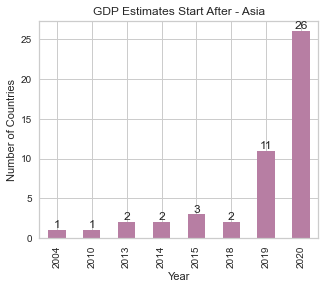



 GDP 2019 act data  --- Europe: 95.0%
			 39 of 41 countries


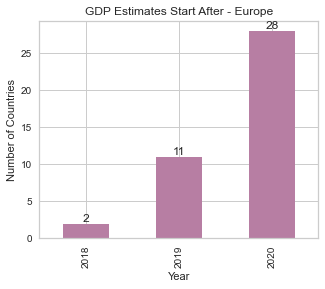



 GDP 2019 act data  --- Africa: 20.0%
			 11 of 54 countries


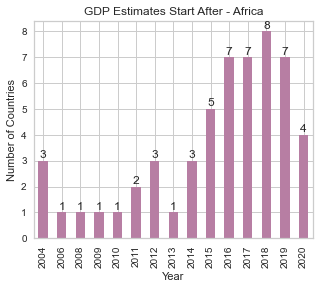



 GDP 2019 act data  --- North America: 71.0%
			 17 of 24 countries


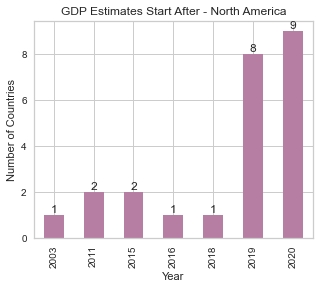



 GDP 2019 act data  --- South America: 67.0%
			 8 of 12 countries


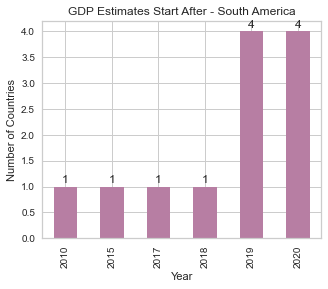



 GDP 2019 act data  --- Oceania: 36.0%
			 5 of 14 countries


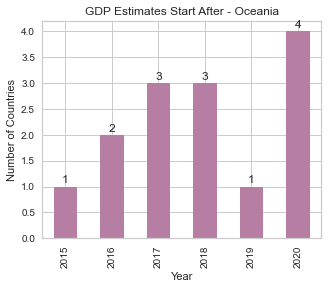

In [24]:
print('\n*** ANALYSIS OF ACTUAL DATA BY CONTINENTS ***')
print('---------------------------------------------')

continent_list = df_GDP["Continent"].unique()
df_GDP_to_use = df_GDP[(df_GDP['Estimates Start After']>=2019)]

#print(f'Continent/country is null (in data "all"): {df_GDP["Continent"].isnull().sum()} / {df_GDP["Country"].isnull().sum()}')
#print(f'Continent/country (in data "to use"): {df_GDP_to_use["Continent"].isnull().sum()} / {df_GDP_to_use["Country"].isnull().sum()}')
  
for c in continent_list:
    
    to_use = df_GDP_to_use[df_GDP_to_use['Continent']==c].shape[0]
    to_all = df_GDP[df_GDP['Continent']==c].shape[0]
    print(f'\n\n GDP 2019 act data  --- {c}: {round(to_use / to_all * 100, 0)}%')
    to_use_country = df_GDP_to_use['Country'][df_GDP_to_use['Continent']==c].shape[0]
    to_all_country = df_GDP['Country'][df_GDP['Continent']==c].shape[0]
    print(f'\t\t\t {to_use_country} of {to_all_country} countries')
    
    plt.rcParams['figure.figsize'] = [5, 4]
    counts = df_GDP['Estimates Start After'][df_GDP['Continent']==c].value_counts().sort_index()
    ax = counts.plot(kind='bar', rot=0, ylabel='count', color="#B77EA3")
    plt.title(f'GDP Estimates Start After - {c}')
    plt.xlabel('Year')
    plt.ylabel('Number of Countries')
    plt.xticks(rotation=90, ha='center')
    # make and set labels
    rects = ax.patches
    for rect, label in zip(rects, counts):
        ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 0.03, label, ha="center", va="bottom")
    plt.show();


* #### NUMBER OF CONTINENT CHECK IN DIFFRENT DATAFRAME

In [25]:
print('\n*** CONTINENT NUMBER IN DIFF DF ***')
print('-----------------------------------')

print('\nContinents:')
print(df_cont_list.Continent.unique())
print(f'Total: {len(df_cont_list.Continent.unique())}\n')

continent_list = df_GDP["Continent"].unique()

print('>>> Continent: df name - countries num')

for c in continent_list:
    from_df_all = df_all['Country'][df_all['Continent']==c]
    from_df_GDP = df_GDP['Country'][df_GDP['Continent']==c]
    print(f'{c} : df_all - {len(from_df_all.unique())} / df_GDP - {len(from_df_GDP.unique())}')

print(f'Total: {len(continent_list)}\n')

print('Antarctica has no countries :)')


*** CONTINENT NUMBER IN DIFF DF ***
-----------------------------------

Continents:
['Asia' 'Europe' 'Africa' 'Oceania' 'North America' 'Antarctica'
 'South America']
Total: 7

>>> Continent: df name - countries num
Asia : df_all - 48 / df_GDP - 48
Europe : df_all - 41 / df_GDP - 41
Africa : df_all - 54 / df_GDP - 54
North America : df_all - 24 / df_GDP - 24
South America : df_all - 12 / df_GDP - 12
Oceania : df_all - 14 / df_GDP - 14
Total: 6

Antarctica has no countries :)


### 2.2. Exercise #1
> Raskite top 10 šalių, kurių "Gross domestic product per capita" paaugo daugiausiai.

In [26]:
# Input
# start = input("Enter analysis period start years: ")
# period = input("Enter analysis period years number: ")
# print(f'Analysis period end years: {start+(period-1)}')

start = 2019
period = 3
end = start+(period-1)

diff = 'Δ_'+str(end)+'-'+str(start)
diff_per = 'Δ%_'+str(end)+'-'+str(start)

df_GDP1 = df_GDP.copy()

df_GDP1[diff] = df_GDP1[end].sub(df_GDP1[start], axis = 0)
df_GDP1[diff_per] = round((df_GDP1[diff] / df_GDP1[start] * 100), 2)

# fill diff_per null with "-9999.99", for correct desc sorting
df_GDP1[diff_per][df_GDP1[diff_per].isnull()==True]=-9999.99


df_GDP1 = df_GDP1[['ISO', 'Country', 'Continent', 'Full Subject', 'Estimates Start After',
                         start, end, diff, diff_per]]
df_GDP1 = df_GDP1.sort_values(by=diff_per, ascending=False).reset_index(drop=True)
df_GDP1[diff_per] = df_GDP1[diff_per].astype(str) + '%'
df_GDP1.index = df_GDP1.index + 1

print(f'\n>>> TOP10 growth of "GDP per capita" in {start}-{end}, {period} years period.')
print(f'>>> >>> Attention to "Estimates Start After" data : some results are counted by estimated data.')
display(df_GDP1.head(10))
print(f'---------------------------------------------------------------------------------------------------')
print(f'\n>>> TOP10 reduction of "GDP per capita" in {start}-{end}, {period} years period.')
print(f'>>> >>> Attention to Nan data : counted results of Nan values = -9999.99% (const).\n>>> >>> Const was applied due to enable the sorting.')
display(df_GDP1.tail(10))
print(f'---------------------------------------------------------------------------------------------------')
print(f'\n>>> LITHUANIA growth of "GDP per capita" in {start}-{end}, {period} years period.')
display(df_GDP1[df_GDP1['Country']=='Lithuania'])
print(f'---------------------------------------------------------------------------------------------------')




>>> TOP10 growth of "GDP per capita" in 2019-2021, 3 years period.
>>> >>> Attention to "Estimates Start After" data : some results are counted by estimated data.


ISO                   Country      Continent  \
1   IRN  Islamic Republic of Iran           Asia   
2   GUY                    Guyana  South America   
3   HTI                     Haiti  North America   
4   IRL                   Ireland         Europe   
5   ZWE                  Zimbabwe         Africa   
6   EGY                     Egypt         Africa   
7   SRB                    Serbia         Europe   
8   TUV                    Tuvalu        Oceania   
9   UKR                   Ukraine         Europe   
10  BEN                     Benin         Africa   

                                         Full Subject  Estimates Start After  \
1   Gross domestic product per capita, current pri...                   2019   
2   Gross domestic product per capita, current pri...                   2019   
3   Gross domestic product per capita, current pri...                   2003   
4   Gross domestic product per capita, current pri...                   2020   
5   Gross domestic product per capita, current pri...                   2017   
6   Gross domestic product per capita, current pri...                   2020   
7   Gross domestic product per capita, current pri...                   2020   
8   Gross domestic product per capita, current pri...                   2017   
9   Gross domestic product per capita, current pri...                   2020   
10  Gross domestic product per capita, current pri...                   2017   

         2019        2021  Δ_2021-2019 Δ%_2021-2019  
1    6980.744   12725.042     5744.298       82.29%  
2    6594.375    9369.011     2774.636       42.08%  
3    1277.213    1691.825      414.612       32.46%  
4   80632.329  102394.017    21761.688       26.99%  
5    1314.090    1664.758      350.668       26.69%  
6    3056.975    3851.746      794.771        26.0%  
7    7391.841    8793.836     1401.995       18.97%  
8    5052.111    6004.100      951.989       18.84%  
9    3690.071    4384.237      694.166       18.81%  
10   1218.278    1446.829      228.551       18.76%

---------------------------------------------------------------------------------------------------

>>> TOP10 reduction of "GDP per capita" in 2019-2021, 3 years period.
>>> >>> Attention to Nan data : counted results of Nan values = -9999.99% (const).
>>> >>> Const was applied due to enable the sorting.


ISO      Country      Continent  \
184  PLW        Palau        Oceania   
185  VEN    Venezuela  South America   
186  SUR     Suriname  South America   
187  LBY        Libya         Africa   
188  SSD  South Sudan         Africa   
189  MAC    Macao SAR           Asia   
190  SYR        Syria           Asia   
191  LBN      Lebanon           Asia   
192  PAK     Pakistan           Asia   
193  AFG  Afghanistan           Asia   

                                          Full Subject  Estimates Start After  \
184  Gross domestic product per capita, current pri...                   2020   
185  Gross domestic product per capita, current pri...                   2010   
186  Gross domestic product per capita, current pri...                   2020   
187  Gross domestic product per capita, current pri...                   2014   
188  Gross domestic product per capita, current pri...                   2008   
189  Gross domestic product per capita, current pri...                   2020   
190  Gross domestic product per capita, current pri...                   2010   
191  Gross domestic product per capita, current pri...                   2019   
192  Gross domestic product per capita, current pri...                   2020   
193  Gross domestic product per capita, current pri...                   2019   

          2019       2021  Δ_2021-2019 Δ%_2021-2019  
184  15725.084  11835.178    -3889.906      -24.74%  
185   2299.308   1627.353     -671.955      -29.22%  
186   6662.874   4620.395    -2042.479      -30.65%  
187   6004.471   4068.611    -1935.860      -32.24%  
188    343.006    230.132     -112.874      -32.91%  
189  81156.614  42106.564   -39050.050      -48.12%  
190        NaN        NaN          NaN    -9999.99%  
191   7639.101        NaN          NaN    -9999.99%  
192   1352.723        NaN          NaN    -9999.99%  
193    586.204        NaN          NaN    -9999.99%

---------------------------------------------------------------------------------------------------

>>> LITHUANIA growth of "GDP per capita" in 2019-2021, 3 years period.


ISO    Country Continent  \
22  LTU  Lithuania    Europe   

                                         Full Subject  Estimates Start After  \
22  Gross domestic product per capita, current pri...                   2019   

         2019       2021  Δ_2021-2019 Δ%_2021-2019  
22  19557.385  22411.646     2854.261       14.59%

---------------------------------------------------------------------------------------------------


### 2.3. Exercise #2
> *i)* Nubraižykite grafiką, kaip augo OECD šalių populiacija per paskutinius 10 metų.<br>
> *ii)* Išsaugokite visus grafikus pagal šalis kaip png failus.

In [27]:
# preparded country list: oecd_country_list

# select population data from df (main data)
df_pop = df[df['Full Subject']=='Population / Persons / Millions']
df_pop = df_pop.drop(['WEO Country Code', 'WEO Subject Code', 'Country', 'Country/Series-specific Notes'], axis=1)
# df_pop

# merge data : oecd_country_list and df_pop
# drop columns
# transform data
# replace sep and change dtype
df_OECD_pop_all = pd.merge(oecd_country_list[['ISO', 'Country']], df_pop, on="ISO")
df_OECD_pop = df_OECD_pop_all.drop(['ISO', 'Full Subject', 'Estimates Start After'], axis=1)
col_list = list(range(2000, 2010))
df_OECD_pop = df_OECD_pop.drop(col_list, axis=1)
df_OECD_pop = df_OECD_pop.T

new_header = df_OECD_pop.iloc[0] #grab the first row for the header
df_OECD_pop = df_OECD_pop[1:] #take the data less the header row
df_OECD_pop.columns = new_header #set the header row as the df header

for col in df_OECD_pop.columns:
    df_OECD_pop[col] = (df_OECD_pop[col].astype(str).str.replace(",", "").astype(float))

# final data for ploting (all years) : df_OECD_pop
# display(df_OECD_pop)


# final data for ploting (selected last 10 years: [2013-2022]) : df_OECD_pop_sel

df_OECD_pop10 = df_OECD_pop.copy()

for i in list(df_OECD_pop10.index):
    if i not in list(range(2013,2023)):
        df_OECD_pop10 = df_OECD_pop10.drop(i, axis=0)

print(f'\n>>> OECD Countries population data in {df_OECD_pop10.index[0]}-{df_OECD_pop10.index[-1]} ({df_OECD_pop10.index[-1]-df_OECD_pop10.index[0]+1} years period.)')
print(f'------------------------------------------------------------------')    
        
display(df_OECD_pop10)


>>> OECD Countries population data in 2013-2022 (10 years period.)
------------------------------------------------------------------


Country  Australia  Austria  Belgium  Canada   Chile  Colombia  Costa Rica  \
2013        23.298    8.477   11.138  35.034  17.612    45.435       4.733   
2014        23.640    8.544   11.181  35.392  17.788    45.866       4.793   
2015        23.985    8.630   11.237  35.678  17.971    46.314       4.851   
2016        24.390    8.740   11.311  36.052  18.167    46.830       4.909   
2017        24.773    8.815   11.352  36.495  18.419    47.419       4.966   
2018        25.171    8.885   11.399  37.003  18.751    48.258       5.022   
2019        25.558    8.859   11.456  37.534  19.107    49.396       5.075   
2020        25.694    8.901   11.522  37.973  19.458    50.372       5.128   
2021        25.720    8.946   11.542  38.188  19.718    51.049       5.182   
2022        25.849    8.990   11.583  38.593  19.923    51.609       5.236   

Country  Czech Republic  Denmark  Estonia  ...  Poland  Portugal  \
2013             10.516    5.603    1.318  ...  38.063    10.457   
2014             10.512    5.627    1.315  ...  38.018    10.401   
2015             10.538    5.660    1.315  ...  38.006    10.358   
2016             10.554    5.707    1.316  ...  37.967    10.326   
2017             10.579    5.749    1.317  ...  37.973    10.300   
2018             10.610    5.781    1.322  ...  37.977    10.284   
2019             10.650    5.806    1.327  ...  37.973    10.286   
2020             10.694    5.823    1.329  ...  37.958    10.310   
2021             10.730    5.840    1.330  ...  37.840    10.292   
2022             10.758    5.858    1.330  ...  37.802    10.271   

Country  Slovak Republic  Slovenia   Spain  Sweden  Switzerland  Turkey  \
2013               5.411     2.059  46.593   9.645        8.039  76.668   
2014               5.416     2.061  46.455   9.747        8.140  77.696   
2015               5.421     2.063  46.410   9.851        8.238  78.741   
2016               5.426     2.064  46.450   9.995        8.327  79.815   
2017               5.435     2.066  46.533  10.120        8.420  80.811   
2018               5.443     2.067  46.729  10.230        8.484  82.004   
2019               5.450     2.081  47.105  10.328        8.545  83.155   
2020               5.458     2.096  47.111  10.379        8.606  83.614   
2021               5.460     2.104  47.155  10.613        8.671  84.617   
2022               5.467     2.110  47.358  10.715        8.736  85.618   

Country  United Kingdom  United States  
2013             64.106        316.331  
2014             64.597        318.619  
2015             65.110        320.926  
2016             65.648        323.221  
2017             66.040        325.280  
2018             66.436        327.023  
2019             66.797        328.547  
2020             67.081        329.770  
2021             67.281        330.659  
2022             67.654        331.831  

[10 rows x 38 columns]


>>> Plots will be saved in "Ex2_Population" folder.
---------------------------------------------------


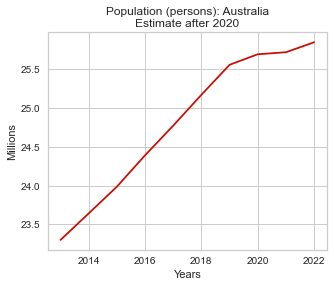

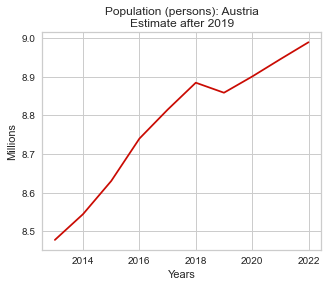

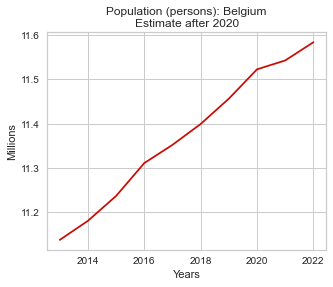

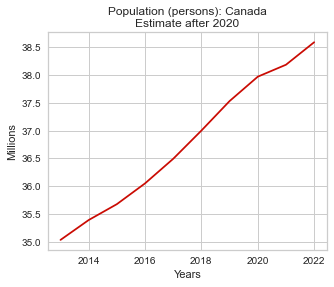

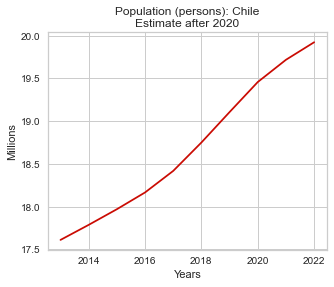

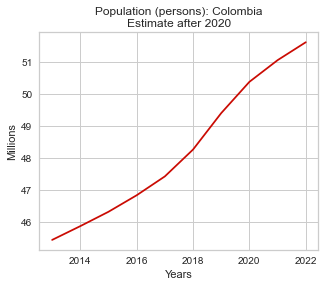

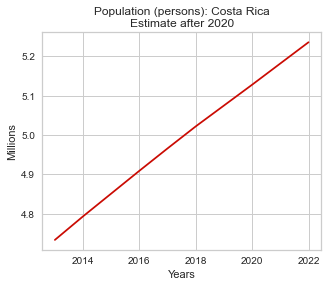

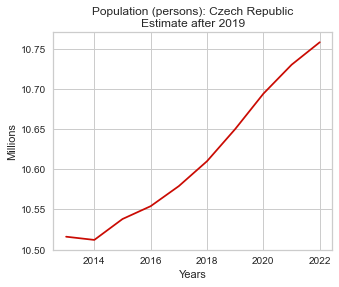

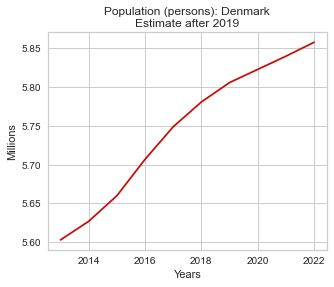

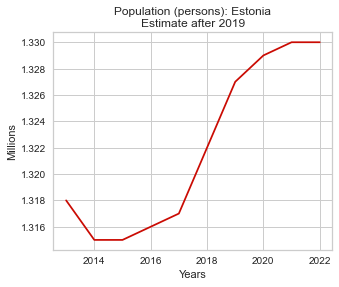

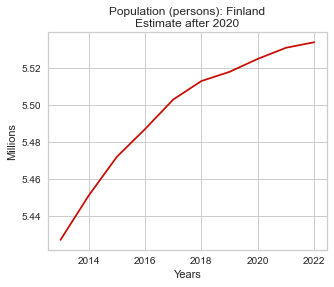

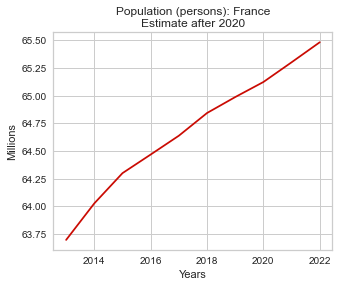

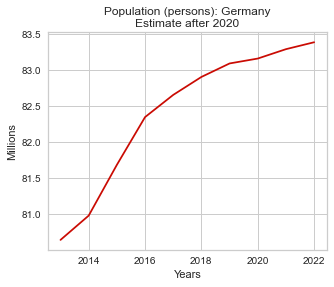

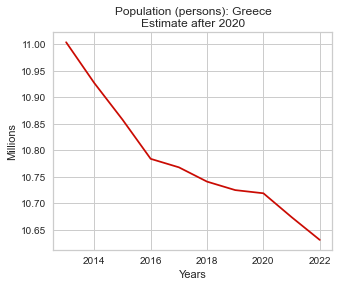

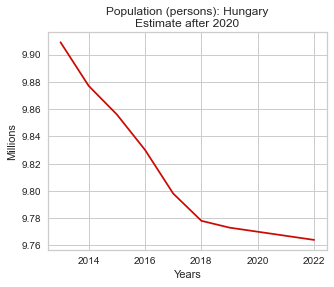

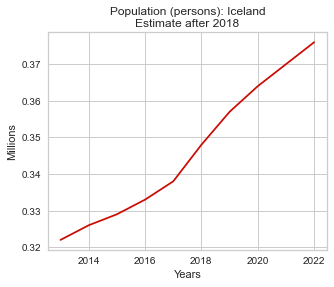

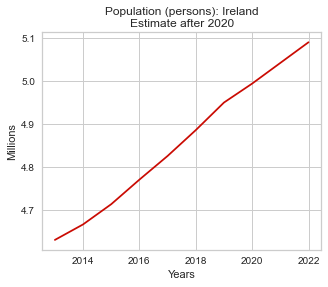

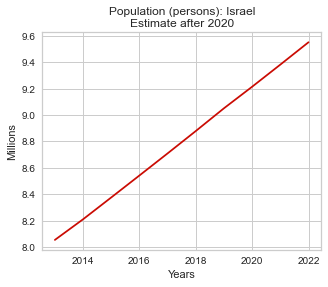

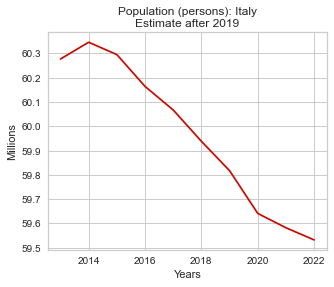

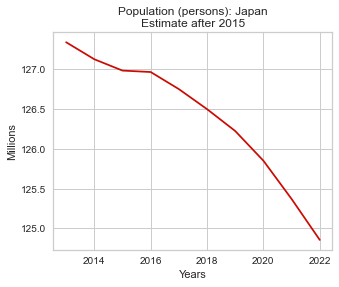

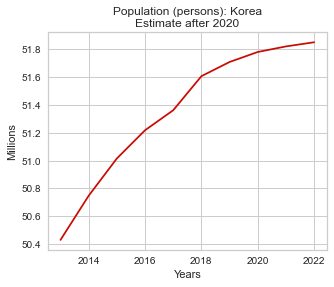

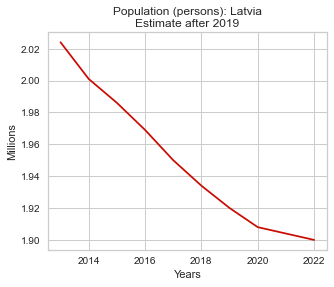

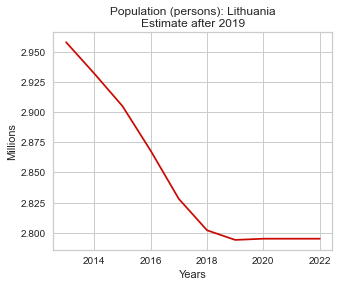

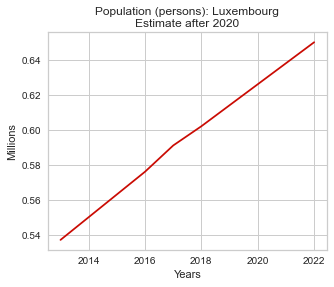

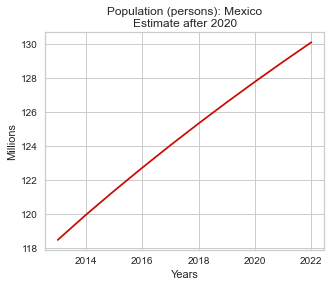

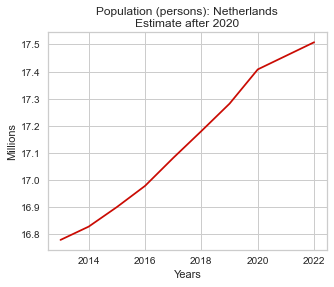

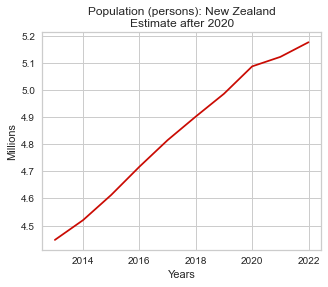

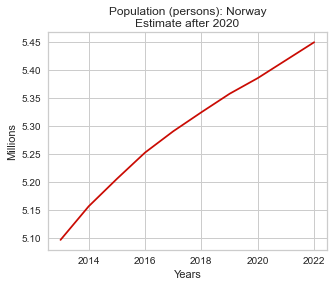

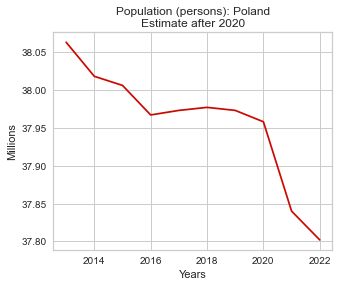

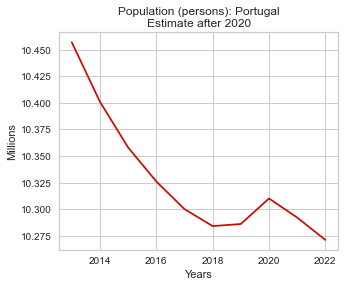

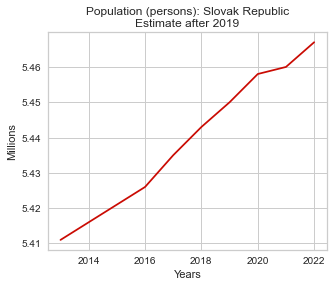

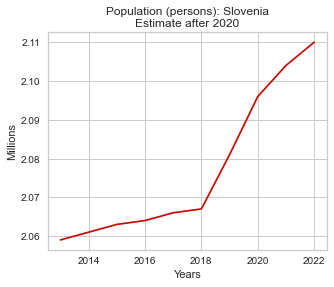

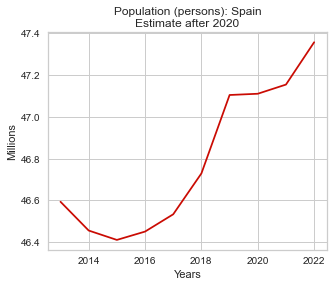

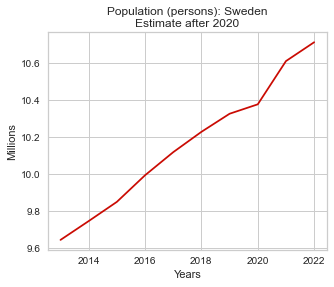

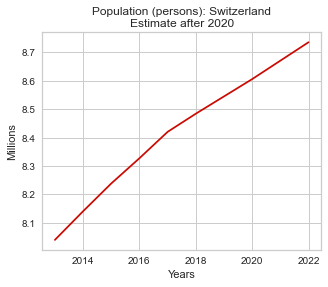

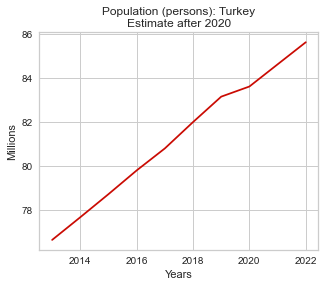

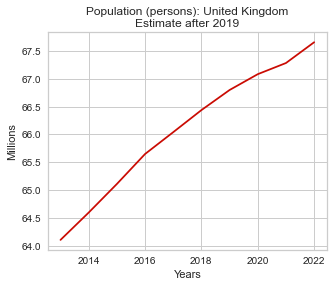

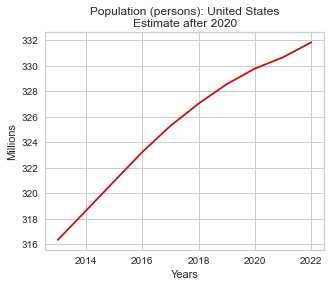

In [28]:
# df for plotting
data = df_OECD_pop10
folder_name = 'Ex2_Population'

print(f'\n>>> Plots will be saved in "{folder_name}" folder.')
print(f'---------------------------------------------------')   

""" Ploting population of all OECD countries in one fig """
""" Imposible to save by one fig >>> so unuseful for ex2 """
"""
fig, axs = plt.subplots(13, 3, sharex=False, sharey=False, figsize=(20, 95))

counter = 0

for c in data.columns:  
    trace_x = counter // 3
    trace_y = counter % 3
    axs[trace_x, trace_y].plot(data[c], color='r')
    est_after = int(df_OECD_pop_all['Estimates Start After'][df_OECD_pop_all['Country']==c])
    axs[trace_x, trace_y].set_title(f'Population (persons): {c}\nEstimate after {est_after}')
    axs[trace_x, trace_y].set_ylabel('Millions')   
    counter += 1

plt.show(); 
"""

# creating a new folder for output - 'Ex2_Population/'
script_dir = os.path.dirname('__file__')
results_dir = os.path.join(script_dir, str(folder_name)+str('/'))

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

# plotting and saving
for i in data.columns:
    plt.rcParams.update({'figure.max_open_warning': 0})
    plt.figure()
    plt.plot(data[i], color='r')
    est_after = int(df_OECD_pop_all['Estimates Start After'][df_OECD_pop_all['Country']==i])
    plt.title(f'Population (persons): {i}\nEstimate after {est_after}')
    plt.xlabel('Years')
    plt.ylabel('Millions')
    plt.savefig(results_dir + f'Population_{i}.png')


### 2.4. Exercise #3
> *i)* Padalinkite šalis į 5 klasterius pagal GDP ir "Volume of exports of goods".<br>
> *ii)* Nubraižykite klasterius (GDP x-ašis ir Volume y-ašis).<br>
> *iii)* Pažymėkite top 5 šalis pagal GDP kiekviename klasteryje ir pridėkite tekstinį žymeklį.<br>
>  <br>
> *iv)* Nustatytas optimalus klasterių skaičius pagal *inertias*.<br>

* #### CLUSTERTING: NOT SCALED DATA
#### <span style='background:#FFC0CB'> NOT RECOMMENDED  </span>

In [29]:
clusters_no_scale(
    year = 2019,
    c_num = 5,
    sub1_name = 'Gross domestic product per capita, current prices / U.S. dollars / Units',
    sub2_name = 'Volume of Imports of goods / Percent change / ')


>>> DATA WITH PREDICTED CLUSTERS <<<

>>> !!! DATA ARE NOT SCALED !!! <<<
-----------------------------------------------------------------------------------------------

>>> Selected :
>>> >>> Data Years : 2019,
>>> >>> Subject_1 : "Gross domestic product per capita, current prices / U.S. dollars / Units",
>>> >>> Subject_2 : "Volume of Imports of goods / Percent change / ",
>>> >>> Number of Clusters : 5.
-----------------------------------------------------------------------------------------------
>>> Output - DataFrame by name "clusters_no_scale.df_Clust". 
>>> >>> Please use it for funcions: "clusters_plot". 
-----------------------------------------------------------------------------------------------


Country Continent  \
92                 Luxembourg    Europe   
83                      Korea      Asia   
98                      Malta    Europe   
141                     Spain    Europe   
22          Brunei Darussalam      Asia   
..                        ...       ...   
135              Sierra Leone    Africa   
93                 Madagascar    Africa   
106                Mozambique    Africa   
30   Central African Republic    Africa   
25                    Burundi    Africa   

     Gross domestic product per capita, current prices / U.S. dollars / Units  \
92                                          115838.953                          
83                                           31936.795                          
98                                           31865.843                          
141                                          29576.250                          
22                                           29314.112                          
..                                                 ...                          
135                                            527.171                          
93                                             512.176                          
106                                            506.817                          
30                                             479.846                          
25                                             261.294                          

     Volume of Imports of goods / Percent change /  Cluster  
92                                            1.772       4  
83                                           -2.508       3  
98                                            6.808       3  
141                                          -0.304       3  
22                                           12.806       3  
..                                              ...     ...  
135                                          16.457       0  
93                                            3.406       0  
106                                          12.248       0  
30                                           10.407       0  
25                                           44.459       0  

[174 rows x 5 columns]


>>> CLUSTERS PLOT WITH TOP5 LABELS
----------------------------------

>>> >>> TOP5 CLUSTERS LIST
--------------------------


Cluster          0            1            2                  3           4
1        St. Lucia    Australia  Switzerland              Korea  Luxembourg
2           Russia  Netherlands      Ireland              Malta            
3         Malaysia       Sweden       Norway              Spain            
4        Mauritius      Austria      Iceland  Brunei Darussalam            
5          Grenada      Finland    Singapore             Kuwait

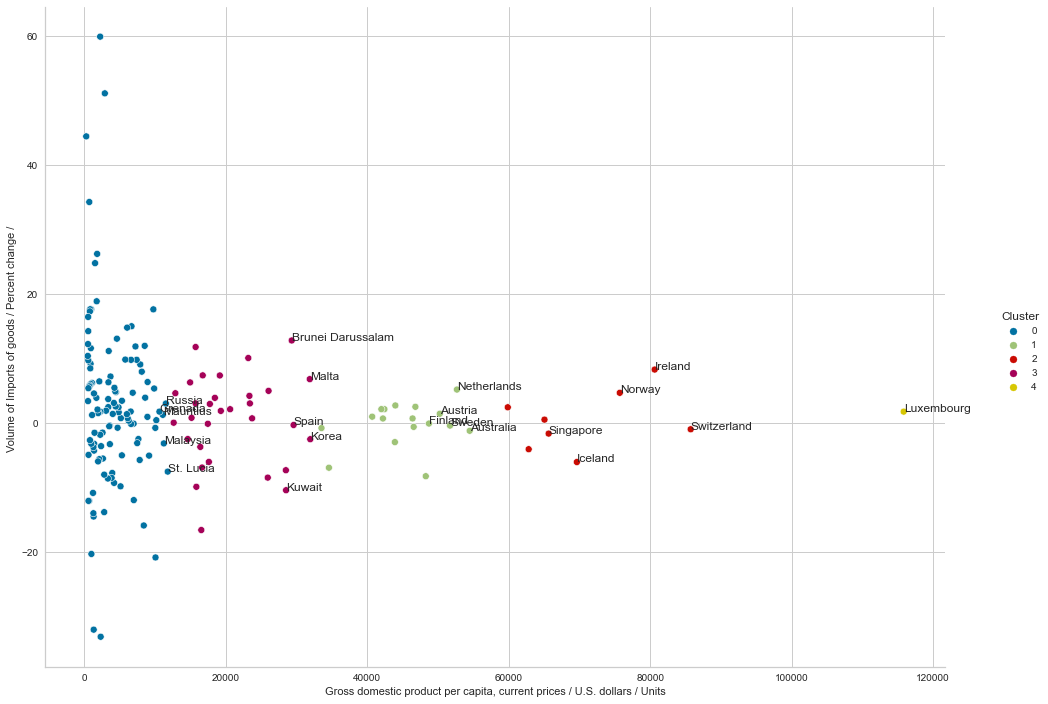

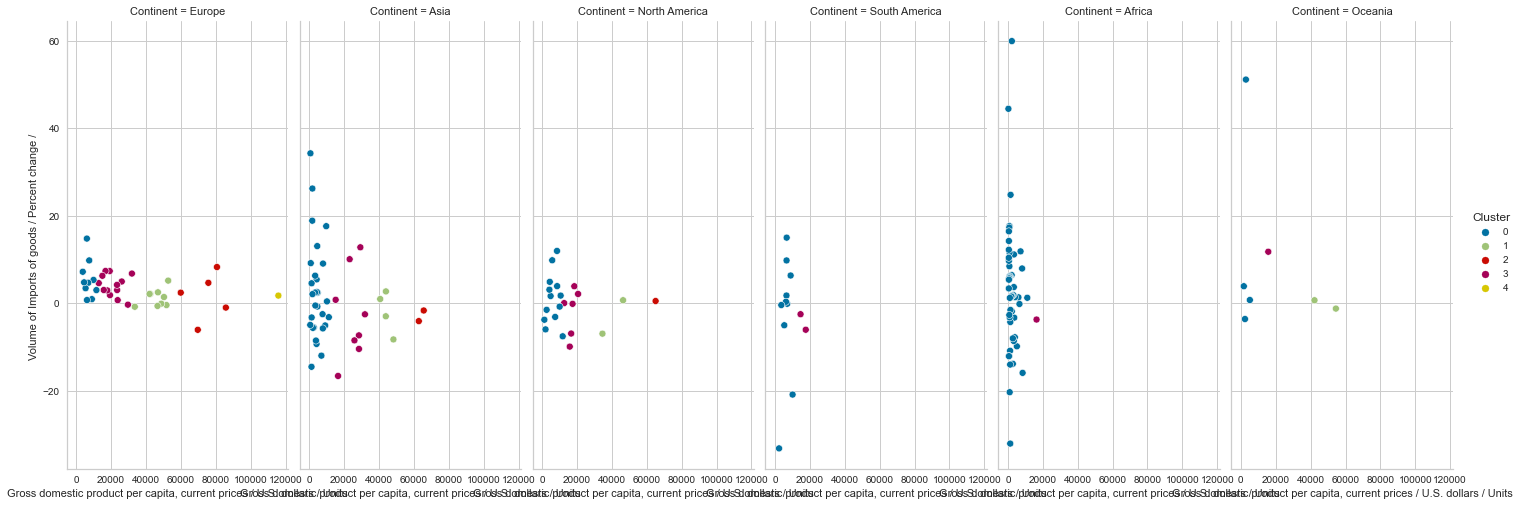

In [30]:
clusters_plot(
    data = clusters_no_scale.df_Clust, 
    top_num = 5)

* #### CLUSTERTING: SCALED DATA
#### <span style='background:#90EE90'> RECOMMENDED  </span>

In [31]:
print(f'\n>>> List of Variables For Clustering: ')
print('---------------------------------------')

df_all['Full Subject'].unique()


>>> List of Variables For Clustering: 
---------------------------------------


array(['Gross domestic product, constant prices / National currency / Billions',
       'Gross domestic product, constant prices / Percent change / ',
       'Gross domestic product, current prices / National currency / Billions',
       'Gross domestic product, current prices / U.S. dollars / Billions',
       'Gross domestic product, current prices / Purchasing power parity; international dollars / Billions',
       'Gross domestic product, deflator / Index / ',
       'Gross domestic product per capita, constant prices / National currency / Units',
       'Gross domestic product per capita, constant prices / Purchasing power parity; 2017 international dollar / Units',
       'Gross domestic product per capita, current prices / National currency / Units',
       'Gross domestic product per capita, current prices / U.S. dollars / Units',
       'Gross domestic product per capita, current prices / Purchasing power parity; international dollars / Units',
       'Gross domestic product b

In [32]:
clusters_scale(
    year = 2019,
    c_num = 5,
    sub1_name = 'Gross domestic product per capita, current prices / U.S. dollars / Units',
    sub2_name = 'Volume of Imports of goods / Percent change / ')


>>> DATA WITH PREDICTED CLUSTERS <<<

>>> >> DATA ARE SCALED << <<<
-----------------------------------------------------------------------------------------------

>>> Selected :
>>> >>> Data Years : 2019,
>>> >>> Subject_1 : "Gross domestic product per capita, current prices / U.S. dollars / Units",
>>> >>> Subject_2 : "Volume of Imports of goods / Percent change / ",
>>> >>> Number of Clusters : 5.
-----------------------------------------------------------------------------------------------
>>> Output : DataFrame by name "clusters_scale.df_Clust". 
>>> >>> Please use it for funcions: "clusters_plot".
-----------------------------------------------------------------------------------------------


Country      Continent  \
22   Brunei Darussalam           Asia   
131       Saudi Arabia           Asia   
118              Palau        Oceania   
80          Kazakhstan           Asia   
44            Dominica  North America   
..                 ...            ...   
24        Burkina Faso         Africa   
155         The Gambia         Africa   
31                Chad         Africa   
50             Eritrea         Africa   
93          Madagascar         Africa   

     Gross domestic product per capita, current prices / U.S. dollars / Units  \
22                                           29314.112                          
131                                          23173.841                          
118                                          15725.084                          
80                                            9750.431                          
44                                            8524.696                          
..                                                 ...                          
24                                             786.929                          
155                                            768.921                          
31                                             685.677                          
50                                             566.731                          
93                                             512.176                          

     Volume of Imports of goods / Percent change /   Cluster  
22                                           12.806        4  
131                                          10.085        4  
118                                          11.792        4  
80                                           17.631        4  
44                                           11.973        4  
..                                              ...      ...  
24                                           -2.658        0  
155                                           5.832        0  
31                                            5.684        0  
50                                            5.401        0  
93                                            3.406        0  

[174 rows x 5 columns]

>>> Output : DataFrame of scaled data by name "clusters_scale.scaled_data". 
>>> >>> Please use it for funcions: "Elbow".
-----------------------------------------------------------------------------------------------


Gross domestic product per capita, current prices / U.S. dollars / Units  \
0                                          -0.712266                          
1                                          -0.474848                          
2                                          -0.543552                          
3                                          -0.600620                          
4                                           0.136272                          

   Volume of Imports of goods / Percent change /   
0                                       -0.627805  
1                                        0.123707  
2                                       -0.879205  
3                                       -0.902311  
4                                       -0.195849


>>> CLUSTERS PLOT WITH TOP5 LABELS
----------------------------------

>>> >>> TOP5 CLUSTERS LIST
--------------------------


Cluster               0            1                    2                 3  \
1                 Spain   Luxembourg               Kuwait  Papua New Guinea   
2              Slovenia  Switzerland               Cyprus           Nigeria   
3        Czech Republic      Ireland              Bahrain             Yemen   
4               Estonia       Norway              Uruguay           Burundi   
5              Portugal      Iceland  Trinidad and Tobago                     

Cluster                  4  
1        Brunei Darussalam  
2             Saudi Arabia  
3                    Palau  
4               Kazakhstan  
5                 Dominica

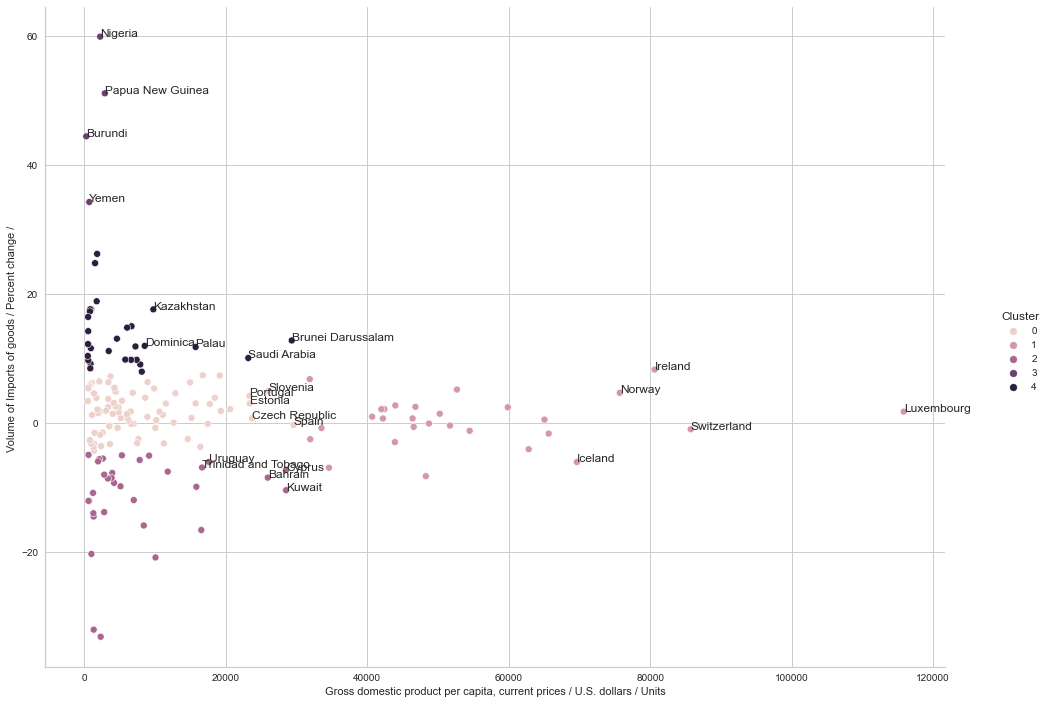

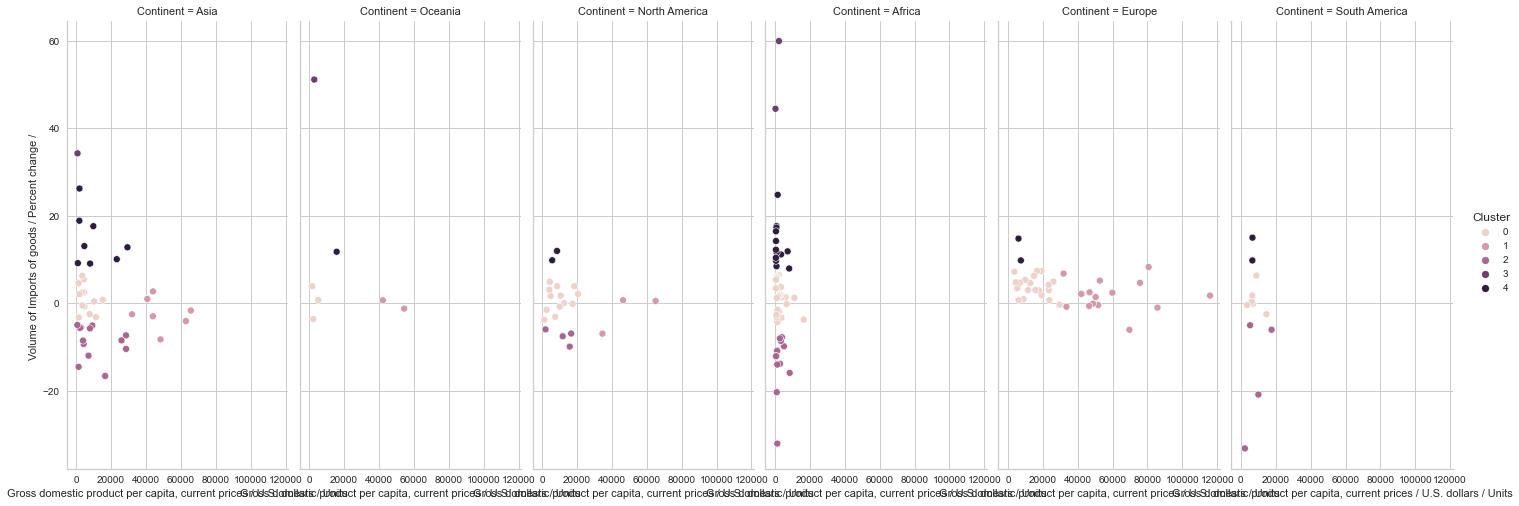

In [33]:
clusters_plot(
    data = clusters_scale.df_Clust, 
    top_num = 5)

* #### ELBOW METHOD FOR OPTIMAL NUMBER OF CLUSTERS


>>> USING KElbowVisualizer:
----------------------------------------------------------------


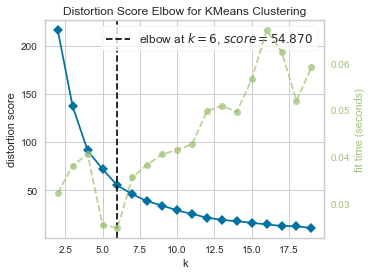

>>> COUNTING INERTIAS:
----------------------------------------------------------------


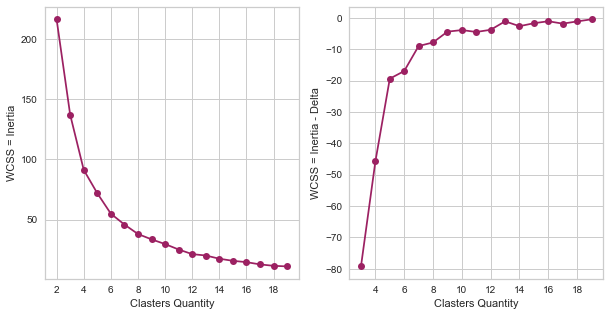

In [34]:
Elbow(clusters_scale.scaled_data)

* #### CLUSTERING BY ELBOW METHOD RESULTS

In [35]:
clusters_scale(
    year = 2019,
    c_num = 6,
    sub1_name = 'Gross domestic product per capita, current prices / U.S. dollars / Units',
    sub2_name = 'Volume of Imports of goods / Percent change / ')


>>> DATA WITH PREDICTED CLUSTERS <<<

>>> >> DATA ARE SCALED << <<<
-----------------------------------------------------------------------------------------------

>>> Selected :
>>> >>> Data Years : 2019,
>>> >>> Subject_1 : "Gross domestic product per capita, current prices / U.S. dollars / Units",
>>> >>> Subject_2 : "Volume of Imports of goods / Percent change / ",
>>> >>> Number of Clusters : 6.
-----------------------------------------------------------------------------------------------
>>> Output : DataFrame by name "clusters_scale.df_Clust". 
>>> >>> Please use it for funcions: "clusters_plot".
-----------------------------------------------------------------------------------------------


Country Continent  \
7       Australia   Oceania   
109   Netherlands    Europe   
148        Sweden    Europe   
8         Austria    Europe   
54        Finland    Europe   
..            ...       ...   
24   Burkina Faso    Africa   
155    The Gambia    Africa   
31           Chad    Africa   
50        Eritrea    Africa   
93     Madagascar    Africa   

     Gross domestic product per capita, current prices / U.S. dollars / Units  \
7                                            54476.913                          
109                                          52672.504                          
148                                          51694.498                          
8                                            50246.607                          
54                                           48716.216                          
..                                                 ...                          
24                                             786.929                          
155                                            768.921                          
31                                             685.677                          
50                                             566.731                          
93                                             512.176                          

     Volume of Imports of goods / Percent change /   Cluster  
7                                            -1.198        5  
109                                           5.194        5  
148                                          -0.395        5  
8                                             1.442        5  
54                                           -0.076        5  
..                                              ...      ...  
24                                           -2.658        0  
155                                           5.832        0  
31                                            5.684        0  
50                                            5.401        0  
93                                            3.406        0  

[174 rows x 5 columns]

>>> Output : DataFrame of scaled data by name "clusters_scale.scaled_data". 
>>> >>> Please use it for funcions: "Elbow".
-----------------------------------------------------------------------------------------------


Gross domestic product per capita, current prices / U.S. dollars / Units  \
0                                          -0.712266                          
1                                          -0.474848                          
2                                          -0.543552                          
3                                          -0.600620                          
4                                           0.136272                          

   Volume of Imports of goods / Percent change /   
0                                       -0.627805  
1                                        0.123707  
2                                       -0.879205  
3                                       -0.902311  
4                                       -0.195849


>>> CLUSTERS PLOT WITH TOP5 LABELS
----------------------------------

>>> >>> TOP5 CLUSTERS LIST
--------------------------


Cluster                    0            1                    2  \
1             Czech Republic   Luxembourg              Uruguay   
2                    Estonia  Switzerland  Trinidad and Tobago   
3                   Portugal      Ireland                 Oman   
4        St. Kitts and Nevis       Norway               Panama   
5            Slovak Republic      Iceland            St. Lucia   

Cluster                 3                  4            5  
1        Papua New Guinea  Brunei Darussalam    Australia  
2                 Nigeria       Saudi Arabia  Netherlands  
3                   Yemen              Palau       Sweden  
4                 Burundi         Kazakhstan      Austria  
5                                   Dominica      Finland

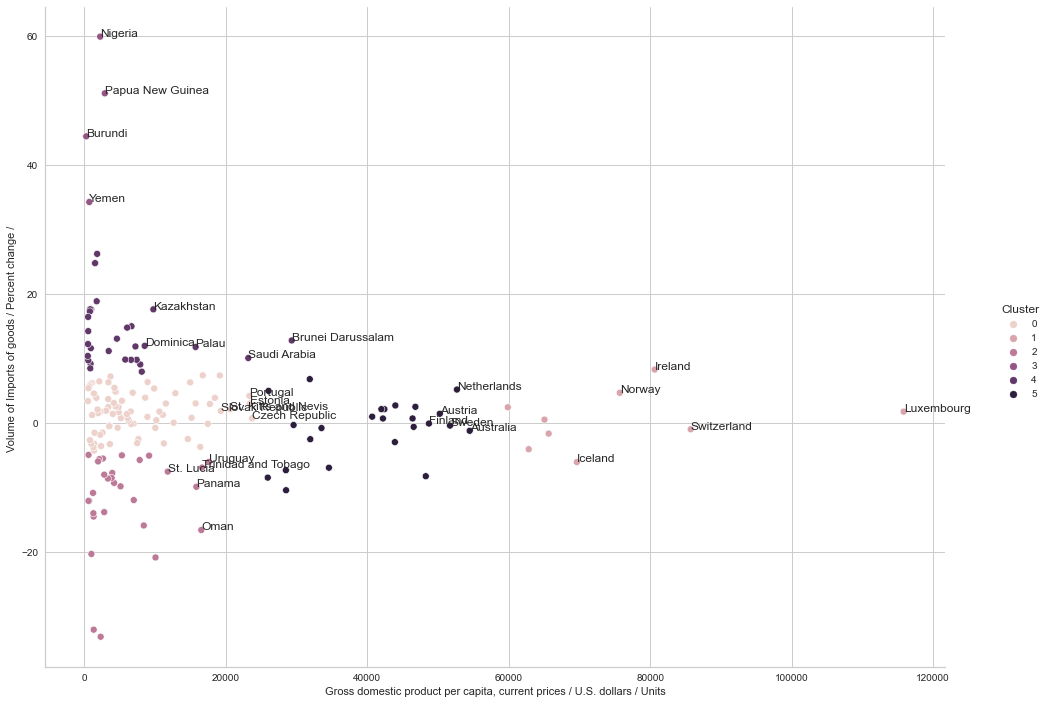

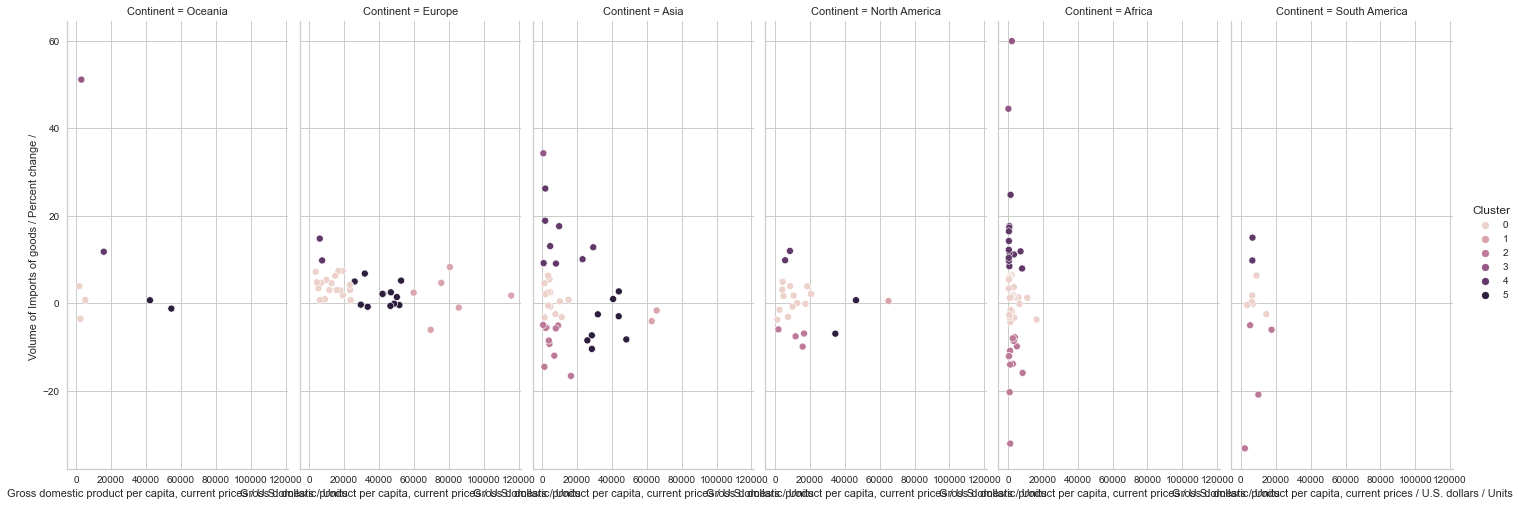

In [36]:
clusters_plot(
    data = clusters_scale.df_Clust, 
    top_num = 5)

### 2.5. Exercise #4
> Raskite visas metrikas, kurios nėra tuščios 2015 metų duomenyse.<br>

In [37]:
# select data: df.2015 is not null
col_name = 2015

df4 = df_all.loc[lambda df_all: df_all[col_name].isnull()==False, :]

print(f'\nAll data shape : {df_all.shape}')
print(f'Selected df, without null in column "{col_name}", shape : {df4.shape}')
print(f'Rows number with null value in column "{col_name}" : {df_all.shape[0]-df4.shape[0]}')

print('--------------------------------------------------------------')
df4_features = sorted(df4['Full Subject'].unique())
print(f'\nList of features which are not null in column "{col_name}" :')
display(df4_features)


All data shape : (7519, 35)
Selected df, without null in column "2015", shape : (7459, 35)
Rows number with null value in column "2015" : 60
--------------------------------------------------------------

List of features which are not null in column "2015" :


['Current account balance / Percent of GDP / ',
 'Current account balance / U.S. dollars / Billions',
 'Employment / Persons / Millions',
 'General government gross debt / National currency / Billions',
 'General government gross debt / Percent of GDP / ',
 'General government net debt / National currency / Billions',
 'General government net debt / Percent of GDP / ',
 'General government net lending/borrowing / National currency / Billions',
 'General government net lending/borrowing / Percent of GDP / ',
 'General government primary net lending/borrowing / National currency / Billions',
 'General government primary net lending/borrowing / Percent of GDP / ',
 'General government revenue / National currency / Billions',
 'General government revenue / Percent of GDP / ',
 'General government structural balance / National currency / Billions',
 'General government structural balance / Percent of potential GDP / ',
 'General government total expenditure / National currency / Billions',


## 3. GDP PREDICTION MODEL
> Modelio kūrimas: Naudodamiesi scikit-learn biblioteka sukurkite modelį, kuris leistų prognozuoti šalies GDP per capita reikšmę.<br>
<br>
> Model deployment: sukurkite API, kur su POST request nusiuntus 5 reikšmingiausius kintamuosius gautumėm GDP per capita prognozę.<br>

### 3.1. DATA PREPARATION

* #### SELECTING AND CLEANING

In [38]:
print('\n*** GDP MODEL.   3.1. Data preparation: Selecting and Cleaning ***')
print('------------------------------------------------------------------')

print('\n*** CHANGES OF DATA SHAPE (df) ***')
print('-----------------------------------')

print(f'   > Primary data shape: {df.shape}')
df3 = df.copy()

df3 = df3[(df3['Estimates Start After']>=2019)&(df3['Estimates Start After']<2021)]
print(f'\n1. Selected 2019<="Estimates Start After"<2021 (act data):')
print(f'   > Lefted "Estimate start after": {df3["Estimates Start After"].unique()}')
print(f'   > Interim data shape: {df3.shape}')

col_delete = list(range(2020, 2027))
df3 = df3.drop(col_delete, axis=1)
print(f'\n2. Dropped years columns in [2020, 2026]')
print(f'   > Interim data shape: {df3.shape}')


col_dropnull = list(range(2000, 2020))
df3 = df3.dropna(subset=col_dropnull)
print(f'\n3. Dropped nan in years columns in [2000, 2019]')
print(f'   > Interim data shape: {df3.shape}')

col_delete2 = ['Country/Series-specific Notes', 'WEO Country Code', 'WEO Subject Code', 'ISO']
df3 = df3.drop(col_delete2, axis=1)
print(f'\n4. Dropped 4 columns: {col_delete2}')
print(f'   > Interim data shape: {df3.shape}')

print(f'\n>>> Check: interim data "isnull" list:\n')
print(df3.isnull().sum())

print(f'\n>>> Interim data "Full Subject" unique values: {len(df3["Full Subject"].unique())}\n')
print(f'\n>>> Interim data "Country" unique values: {len(df3["Country"].unique())}\n')


*** GDP MODEL.   3.1. Data preparation: Selecting and Cleaning ***
------------------------------------------------------------------

*** CHANGES OF DATA SHAPE (df) ***
-----------------------------------
   > Primary data shape: (7635, 34)

1. Selected 2019<="Estimates Start After"<2021 (act data):
   > Lefted "Estimate start after": [2019 2020]
   > Interim data shape: (6677, 34)

2. Dropped years columns in [2020, 2026]
   > Interim data shape: (6677, 27)

3. Dropped nan in years columns in [2000, 2019]
   > Interim data shape: (6158, 27)

4. Dropped 4 columns: ['Country/Series-specific Notes', 'WEO Country Code', 'WEO Subject Code', 'ISO']
   > Interim data shape: (6158, 23)

>>> Check: interim data "isnull" list:

Country                  0
2000                     0
2001                     0
2002                     0
2003                     0
2004                     0
2005                     0
2006                     0
2007                     0
2008                     0

* #### PIVOTING (preparing final DataFrame for Regression Models)

In [39]:
print('\n*** GDP MODEL.   3.1. Data preparation: Pivoting ***')
print('----------------------------------------------------')

df3_reg = df3.copy()
df3_reg = df3_reg.drop('Estimates Start After', axis=1)
df3_reg = df3_reg[['Country', 'Full Subject',
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019]]


print("\n5. Interim data :\n")
display(df3_reg.head(3))

print(f'\n6. Interim data - after melting :\n')
df3_reg = pd.melt(df3_reg, id_vars=['Country', 'Full Subject']).rename({'variable': 'Year', 'value': 'Value'}, axis=1)
display(df3_reg.head(3))

print(f'\n7. Interim data - after cleaning and changing dtypes :\n')
df3_reg['Value'] = (df3_reg['Value'].astype(str).str.replace(",", ""))
df3_reg['Value'] = (df3_reg['Value'].astype(str).str.replace("--", "NaN"))
df3_reg['Value'] = df3_reg['Value'].astype(float)
print(df3_reg.dtypes)

print(f'\n8. Final data (df3_reg) - after pivoting :\n')
df3_reg = pd.pivot_table(df3_reg, values='Value', index=['Country', 'Year'], columns='Full Subject')
df3_reg = df3_reg.reset_index().rename_axis(None, axis=1)
display(df3_reg.head(3))


*** GDP MODEL.   3.1. Data preparation: Pivoting ***
----------------------------------------------------

5. Interim data :



Country                                       Full Subject     2000  \
45  Albania  Gross domestic product, constant prices / Nati...  391.330   
46  Albania  Gross domestic product, constant prices / Perc...    6.946   
47  Albania  Gross domestic product, current prices / Natio...  501.199   

       2001     2002     2003     2004     2005     2006     2007  ...  \
45  423.784  443.009  467.501  493.283  520.544  551.270  584.254  ...   
46    8.293    4.537    5.529    5.515    5.526    5.903    5.983  ...   
47  563.449  610.494  677.738  737.656  804.163  872.735  965.528  ...   

        2010      2011      2012      2013      2014      2015      2016  \
45   673.204   690.339   700.125   707.140   719.688   735.657   760.042   
46     3.707     2.545     1.418     1.002     1.774     2.219     3.315   
47  1239.645  1300.624  1332.811  1350.052  1395.304  1434.306  1472.479   

        2017      2018      2019  
45   788.941   821.061   838.908  
46     3.802     4.071     2.174  
47  1550.646  1635.715  1679.247  

[3 rows x 22 columns]


6. Interim data - after melting :



Country                                       Full Subject  Year    Value
0  Albania  Gross domestic product, constant prices / Nati...  2000  391.330
1  Albania  Gross domestic product, constant prices / Perc...  2000    6.946
2  Albania  Gross domestic product, current prices / Natio...  2000  501.199


7. Interim data - after cleaning and changing dtypes :

Country          object
Full Subject     object
Year             object
Value           float64
dtype: object

8. Final data (df3_reg) - after pivoting :



Country  Year  Current account balance / Percent of GDP /   \
0  Albania  2000                                       -7.070   
1  Albania  2001                                       -6.315   
2  Albania  2002                                      -10.179   

   Current account balance / U.S. dollars / Billions  \
0                                             -0.246   
1                                             -0.248   
2                                             -0.443   

   Employment / Persons / Millions  \
0                              NaN   
1                              NaN   
2                              NaN   

   General government gross debt / National currency / Billions  \
0                                            319.608              
1                                            341.522              
2                                            391.308              

   General government gross debt / Percent of GDP /   \
0                                             63.769   
1                                             60.613   
2                                             64.097   

   General government net debt / National currency / Billions  \
0                                                NaN            
1                                                NaN            
2                                                NaN            

   General government net debt / Percent of GDP /   \
0                                              NaN   
1                                              NaN   
2                                              NaN   

   General government net lending/borrowing / National currency / Billions  \
0                                            -38.954                         
1                                            -38.524                         
2                                            -37.922                         

   ...  Inflation, end of period consumer prices / Percent change /   \
0  ...                                              4.205              
1  ...                                              3.527              
2  ...                                              1.681              

   Output gap in percent of potential GDP / Percent of potential GDP /   \
0                                                NaN                      
1                                                NaN                      
2                                                NaN                      

   Population / Persons / Millions  \
0                            3.089   
1                            3.060   
2                            3.051   

   Six-month London interbank offered rate (LIBOR) / Percent /   \
0                                                NaN              
1                                                NaN              
2                                                NaN              

   Total investment / Percent of GDP /   \
0                                30.796   
1                                34.989   
2                                35.264   

   Unemployment rate / Percent of total labor force /   \
0                                             16.800     
1                                             16.440     
2                                             15.751     

   Volume of Imports of goods / Percent change /   \
0                                         -14.300   
1                                          33.181   
2                                           6.066   

   Volume of exports of goods / Percent change /   \
0                                          -7.088   
1                                          23.048   
2                                           8.253   

   Volume of exports of goods and services / Percent change /   \
0                                             16.254             
1                                             23.900             
2                                    

* #### ANALYSIS OF ISNA() QUANTITY

In [40]:
print('\n*** GDP MODEL.   3.1. Data preparation: Analysis of ISNA() Quantity ***')
print('-----------------------------------------------------------------------')

df3_isnull = df3_reg.loc[:, df3_reg.isna().any()]
df3_isnull = df3_isnull.join(df3_reg['Country'])

print(f'\n>>> Prepared data shape : {df3_reg.shape}')
print(f'\n>>> Prepared data isna().any() shape : {df3_isnull.shape}\n')
print('-----------------------------------------------------------------------')
print(f'\n>>> Prepared data Country.unique() : {len(df3_reg.Country.unique())}')
print(f'\n>>> Prepared data isnull.Country.unique() : {len(df3_isnull.Country.unique())}\n')
print('-----------------------------------------------------------------------')
print(f'\n>>> Prepared data isnull().sum() list :\n')
isnull = df3_isnull.isnull().sum()
isnull_list = {'Subject':  isnull.index, 'isnull().sum()': isnull.values}
isnull_list = pd.DataFrame(isnull_list)
isnull_list.index = np.arange(1, len(isnull_list) + 1)
display(isnull_list)


*** GDP MODEL.   3.1. Data preparation: Analysis of ISNA() Quantity ***
-----------------------------------------------------------------------

>>> Prepared data shape : (3780, 47)

>>> Prepared data isna().any() shape : (3780, 46)

-----------------------------------------------------------------------

>>> Prepared data Country.unique() : 189

>>> Prepared data isnull.Country.unique() : 189

-----------------------------------------------------------------------

>>> Prepared data isnull().sum() list :



Subject  isnull().sum()
1         Current account balance / Percent of GDP /              660
2   Current account balance / U.S. dollars / Billions             600
3                     Employment / Persons / Millions            3040
4   General government gross debt / National curre...             780
5   General government gross debt / Percent of GDP /              780
6   General government net debt / National currenc...            2400
7     General government net debt / Percent of GDP /             2400
8   General government net lending/borrowing / Nat...             560
9   General government net lending/borrowing / Per...             520
10  General government primary net lending/borrowi...             740
11  General government primary net lending/borrowi...             720
12  General government revenue / National currency...             400
13     General government revenue / Percent of GDP /              420
14  General government structural balance / Nation...            2480
15  General government structural balance / Percen...            2580
16  General government total expenditure / Nationa...             500
17  General government total expenditure / Percent...             520
18  Gross domestic product based on purchasing-pow...             500
19  Gross domestic product corresponding to fiscal...             260
20  Gross domestic product per capita, constant pr...            1460
21  Gross domestic product per capita, constant pr...            1460
22  Gross domestic product per capita, current pri...            1460
23  Gross domestic product per capita, current pri...            1460
24  Gross domestic product per capita, current pri...            1460
25  Gross domestic product, constant prices / Nati...             400
26  Gross domestic product, constant prices / Perc...             540
27  Gross domestic product, current prices / Natio...             400
28  Gross domestic product, current prices / Purch...             400
29  Gross domestic product, current prices / U.S. ...             420
30        Gross domestic product, deflator / Index /              400
31         Gross national savings / Percent of GDP /              900
32  Implied PPP conversion rate / National currenc...             400
33      Inflation, average consumer prices / Index /              180
34  Inflation, average consumer prices / Percent c...             260
35  Inflation, end of period consumer prices / Ind...             220
36  Inflation, end of period consumer prices / Per...             280
37  Output gap in percent of potential GDP / Perce...            3240
38                    Population / Persons / Millions            1360
39  Six-month London interbank offered rate (LIBOR...            3740
40               Total investment / Percent of GDP /              920
41  Unemployment rate / Percent of total labor for...            1920
42     Volume of Imports of goods / Percent change /              720
43     Volume of exports of goods / Percent change /              720
44  Volume of exports of goods and services / Perc...             680
45  Volume of imports of goods and services / Perc...             680
46                                            Country               0

* #### EU COUNTRIES DATA : SELECTION

In [41]:
print('\n*** GDP MODEL.   3.1. Data preparation: EU Countries data - Selection ***')
print('-------------------------------------------------------------------------')

print('\n1. Merged data with EU countries list :')
df3_reg_eu = pd.merge(df3_reg, eu_country_list['Country'], on="Country")
df3_reg_eu = df3_reg_eu.rename({'Country': 'Country_EU'}, axis=1)
display(df3_reg_eu)

print('\n2. Check data - is all countries selected?')

print(f'\nEU countries list in REG data :\n')
print(f'Countries List: {sorted(df3_reg_eu.Country_EU.unique())}')
print(f'Total: {len(df3_reg_eu.Country_EU.unique())}')

print(f'\nEU countries list in primary EU countries list :\n')
print(f'Countries List: {sorted(eu_country_list.Country.unique())}')
print(f'Total: {len(eu_country_list.Country.unique())}')


*** GDP MODEL.   3.1. Data preparation: EU Countries data - Selection ***
-------------------------------------------------------------------------

1. Merged data with EU countries list :


Country_EU  Year  Current account balance / Percent of GDP /   \
0      Austria  2000                                       -0.706   
1      Austria  2001                                       -0.796   
2      Austria  2002                                        2.102   
3      Austria  2003                                        1.548   
4      Austria  2004                                        2.076   
..         ...   ...                                          ...   
535     Sweden  2015                                        3.314   
536     Sweden  2016                                        2.390   
537     Sweden  2017                                        2.951   
538     Sweden  2018                                        2.634   
539     Sweden  2019                                        5.462   

     Current account balance / U.S. dollars / Billions  \
0                                               -1.393   
1                                               -1.573   
2                                                4.504   
3                                                4.060   
4                                                6.255   
..                                                 ...   
535                                             16.740   
536                                             12.322   
537                                             15.967   
538                                             14.633   
539                                             29.159   

     Employment / Persons / Millions  \
0                              3.635   
1                              3.652   
2                              3.660   
3                              3.695   
4                              3.711   
..                               ...   
535                            4.837   
536                            4.910   
537                            5.022   
538                            5.097   
539                            5.126   

     General government gross debt / National currency / Billions  \
0                                              140.420              
1                                              146.328              
2                                              151.862              
3                                              150.470              
4                                              157.160              
..                                                 ...              
535                                           1863.474              
536                                           1865.591              
537                                           1883.820              
538                                           1878.592              
539                                           1760.946              

     General government gross debt / Percent of GDP /   \
0                                               65.738   
1                                               66.355   
2                                               66.978   
3                                               64.896   
4                                               64.849   
..                                                 ...   
535                                             43.739   
536                                             42.255   
537                                             40.730   
538                                             38.908   
539                                             34.873   

     General government net debt / National currency / Billions  \
0                                               93.415            
1                                               93.232            
2                                              100.305            
3                                               98.984            
4                                              111.959            
..                                                 ...            
53


2. Check data - is all countries selected?

EU countries list in REG data :

Countries List: ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovak Republic', 'Slovenia', 'Spain', 'Sweden']
Total: 27

EU countries list in primary EU countries list :

Countries List: ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovak Republic', 'Slovenia', 'Spain', 'Sweden']
Total: 27


* #### EU COUNTRIES DATA : CLEANING / REPLACING

In [42]:
print('\n*** GDP MODEL.   3.1. Data preparation: EU Countries data ***')
print('-------------------------------------------------------------')

df3_reg_eu_null = df3_reg_eu.loc[:, df3_reg_eu.isna().any()]
df3_reg_eu_null = df3_reg_eu_null.join(df3_reg_eu.Country_EU)
print(f'\n{len(df3_reg_eu_null.columns)-1} of {len(df3_reg_eu.columns)-2} Subject columns contains null >>>\n')

print(f'\n>>> df3_reg_eu isnull() sum list :\n')
isnull2 = df3_reg_eu_null.isnull().sum()
isnull_list2 = {'Subject':  isnull2.index,
        'isnull().sum()': isnull2.values}
isnull_list2 = pd.DataFrame(isnull_list2)
isnull_list2.index = np.arange(1, len(isnull_list2) + 1)

display(isnull_list2)


*** GDP MODEL.   3.1. Data preparation: EU Countries data ***
-------------------------------------------------------------

14 of 45 Subject columns contains null >>>


>>> df3_reg_eu isnull() sum list :



Subject  isnull().sum()
1         Current account balance / Percent of GDP /               20
2   Current account balance / U.S. dollars / Billions              20
3                     Employment / Persons / Millions             100
4   General government net debt / National currenc...             100
5     General government net debt / Percent of GDP /              100
6   General government primary net lending/borrowi...              40
7   General government primary net lending/borrowi...              20
8   General government structural balance / Nation...              60
9   General government structural balance / Percen...              80
10  Gross domestic product, constant prices / Perc...              20
11  Output gap in percent of potential GDP / Perce...             160
12  Six-month London interbank offered rate (LIBOR...             540
13     Volume of Imports of goods / Percent change /               60
14     Volume of exports of goods / Percent change /               60
15                                         Country_EU               0

In [43]:
print('\n*** GDP MODEL.   3.1. Data preparation: EU Countries data - Cleaning >> Dropping col ***')
print('----------------------------------------------------------------------------------------')

print('\n>>> Cleaning Conclusion: \nif isnull().sum() > 5\nthen drop subject (column)\nelse replace with average')
print('-----------------------------')

# drop columns by list
col_eu_del = isnull_list2.loc[isnull_list2['isnull().sum()']>5, 'Subject'].to_list() # select by 'isnull().sum()'
df3_reg_eu_final = df3_reg_eu.copy()
df3_reg_eu_final = df3_reg_eu_final.drop(col_eu_del, axis = 1)
print(f'Dropped Subjects number: {len(col_eu_del)}')
print('-----------------------------')
change_to_av = isnull_list2.loc[isnull_list2['isnull().sum()']<=5, :][:-1]
print('Change to average:')
display(change_to_av)

### !! subjects list for replacing with averages
col_eu_av = change_to_av['Subject'].to_list()


*** GDP MODEL.   3.1. Data preparation: EU Countries data - Cleaning >> Dropping col ***
----------------------------------------------------------------------------------------

>>> Cleaning Conclusion: 
if isnull().sum() > 5
then drop subject (column)
else replace with average
-----------------------------
Dropped Subjects number: 14
-----------------------------
Change to average:


Empty DataFrame
Columns: [Subject, isnull().sum()]
Index: []

In [44]:
print('\n*** GDP MODEL.   3.1. Data preparation: EU Countries data - Cleaning >> AVG Counting ***')
print('----------------------------------------------------------------------------------------')

print('\n>>> Nan values to be replaced:')
rep_av = df3_reg_eu_final[df3_reg_eu_final.isnull().any(axis=1)==True]
rep_av = rep_av[col_eu_av].merge(df3_reg_eu_final[['Country_EU', 'Year']], left_index=True, right_index=True)
rep_av = pd.melt(rep_av, id_vars=['Country_EU', 'Year']).rename({'variable': 'Full_Subject', 'value': 'Value'}, axis=1)
rep_av = rep_av[rep_av['Value'].isnull()]
rep_av['Value_avg'] = ""
display(rep_av)
print('----------------------------------------------------')

for ind in rep_av.index:
    country = rep_av['Country_EU'][ind]
    year = rep_av['Year'][ind]
    sub = rep_av['Full_Subject'][ind]
    print(f'>>> {country} >> "{sub}" :')
    
    # select years for avg counting
    if year in range(2001, 2020):
        x1 = year - 1
    else: x1 = year +1
    if year in range(2000, 2019):
        x2 = year + 1
    else: x2 = year - 1
    print(f'Null value of Year: {year}, average is counting by {x1} and {x2}.')

    # select sub value for avg counting
    y1 = df3_reg_eu_final.loc[(df3_reg_eu_final['Country_EU']==country)&(df3_reg_eu_final['Year']==x1), sub].values[0]
    y2 = df3_reg_eu_final.loc[(df3_reg_eu_final['Country_EU']==country)&(df3_reg_eu_final['Year']==x2), sub].values[0]
    y_list = [y1, y2]
    y_avg = sum(y_list)/len(y_list)
    rep_av.loc[[ind], 'Value_avg'] = y_avg
    print(f'Average of {y1} ({x1}) and {y2} ({x2}) = {y_avg}.')
    print('----------------------------------------------------')
    


*** GDP MODEL.   3.1. Data preparation: EU Countries data - Cleaning >> AVG Counting ***
----------------------------------------------------------------------------------------

>>> Nan values to be replaced:


Empty DataFrame
Columns: [Country_EU, Year, Full_Subject, Value, Value_avg]
Index: []

----------------------------------------------------


In [45]:
print('\n*** GDP MODEL.   3.1. Data preparation: EU Countries data - Cleaning >> Replacing With AVG ***')
print('----------------------------------------------------------------------------------------------')

print(f'\n>>> To be replaced with avg value :')
print('-----------------------------------')
display(rep_av)

for ind in list(rep_av.index):
    row1 = rep_av.loc[ind, 'Country_EU']
    row2 = rep_av.loc[ind, 'Year']
    col1 = rep_av.Full_Subject[ind]
    val = rep_av.loc[ind, 'Value_avg']
    df3_reg_eu_final.loc[
    (df3_reg_eu_final['Country_EU']==row1)&(df3_reg_eu_final['Year']==row2), [col1]
    ] = val
    
print(f'\n>>> Final check: df3_reg_eu_final isnull() sum list :')
print('------------------------------------------------------')
isnull3 = df3_reg_eu_final.isnull().sum()
isnull_list3 = {'Subject':  isnull3.index,
        'isnull().sum()': isnull3.values}
isnull_list3 = pd.DataFrame(isnull_list3)
isnull_list3.index = np.arange(1, len(isnull_list3) + 1)
display(isnull_list3)


*** GDP MODEL.   3.1. Data preparation: EU Countries data - Cleaning >> Replacing With AVG ***
----------------------------------------------------------------------------------------------

>>> To be replaced with avg value :
-----------------------------------


Empty DataFrame
Columns: [Country_EU, Year, Full_Subject, Value, Value_avg]
Index: []


>>> Final check: df3_reg_eu_final isnull() sum list :
------------------------------------------------------


Subject  isnull().sum()
1                                          Country_EU               0
2                                                Year               0
3   General government gross debt / National curre...               0
4   General government gross debt / Percent of GDP /                0
5   General government net lending/borrowing / Nat...               0
6   General government net lending/borrowing / Per...               0
7   General government revenue / National currency...               0
8      General government revenue / Percent of GDP /                0
9   General government total expenditure / Nationa...               0
10  General government total expenditure / Percent...               0
11  Gross domestic product based on purchasing-pow...               0
12  Gross domestic product corresponding to fiscal...               0
13  Gross domestic product per capita, constant pr...               0
14  Gross domestic product per capita, constant pr...               0
15  Gross domestic product per capita, current pri...               0
16  Gross domestic product per capita, current pri...               0
17  Gross domestic product per capita, current pri...               0
18  Gross domestic product, constant prices / Nati...               0
19  Gross domestic product, current prices / Natio...               0
20  Gross domestic product, current prices / Purch...               0
21  Gross domestic product, current prices / U.S. ...               0
22        Gross domestic product, deflator / Index /                0
23         Gross national savings / Percent of GDP /                0
24  Implied PPP conversion rate / National currenc...               0
25      Inflation, average consumer prices / Index /                0
26  Inflation, average consumer prices / Percent c...               0
27  Inflation, end of period consumer prices / Ind...               0
28  Inflation, end of period consumer prices / Per...               0
29                    Population / Persons / Millions               0
30               Total investment / Percent of GDP /                0
31  Unemployment rate / Percent of total labor for...               0
32  Volume of exports of goods and services / Perc...               0
33  Volume of imports of goods and services / Perc...               0

In [46]:
print('\n*** GDP MODEL.   3.1. Data preparation: EU Countries data - Cleaning >> GDP Subjects Removing ***')
print('-----------------------------------------------------------------------------------------------\n')

GDP_cols = [col for col in df3_reg_eu_final.columns if 'Gross domestic product' in col]
print(f'\n>>> GDP Subjects in data: {len(GDP_cols)} >>>')
print('--------------------------------')
display(GDP_cols)

GDP_need = ['Gross domestic product per capita, current prices / U.S. dollars / Units']
print(f'\n>>> Needed GDP Subject: {len(GDP_need)} >>>')
print('-----------------------------')
print(GDP_need)

GDP_cols_remove = GDP_cols.copy()
GDP_cols_remove.remove(GDP_need[0])
df3_reg_eu_final = df3_reg_eu_final.drop(GDP_cols_remove, axis=1)
#display(df3_reg_eu_final.columns)

print(f'\n>>> Dropped GDP Subjects from data: {len(GDP_cols_remove)}')
print('--------------------------------------')
GDP_cols2 = [col for col in df3_reg_eu_final.columns if 'Gross domestic product' in col]
print(f'\n>>> Final Check >>> GDP Subjects in data: {len(GDP_cols2)} >>>')
print('-----------------------------------------------')
display(GDP_cols2)



*** GDP MODEL.   3.1. Data preparation: EU Countries data - Cleaning >> GDP Subjects Removing ***
-----------------------------------------------------------------------------------------------


>>> GDP Subjects in data: 12 >>>
--------------------------------


['Gross domestic product based on purchasing-power-parity (PPP) share of world total / Percent / ',
 'Gross domestic product corresponding to fiscal year, current prices / National currency / Billions',
 'Gross domestic product per capita, constant prices / National currency / Units',
 'Gross domestic product per capita, constant prices / Purchasing power parity; 2017 international dollar / Units',
 'Gross domestic product per capita, current prices / National currency / Units',
 'Gross domestic product per capita, current prices / Purchasing power parity; international dollars / Units',
 'Gross domestic product per capita, current prices / U.S. dollars / Units',
 'Gross domestic product, constant prices / National currency / Billions',
 'Gross domestic product, current prices / National currency / Billions',
 'Gross domestic product, current prices / Purchasing power parity; international dollars / Billions',
 'Gross domestic product, current prices / U.S. dollars / Billions',
 'Gross


>>> Needed GDP Subject: 1 >>>
-----------------------------
['Gross domestic product per capita, current prices / U.S. dollars / Units']

>>> Dropped GDP Subjects from data: 11
--------------------------------------

>>> Final Check >>> GDP Subjects in data: 1 >>>
-----------------------------------------------


['Gross domestic product per capita, current prices / U.S. dollars / Units']

### 3.2. GDP PREDICTION MODEL

### 3.2.1. FEATURES SELECTION

* #### VISUAL ANALYSIS OF DEPENDENCY: DEPENDANT VARIABLE (GDP as y) AND FEATURES (Subjects as X)


*** GDP MODEL.   3.2.1. Features Selection : Visual Analysis of GDP Dependency ***
----------------------------------------------------------------------------------



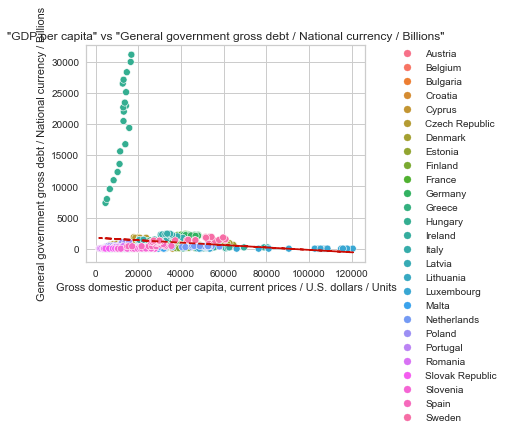

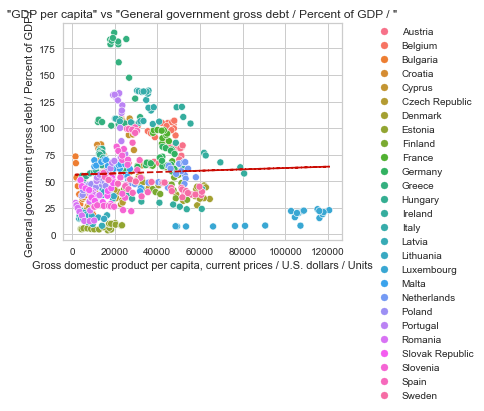

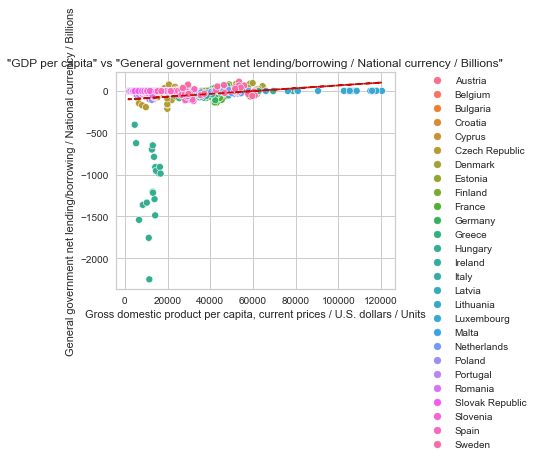

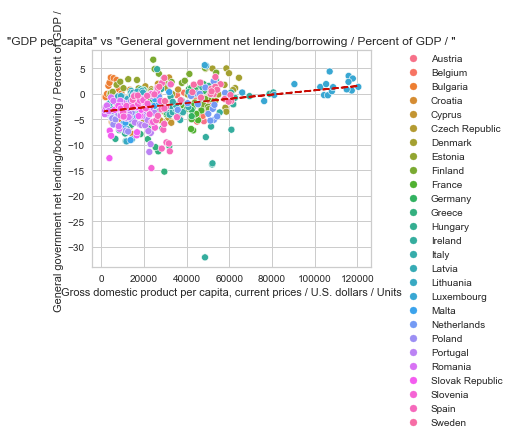

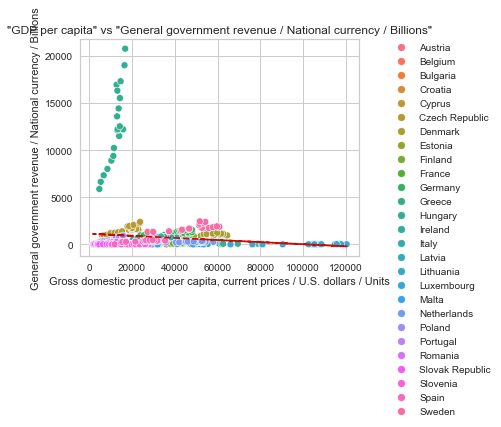

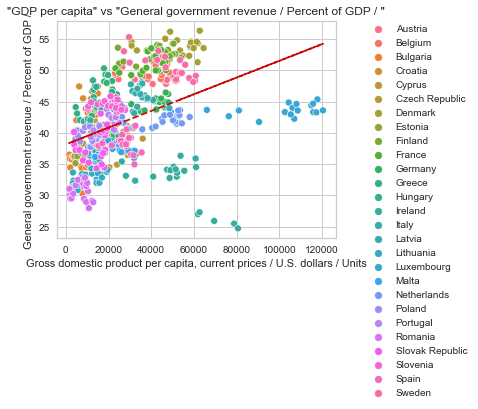

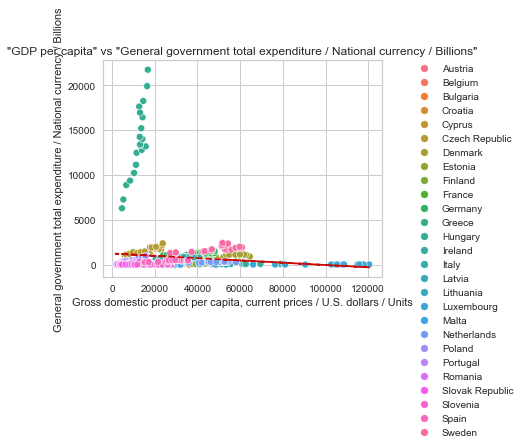

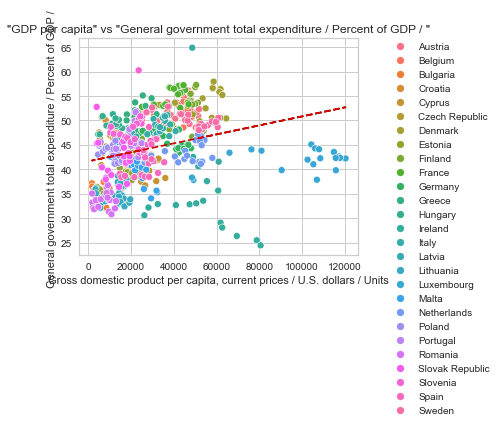

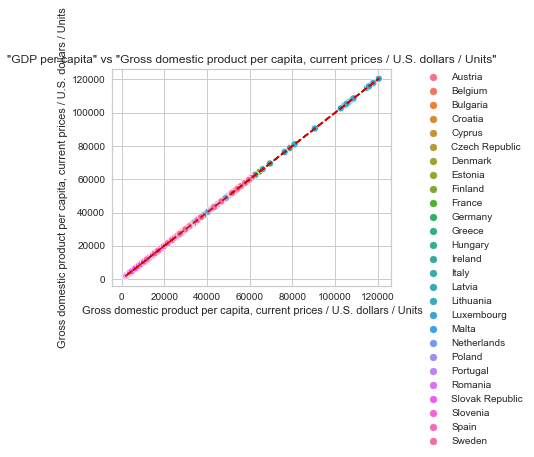

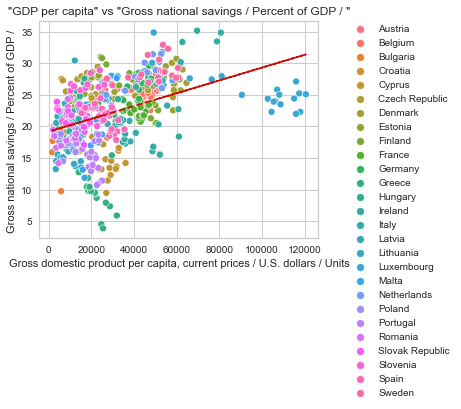

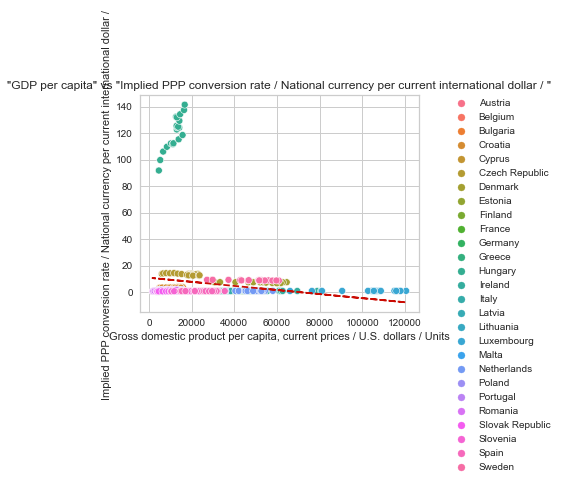

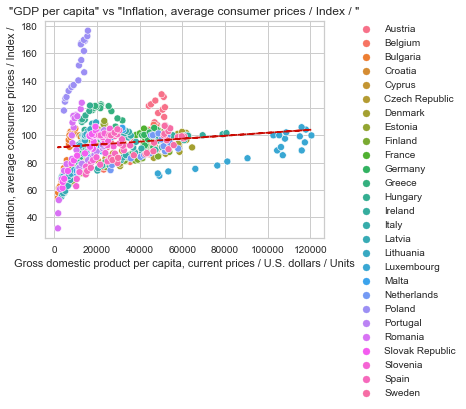

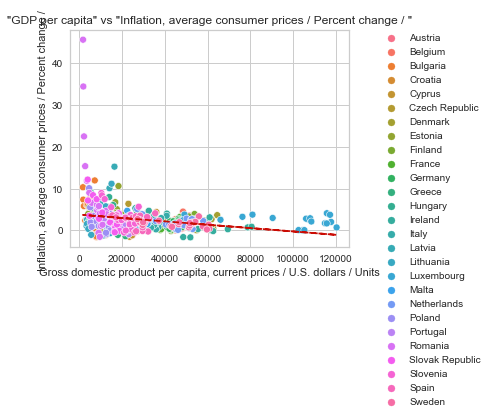

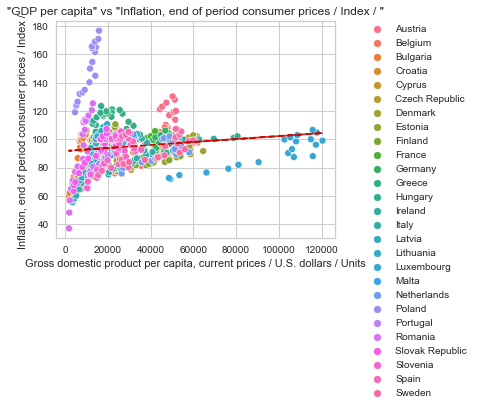

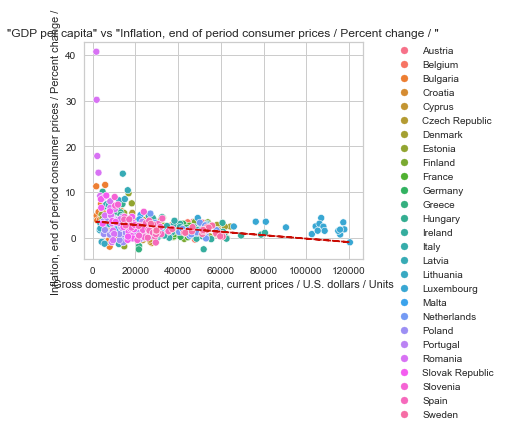

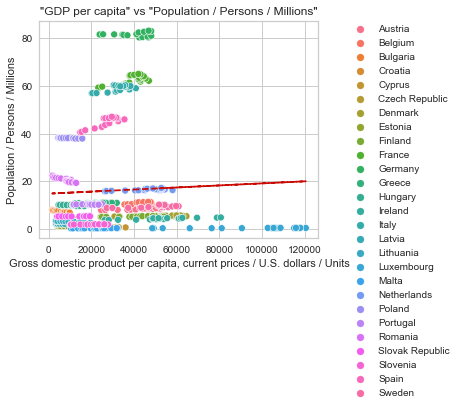

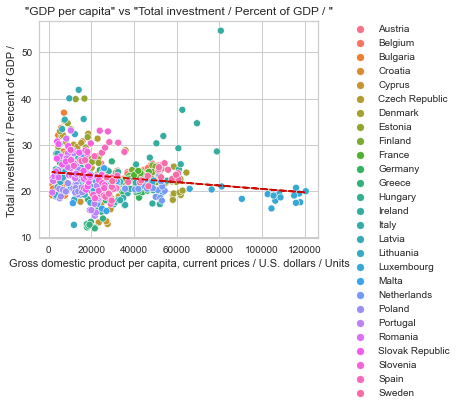

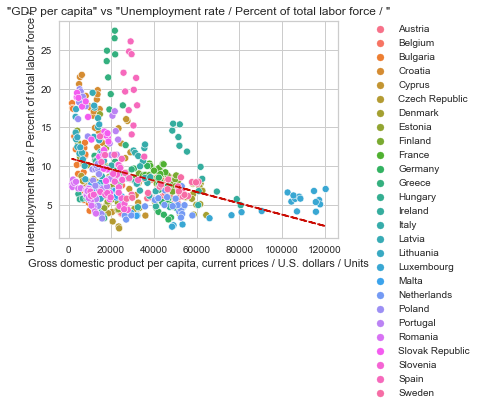

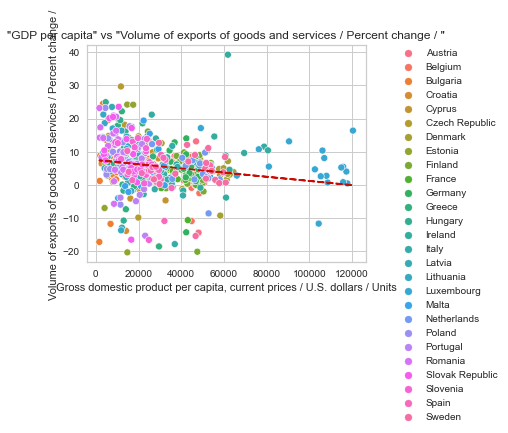

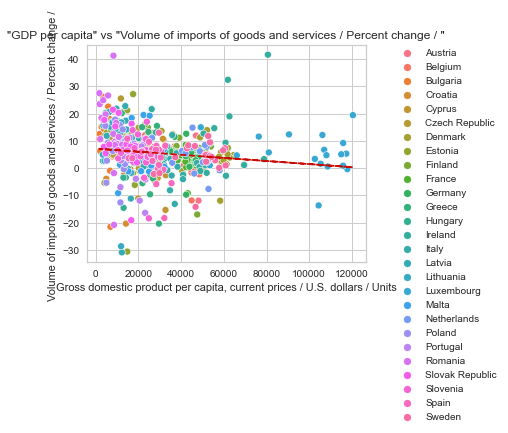

In [47]:
print('\n*** GDP MODEL.   3.2.1. Features Selection : Visual Analysis of GDP Dependency ***')
print('----------------------------------------------------------------------------------\n')

plot_with_trend(df=df3_reg_eu_final, 
                dep_var='Gross domestic product per capita, current prices / U.S. dollars / Units',
                dep_var_short='GDP per capita',
                X_vars=list(df3_reg_eu_final.columns)[2:], 
                hue='Country_EU')

* #### IDENTIFICATION SIGNIFICANT AND INSIGNIFICANT FACTORS - Ordinary Least Squares (OLS)

In [48]:
print('\n*** GDP MODEL.   3.2.1. Features Selection : Identification Significant and Insignificant Factors (OLS) ***')
print('-----------------------------------------------------------------------------------------------------------\n')

print('\n>>> Data:')
print('---------')

df_ols = df3_reg_eu_final.copy()
df_ols['Year_cat'] = df_ols.Year
df_ols = df_ols.set_index(["Country_EU", "Year"])
print(f'Features number: {len(df_ols.columns)-1}')
print(f'Interesting for future: GDP dependency from Year? >> categorical col: {df_ols.columns[-1]}')
display(df_ols.head())


*** GDP MODEL.   3.2.1. Features Selection : Identification Significant and Insignificant Factors (OLS) ***
-----------------------------------------------------------------------------------------------------------


>>> Data:
---------
Features number: 20
Interesting for future: GDP dependency from Year? >> categorical col: Year_cat


General government gross debt / National currency / Billions  \
Country_EU Year                                                                 
Austria    2000                                            140.420              
           2001                                            146.328              
           2002                                            151.862              
           2003                                            150.470              
           2004                                            157.160              

                 General government gross debt / Percent of GDP /   \
Country_EU Year                                                      
Austria    2000                                             65.738   
           2001                                             66.355   
           2002                                             66.978   
           2003                                             64.896   
           2004                                             64.849   

                 General government net lending/borrowing / National currency / Billions  \
Country_EU Year                                                                            
Austria    2000                                             -4.407                         
           2001                                             -1.452                         
           2002                                             -4.228                         
           2003                                             -3.204                         
           2004                                            -11.727                         

                 General government net lending/borrowing / Percent of GDP /   \
Country_EU Year                                                                 
Austria    2000                                             -2.063              
           2001                                             -0.658              
           2002                                             -1.865              
           2003                                             -1.382              
           2004                                             -4.839              

                 General government revenue / National currency / Billions  \
Country_EU Year                                                              
Austria    2000                                            103.793           
           2001                                            111.803           
           2002                                            114.651           
           2003                                            112.556           
           2004                                            118.424           

                 General government revenue / Percent of GDP /   \
Country_EU Year                                                   
Austria    2000                                          48.591   
           2001                                          50.699   
           2002                                          50.566   
           2003                                          48.544   
           2004                                          48.865   

                 General government total expenditure / National currency / Billions  \
Country_EU Year                                                                        
Austria    2000                                            108.201                     
           2001                                            113.255                     
           2002                                            118.878                     
           2003                                            115.759                     
           2004                                            130.152                     

                 General government total expenditure / Percent of GDP /   \
Country_EU Year                   

In [49]:
print('\n*** GDP MODEL.   3.2.1. Features Selection : Identification Significant and Insignificant Factors (OLS) ***')
print('-----------------------------------------------------------------------------------------------------------\n')

print('\n>>> OLS REGRESSION RESULTS WITH ALL FEATURES :')
print('----------------------------------------------')

# df_ols >>> primary full df with all features
# df_ols2 >>> primary full df without y (GDP)

y = df_ols['Gross domestic product per capita, current prices / U.S. dollars / Units']
df_ols2 = df_ols.drop('Gross domestic product per capita, current prices / U.S. dollars / Units', axis=1)
X = df_ols2 

OLS_model(y, X)


*** GDP MODEL.   3.2.1. Features Selection : Identification Significant and Insignificant Factors (OLS) ***
-----------------------------------------------------------------------------------------------------------


>>> OLS REGRESSION RESULTS WITH ALL FEATURES :
----------------------------------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                                                       OLS Regression Results                                                       
====================================================================================================================================
Dep. Variable:     Gross domestic product per capita, current prices / U.S. dollars / Units   R-squared:                       0.461
Model:                                                                                  OLS   Adj. R-squared:                  0.440
Method:                                                                       Least Squares   F-statistic:                     22.17
Date:                                                                      Thu, 12 May 2022   Prob (F-statistic):           4.33e-57
Time:                                                                              00:06:44   Log-Likelihood:                -5978.4
No. Observations:                                                                       540   AIC:                         1.200e+04
Df Residuals:                                                                           519   BIC:                         1.209e+04
Df Model:                                                                                20                                         
Covariance Type:                                                                  nonrobust                                         
=======================================================================================================================================================
                                                                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                               -8.984e+05    3.8e+05     -2.363      0.019   -1.65e+06   -1.51e+05
General government gross debt / National currency / Billions                            0.5334      1.576      0.338      0.735      -2.563       3.629
General government gross debt / Percent of GDP /                                        0.6322     32.536      0.019      0.985     -63.286      64.550
General government net lending/borrowing / National currency / Billions              2.495e+06   1.74e+06      1.431      0.153   -9.31e+05    5.92e+06
General government net lending/borrowing / Percent of GDP /                         -7.201e+05   1.41e+06     -0.512      0.609   -3.48e+06    2.04e+06
General government revenue / National currency / Billions                           -2.495e+06   1.74e+06     -1.431      0.153   -5.92e+06    9.31e+05
General government revenue / Percent of GDP /                                        7.207e+05   1.41e+06      0.512      0.609   -2.04e+06    3.48e+06
General government total expenditure / National currency / Billions                  2.495e+06   1.74e+06      1.431      0.153   -9.31e+05    5.92e+06
General government total expenditure / Percent of GDP /                             -7.199e+05   1.41e+06     -0.512      0.609   -3.48e+06    2.04e+06
Gross national savings / Percent of GDP /                                            1253.1921    203.050      6.172      0.000     854.292    1652.092
Implied PPP conversion rate / National currency per current international dollar /   -337.4973    210.158     -1.606      0.109    -750.362      75.367
Inflation, average consumer prices / Index /                                        -4146.2703   1228.224     -3.376      0.001   -6559.173   -1733.368
Inflation, average consumer prices / Percent change /                                1553.1186    736.398      2.109      0.035     106.432    2999.805
Inflation, end of period consumer prices / Index /       

* #### SELECTION SIGNIFICANT FACTORS - Ordinary Least Squares (OLS)

In [50]:
print('\n*** GDP MODEL.   3.2.1. Features Selection : Selection Significant Factors (OLS) ***')
print('------------------------------------------------------------------------------------\n')

print('\n>>> OLS REGRESSION RESULTS WITH SELECTED FEATURES BY P>|t| & t :')
print('----------------------------------------------------------------')

### primary Adj. R-squared:	0.440
###### selection by P>|t| in descending order (pirma metam didziausius)
# drop #1: General government gross debt / Percent of GDP /	0.6322	32.536	0.019	0.985
# drop #2: General government gross debt / National currency / Billions	0.5432	1.491	0.364	0.716
# drop #3: General government net lending/borrowing / Percent of GDP /	-6.932e+05	1.4e+06	-0.494	0.621
# drop #4: General government total expenditure / Percent of GDP /	198.3561	264.358	0.750	0.453
# drop #5: General government net lending/borrowing / National currency / Billions	2.581e+06	1.73e+06	1.488	0.137	
### interim Adj. R-squared: 0.442
# drop #6: Implied PPP conversion rate / National currency per current international dollar /	-356.3605	206.891	-1.722	0.086
# drop #7: General government revenue / National currency / Billions	-9.0793	6.098	-1.489	0.137
# drop #8: Volume of imports of goods and services / Percent change /	297.8207	157.617	1.890	0.059
# drop #9: Volume of exports of goods and services / Percent change /	-93.5207	104.929	-0.891	0.373
# drop #10: Population / Persons / Millions	-47.4141	35.110	-1.350	0.177
### interim Adj. R-squared:
# drop #11: Inflation, average consumer prices / Percent change /	1192.8078	712.137	1.675	0.095
# drop #12: Inflation, end of period consumer prices / Index /	2809.5984	1010.423	2.781	0.006
# drop #13: Inflation, average consumer prices / Index /	-105.7597	54.198	-1.951	0.052
# drop #14: Inflation, end of period consumer prices / Percent change /	-454.4744	262.565	-1.731	0.084
# drop #15: Year_cat	580.6027	127.427	4.556	0.000
### final Adj. R-squared:	0.399

X_sel_ols = X[[
    #2'General government gross debt / National currency / Billions',
       #1'General government gross debt / Percent of GDP / ',
       #5'General government net lending/borrowing / National currency / Billions',
       #3'General government net lending/borrowing / Percent of GDP / ',
       #7'General government revenue / National currency / Billions',
       'General government revenue / Percent of GDP / ',
       'General government total expenditure / National currency / Billions',
       #4'General government total expenditure / Percent of GDP / ',
       'Gross national savings / Percent of GDP / ',
       #6'Implied PPP conversion rate / National currency per current international dollar / ',
       #13'Inflation, average consumer prices / Index / ',
       #11'Inflation, average consumer prices / Percent change / ',
       #12'Inflation, end of period consumer prices / Index / ',
       #14'Inflation, end of period consumer prices / Percent change / ',
       #10'Population / Persons / Millions',
       'Total investment / Percent of GDP / ',
       'Unemployment rate / Percent of total labor force / ']]
       #9'Volume of exports of goods and services / Percent change / ',
       #8'Volume of imports of goods and services / Percent change / ',
       #15'Year_cat']]
       
OLS_model(y, X_sel_ols)




*** GDP MODEL.   3.2.1. Features Selection : Selection Significant Factors (OLS) ***
------------------------------------------------------------------------------------


>>> OLS REGRESSION RESULTS WITH SELECTED FEATURES BY P>|t| & t :
----------------------------------------------------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                                                       OLS Regression Results                                                       
====================================================================================================================================
Dep. Variable:     Gross domestic product per capita, current prices / U.S. dollars / Units   R-squared:                       0.405
Model:                                                                                  OLS   Adj. R-squared:                  0.399
Method:                                                                       Least Squares   F-statistic:                     72.69
Date:                                                                      Thu, 12 May 2022   Prob (F-statistic):           5.41e-58
Time:                                                                              00:06:44   Log-Likelihood:                -6004.9
No. Observations:                                                                       540   AIC:                         1.202e+04
Df Residuals:                                                                           534   BIC:                         1.205e+04
Df Model:                                                                                 5                                         
Covariance Type:                                                                  nonrobust                                         
=======================================================================================================================================
                                                                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------
const                                                                5545.6730   7644.631      0.725      0.469   -9471.565    2.06e+04
General government revenue / Percent of GDP /                         840.6833    122.486      6.864      0.000     600.071    1081.296
General government total expenditure / National currency / Billions    -1.4926      0.270     -5.534      0.000      -2.022      -0.963
Gross national savings / Percent of GDP /                            1369.2936    171.161      8.000      0.000    1033.062    1705.525
Total investment / Percent of GDP /                                 -1313.8409    178.046     -7.379      0.000   -1663.598    -964.084
Unemployment rate / Percent of total labor force /                  -1177.3016    177.920     -6.617      0.000   -1526.810    -827.794
==============================================================================
Omnibus:                      267.915   Durbin-Watson:                   0.225
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1487.111
Skew:                           2.184   Prob(JB):                         0.00
Kurtosis:                       9.856   Cond. No.                     3.04e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.04e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

* #### VISUAL ANALYSIS OF SIGNIFICANT FACTORS BY OLS


*** GDP MODEL.   3.2.1. Features Selection : Visual Analysis of Significant Factors by OLS ***
----------------------------------------------------------------------------------------------

>>> SIGNIFICANT FACTORS : 5


['General government revenue / Percent of GDP / ',
 'General government total expenditure / National currency / Billions',
 'Gross national savings / Percent of GDP / ',
 'Total investment / Percent of GDP / ',
 'Unemployment rate / Percent of total labor force / ']

------------------------------------------------------------

>>> SIGNIFICANT FACTORS AND GDP DEPENDECY VISUAL ANALYSIS :


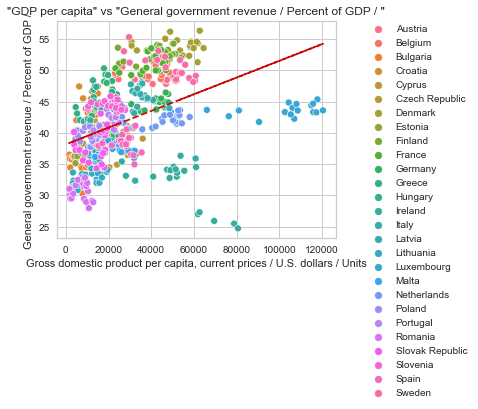

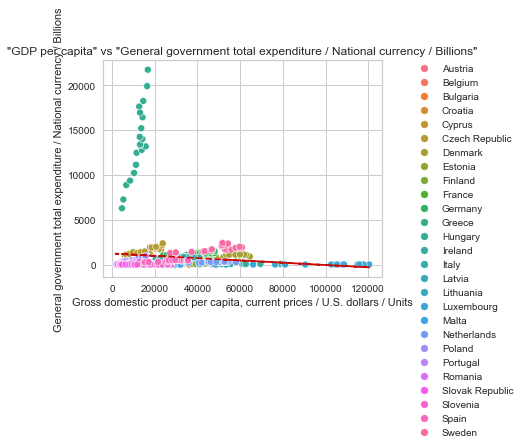

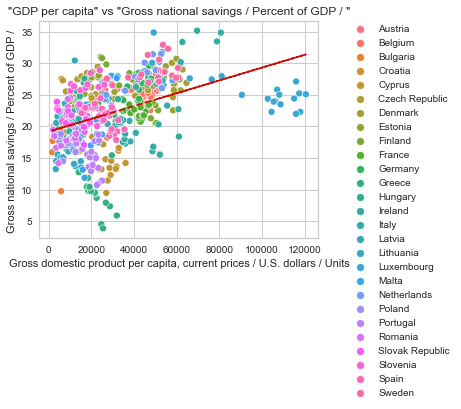

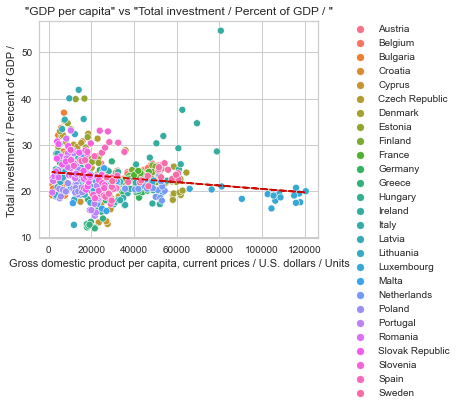

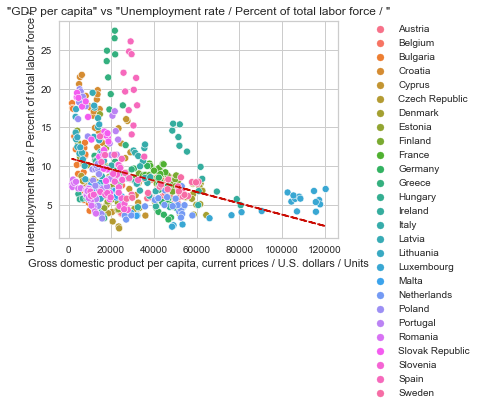

In [51]:
print('\n*** GDP MODEL.   3.2.1. Features Selection : Visual Analysis of Significant Factors by OLS ***')
print('----------------------------------------------------------------------------------------------\n')

ols_feat = list(X_sel_ols.columns)
# ols_feat_Y = ols_feat
# ols_feat_Y.append('Gross domestic product per capita, current prices / U.S. dollars / Units')
print(f'>>> SIGNIFICANT FACTORS : {len(ols_feat)}')
display(ols_feat)
print('------------------------------------------------------------')

print(f'\n>>> SIGNIFICANT FACTORS AND GDP DEPENDECY VISUAL ANALYSIS :')

plot_with_trend(df=df3_reg_eu_final, 
                X_vars=list(ols_feat), 
                dep_var='Gross domestic product per capita, current prices / U.S. dollars / Units',
                dep_var_short='GDP per capita',
                hue='Country_EU')

* #### SPLITTING DATA : TRAIN & TEST

In [52]:
print('\n*** GDP MODEL.   3.2.1. Features Selection : Slitting Data - Test & Train ***')
print('-----------------------------------------------------------------------------')

df_split = df3_reg_eu_final.copy()
df_split['Year_cat'] = df_split.Year
df_split = df_split.set_index(["Country_EU", "Year"])
#display(df_split.head())
#print(df_split.columns)

X = df_split
y = df_split['Gross domestic product per capita, current prices / U.S. dollars / Units']
X_train, X_test = train_test_split(X, test_size=0.20, random_state=0)

y_train = X_train['Gross domestic product per capita, current prices / U.S. dollars / Units']
X_train.drop('Gross domestic product per capita, current prices / U.S. dollars / Units', axis=1, inplace=True)

y_test = X_test['Gross domestic product per capita, current prices / U.S. dollars / Units']
X_test.drop('Gross domestic product per capita, current prices / U.S. dollars / Units', axis=1, inplace=True)

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')


*** GDP MODEL.   3.2.1. Features Selection : Slitting Data - Test & Train ***
-----------------------------------------------------------------------------
X_train shape: (432, 20)
X_test shape: (108, 20)
y_train shape: (432,)
y_test shape: (108,)


* #### CROSS-VALIDATION (CV) : CHECK OF SELECTED FEATURES

In [53]:
print('\n*** GDP MODEL.   3.2.1. Features Selection : Cross_Validation (CV) - check of significant features ***')
print('------------------------------------------------------------------------------------------------------')

model = LinearRegression()
rfe = RFECV(model, cv=6) # cv - cross_validation
rfe = rfe.fit(X_train, y_train)
selected_features_CV = rfe.get_feature_names_out()

print(f'>>> Features num in X_train : {len(list(X_train.columns))}')
print(f'>>> Selected features num by CV : {len(list(selected_features_CV))}')
print('--------------------------------------------------------')
print(f'>>> CONCLUSION >>> Nothing optimal and effective by CV.')
print(f'               >>> Use selected features by OLS.')
print('--------------------------------------------------------')

# print(f'Selected features by CV: \n{selected_features_CV}')


*** GDP MODEL.   3.2.1. Features Selection : Cross_Validation (CV) - check of significant features ***
------------------------------------------------------------------------------------------------------
>>> Features num in X_train : 20
>>> Selected features num by CV : 14
--------------------------------------------------------
>>> CONCLUSION >>> Nothing optimal and effective by CV.
               >>> Use selected features by OLS.
--------------------------------------------------------


* #### PooledOLS (PANEL DATA MODEL) : CHECK GDP DEPENDENCY FROM CALENDAR YEARS 

In [54]:
print('\n*** GDP MODEL.   3.2.1. Features Selection : PooledOLS (PANEL DATA) - Check GDP dep. from calendar years ***')
print('------------------------------------------------------------------------------------------------------------')

PooledOLS_model(dep_var='Gross domestic product per capita, current prices / U.S. dollars / Units')


*** GDP MODEL.   3.2.1. Features Selection : PooledOLS (PANEL DATA) - Check GDP dep. from calendar years ***
------------------------------------------------------------------------------------------------------------


RandomEffects Estimation Summary                                                   
======================================================================================================================================
Dep. Variable:     Gross domestic product per capita, current prices / U.S. dollars / Units   R-squared:                        0.5185
Estimator:                                                                    RandomEffects   R-squared (Between):              0.5993
No. Observations:                                                                       540   R-squared (Within):               0.0574
Date:                                                                      Thu, May 12 2022   R-squared (Overall):              0.5185
Time:                                                                              00:06:51   Log-likelihood                   -5947.8
Cov. Estimator:                                                                  Unadjusted                                           
                                                                                              F-statistic:                      14.198
Entities:                                                                                27   P-value                           0.0000
Avg Obs:                                                                             20.000   Distribution:                  F(38,501)
Min Obs:                                                                             20.000                                           
Max Obs:                                                                             20.000   F-statistic (robust):             14.189
                                                                                              P-value                           0.0000
Time periods:                                                                            20   Distribution:                  F(38,501)
Avg Obs:                                                                             27.000                                           
Min Obs:                                                                             27.000                                           
Max Obs:                                                                             27.000                                           
                                                                                                                                      
                                                                  Parameter Estimates                                                                  
=======================================================================================================================================================
                                                                                     Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                   7155.4  1.069e+04     0.6697     0.5034  -1.384e+04   2.815e+04
General government gross debt / National currency / Billions                           -0.1676     1.5331    -0.1093     0.9130     -3.1797      2.8445
General government gross debt / Percent of GDP /                                        34.492     32.273     1.0688     0.2857     -28.915      97.900
General government net lending/borrowing / National currency / Billions                1.7e+06  1.698e+06     1.0012     0.3172  -1.636e+06   5.035e+06
General government net lending/borrowing / Percent of GDP /                         -7.981e+05  1.393e+06    -0.5730     0.5669  -3.535e+06   1.938e+06
General government revenue / National currency / Billions                             -1.7e+06  1.698e+06    -1.0012  

### 3.2.2. GDP PREDICTION MODEL IMPLEMENTATION

### A. BY ALL FEATURES

* #### LinearRegression


*** GDP MODEL.   3.2.2. GDP Prediction Model : LinearRegression >> by all features ***
--------------------------------------------------------------------------------------
>>> Results :
-------------
MSE: 18171.6536087864
MAPE: 0.5918797358586431


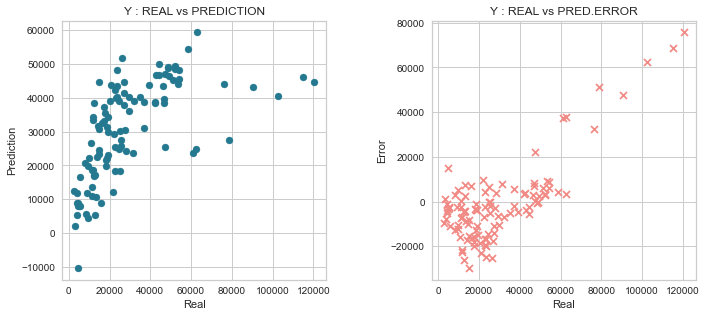

In [55]:
print('\n*** GDP MODEL.   3.2.2. GDP Prediction Model : LinearRegression >> by all features ***')
print('--------------------------------------------------------------------------------------')

LinReg_model(X_train, y_train, X_test, y_test)

* #### XGBoost


*** GDP MODEL.   3.2.2. GDP Prediction Model : XGBoost >> by all features ***
-----------------------------------------------------------------------------
[0]	test-mape:0.94977	train-mape:0.95172
[1]	test-mape:0.90262	train-mape:0.90597
[2]	test-mape:0.85760	train-mape:0.86276
[3]	test-mape:0.81382	train-mape:0.82134
[4]	test-mape:0.77107	train-mape:0.78194
[5]	test-mape:0.73241	train-mape:0.74459
[6]	test-mape:0.69547	train-mape:0.70894
[7]	test-mape:0.65857	train-mape:0.67507
[8]	test-mape:0.62577	train-mape:0.64283
[9]	test-mape:0.59276	train-mape:0.61185
[10]	test-mape:0.56325	train-mape:0.58256
[11]	test-mape:0.53512	train-mape:0.55486
[12]	test-mape:0.50740	train-mape:0.52850
[13]	test-mape:0.48163	train-mape:0.50334
[14]	test-mape:0.45724	train-mape:0.47916
[15]	test-mape:0.43378	train-mape:0.45637
[16]	test-mape:0.41279	train-mape:0.43477
[17]	test-mape:0.39179	train-mape:0.41408
[18]	test-mape:0.37214	train-mape:0.39446
[19]	test-mape:0.35463	train-mape:0.37580
[20]	test-map

[190]	test-mape:0.11727	train-mape:0.00035
[191]	test-mape:0.11727	train-mape:0.00034
[192]	test-mape:0.11728	train-mape:0.00033
[193]	test-mape:0.11728	train-mape:0.00032
[194]	test-mape:0.11728	train-mape:0.00031
[195]	test-mape:0.11728	train-mape:0.00030
[196]	test-mape:0.11729	train-mape:0.00029
[197]	test-mape:0.11729	train-mape:0.00028
[198]	test-mape:0.11729	train-mape:0.00028
[199]	test-mape:0.11729	train-mape:0.00027
[200]	test-mape:0.11729	train-mape:0.00026
[201]	test-mape:0.11729	train-mape:0.00025
[202]	test-mape:0.11729	train-mape:0.00024
[203]	test-mape:0.11729	train-mape:0.00024
[204]	test-mape:0.11729	train-mape:0.00023
[205]	test-mape:0.11729	train-mape:0.00023
[206]	test-mape:0.11729	train-mape:0.00022
[207]	test-mape:0.11729	train-mape:0.00021
[208]	test-mape:0.11730	train-mape:0.00021
[209]	test-mape:0.11730	train-mape:0.00020
[210]	test-mape:0.11729	train-mape:0.00020
[211]	test-mape:0.11729	train-mape:0.00019
[212]	test-mape:0.11729	train-mape:0.00018
[213]	test-

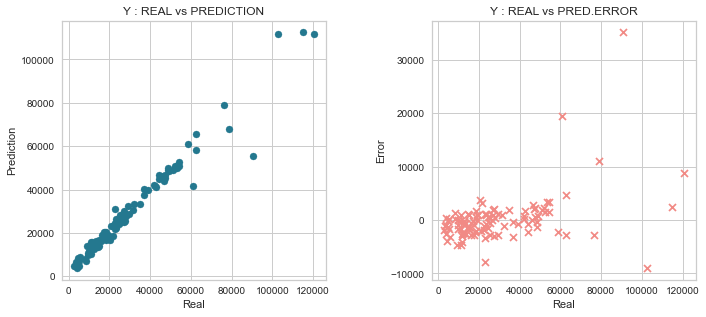

In [56]:
print('\n*** GDP MODEL.   3.2.2. GDP Prediction Model : XGBoost >> by all features ***')
print('-----------------------------------------------------------------------------')

XGB_model(
    X_train = X_train, 
    y_train = y_train, 
    X_test = X_test, 
    y_test = y_test, 
    max_depth = 12, 
    eta = 0.05, iter_num = 500)

* #### XGBoost-GridSearch


*** GDP MODEL.   3.2.2. GDP Prediction Model : XGBoost-GridSearchCV >> by all features ***
------------------------------------------------------------------------------------------
Fitting 5 folds for each of 100 candidates, totalling 500 fits

>>>Selected the best parametres:
--------------------------------
{'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 1000, 'objective': 'reg:squarederror', 'verbosity': 0}

[0]	test-mape:0.94977	train-mape:0.95172
[1]	test-mape:0.90268	train-mape:0.90585
[2]	test-mape:0.85749	train-mape:0.86221
[3]	test-mape:0.81370	train-mape:0.82081
[4]	test-mape:0.77095	train-mape:0.78143
[5]	test-mape:0.73231	train-mape:0.74409
[6]	test-mape:0.69534	train-mape:0.70847
[7]	test-mape:0.65843	train-mape:0.67461
[8]	test-mape:0.62565	train-mape:0.64227
[9]	test-mape:0.59323	train-mape:0.61121
[10]	test-mape:0.56380	train-mape:0.58182
[11]	test-mape:0.53527	train-mape:0.55405
[12]	test-mape:0.50764	train-mape:0.52772
[13]	test-mape:0.48050	train-mape:0.502

[184]	test-mape:0.11952	train-mape:0.00254
[185]	test-mape:0.11951	train-mape:0.00250
[186]	test-mape:0.11950	train-mape:0.00245
[187]	test-mape:0.11949	train-mape:0.00243
[188]	test-mape:0.11948	train-mape:0.00238
[189]	test-mape:0.11945	train-mape:0.00236
[190]	test-mape:0.11944	train-mape:0.00232
[191]	test-mape:0.11942	train-mape:0.00229
[192]	test-mape:0.11941	train-mape:0.00224
[193]	test-mape:0.11939	train-mape:0.00222
[194]	test-mape:0.11937	train-mape:0.00220
[195]	test-mape:0.11938	train-mape:0.00215
[196]	test-mape:0.11939	train-mape:0.00212
[197]	test-mape:0.11939	train-mape:0.00209
[198]	test-mape:0.11937	train-mape:0.00206
[199]	test-mape:0.11936	train-mape:0.00205
[200]	test-mape:0.11934	train-mape:0.00200
[201]	test-mape:0.11933	train-mape:0.00196
[202]	test-mape:0.11933	train-mape:0.00194
[203]	test-mape:0.11932	train-mape:0.00193
[204]	test-mape:0.11932	train-mape:0.00191
[205]	test-mape:0.11934	train-mape:0.00187
[206]	test-mape:0.11932	train-mape:0.00183
[207]	test-

[375]	test-mape:0.11894	train-mape:0.00021
[376]	test-mape:0.11894	train-mape:0.00021
[377]	test-mape:0.11894	train-mape:0.00020
[378]	test-mape:0.11894	train-mape:0.00020
[379]	test-mape:0.11893	train-mape:0.00020
[380]	test-mape:0.11893	train-mape:0.00020
[381]	test-mape:0.11893	train-mape:0.00020
[382]	test-mape:0.11893	train-mape:0.00020
[383]	test-mape:0.11893	train-mape:0.00019
[384]	test-mape:0.11893	train-mape:0.00019
[385]	test-mape:0.11893	train-mape:0.00019
[386]	test-mape:0.11893	train-mape:0.00019
[387]	test-mape:0.11893	train-mape:0.00019
[388]	test-mape:0.11893	train-mape:0.00018
[389]	test-mape:0.11893	train-mape:0.00018
[390]	test-mape:0.11893	train-mape:0.00018
[391]	test-mape:0.11893	train-mape:0.00018
[392]	test-mape:0.11893	train-mape:0.00017
[393]	test-mape:0.11892	train-mape:0.00017
[394]	test-mape:0.11893	train-mape:0.00017
[395]	test-mape:0.11893	train-mape:0.00017
[396]	test-mape:0.11893	train-mape:0.00017
[397]	test-mape:0.11893	train-mape:0.00016
[398]	test-

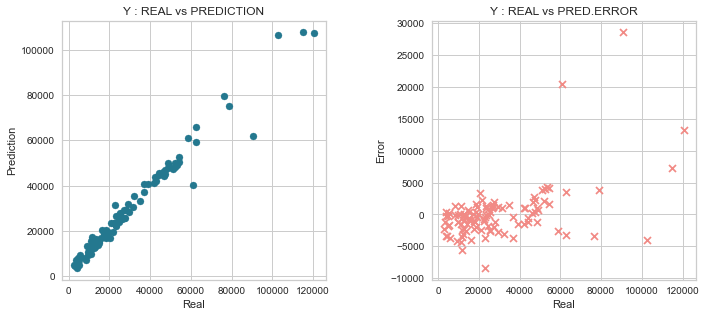

In [57]:
print('\n*** GDP MODEL.   3.2.2. GDP Prediction Model : XGBoost-GridSearchCV >> by all features ***')
print('------------------------------------------------------------------------------------------')

XGB_Grid_model(
    X_train = X_train,
    y_train = y_train,
    X_test = X_test,
    y_test = y_test,
    learning_rate = [0.05, 0.1, 0.2, 0.3],
    max_depth = [6,8,10,12,14],
    n_estimators = [5, 10, 15, 20, 1000],
    n_jobs=5,
    iter_num = 500)

* #### RESULTS (BY ALL FEATURES)


>>> >>> LinearRegression >> by all features;
>>> Results :
-------------
MSE: 18171.6536087864
MAPE: 0.5918797358586431


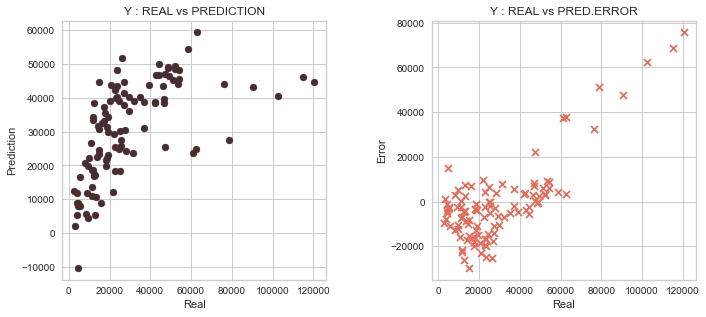


>>> >>> XGBoost >> by all features;
>>> Results :
-------------
MSE: 4672.746662406895
MAPE: 0.11727819275575291


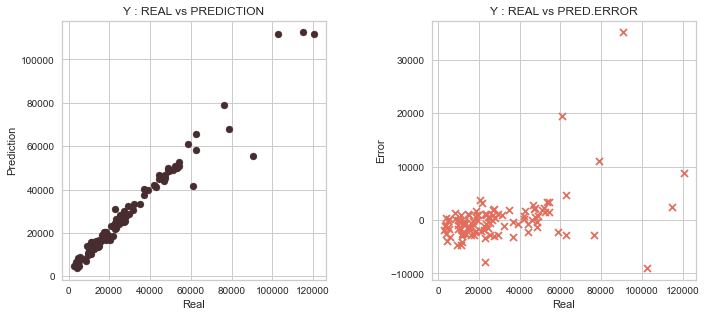


>>> >>> XGBoost-GridSearchCV >> by all features;
>>> Results :
-------------
MSE: 4321.872878853488
MAPE: 0.11890934704587844


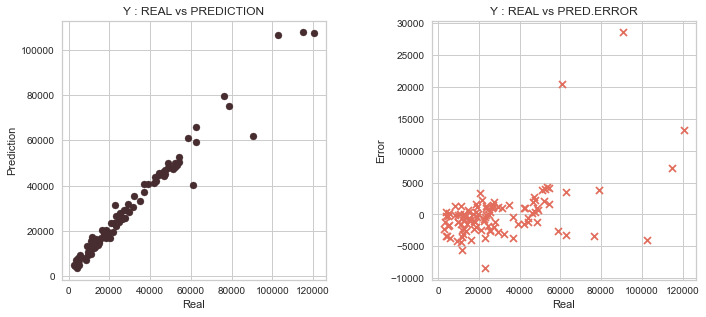

In [58]:
print('\n>>> >>> LinearRegression >> by all features;')
model_results(y_test, LinReg_model.y_pred_lr)
pred_err_plot(y_test, LinReg_model.y_pred_lr, color_pred='#472d30', color_error='#e26d5c')

print('\n>>> >>> XGBoost >> by all features;')
model_results(y_test, XGB_model.y_pred_xgb)
pred_err_plot(y_test, XGB_model.y_pred_xgb, color_pred='#472d30', color_error='#e26d5c')

print('\n>>> >>> XGBoost-GridSearchCV >> by all features;')
model_results(y_test, XGB_Grid_model.y_pred_xgb_grid)
pred_err_plot(y_test, XGB_Grid_model.y_pred_xgb_grid, color_pred='#472d30', color_error='#e26d5c')

### B. BY SELECTED FEATURES

* #### LinearRegression


*** GDP MODEL.   3.2.2. GDP Prediction Model : LinearRegression >> by selected features ***
-------------------------------------------------------------------------------------------
>>> Results :
-------------
MSE: 18467.655662093337
MAPE: 0.6170688998283071


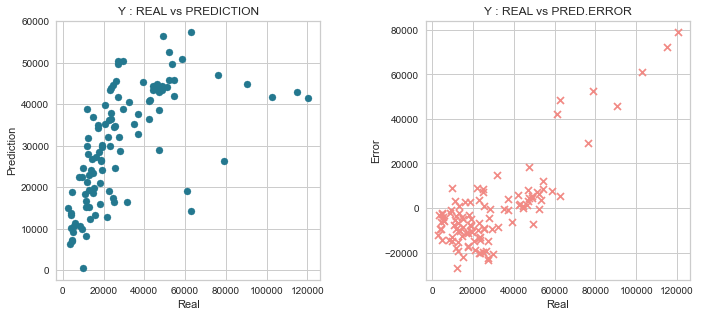

In [59]:
print('\n*** GDP MODEL.   3.2.2. GDP Prediction Model : LinearRegression >> by selected features ***')
print('-------------------------------------------------------------------------------------------')

LinReg_model(X_train[ols_feat], y_train, X_test[ols_feat], y_test)

* #### XGBoost


*** GDP MODEL.   3.2.2. GDP Prediction Model : XGBoost >> by selected features ***
----------------------------------------------------------------------------------
[0]	test-mape:0.94430	train-mape:0.95164
[1]	test-mape:0.89086	train-mape:0.90570
[2]	test-mape:0.84238	train-mape:0.86211
[3]	test-mape:0.79536	train-mape:0.82042
[4]	test-mape:0.75168	train-mape:0.78071
[5]	test-mape:0.71217	train-mape:0.74362
[6]	test-mape:0.67384	train-mape:0.70820
[7]	test-mape:0.63795	train-mape:0.67471
[8]	test-mape:0.60551	train-mape:0.64369
[9]	test-mape:0.57691	train-mape:0.61311
[10]	test-mape:0.54793	train-mape:0.58422
[11]	test-mape:0.52251	train-mape:0.55661
[12]	test-mape:0.50340	train-mape:0.53058
[13]	test-mape:0.48401	train-mape:0.50594
[14]	test-mape:0.46513	train-mape:0.48273
[15]	test-mape:0.44916	train-mape:0.46079
[16]	test-mape:0.43575	train-mape:0.43914
[17]	test-mape:0.42210	train-mape:0.41888
[18]	test-mape:0.41136	train-mape:0.39981
[19]	test-mape:0.40059	train-mape:0.38115
[20

[190]	test-mape:0.33473	train-mape:0.00187
[191]	test-mape:0.33476	train-mape:0.00184
[192]	test-mape:0.33480	train-mape:0.00180
[193]	test-mape:0.33481	train-mape:0.00176
[194]	test-mape:0.33485	train-mape:0.00173
[195]	test-mape:0.33489	train-mape:0.00170
[196]	test-mape:0.33493	train-mape:0.00168
[197]	test-mape:0.33496	train-mape:0.00165
[198]	test-mape:0.33497	train-mape:0.00160
[199]	test-mape:0.33497	train-mape:0.00156
[200]	test-mape:0.33497	train-mape:0.00153
[201]	test-mape:0.33497	train-mape:0.00150
[202]	test-mape:0.33499	train-mape:0.00148
[203]	test-mape:0.33499	train-mape:0.00144
[204]	test-mape:0.33500	train-mape:0.00141
[205]	test-mape:0.33499	train-mape:0.00138
[206]	test-mape:0.33501	train-mape:0.00137
[207]	test-mape:0.33502	train-mape:0.00134
[208]	test-mape:0.33503	train-mape:0.00133
[209]	test-mape:0.33506	train-mape:0.00130
[210]	test-mape:0.33508	train-mape:0.00128
[211]	test-mape:0.33509	train-mape:0.00125
[212]	test-mape:0.33510	train-mape:0.00122
[213]	test-

[381]	test-mape:0.33534	train-mape:0.00008
[382]	test-mape:0.33534	train-mape:0.00008
[383]	test-mape:0.33534	train-mape:0.00008
[384]	test-mape:0.33534	train-mape:0.00008
[385]	test-mape:0.33534	train-mape:0.00008
[386]	test-mape:0.33534	train-mape:0.00007
[387]	test-mape:0.33534	train-mape:0.00007
[388]	test-mape:0.33534	train-mape:0.00007
[389]	test-mape:0.33534	train-mape:0.00007
[390]	test-mape:0.33534	train-mape:0.00007
[391]	test-mape:0.33534	train-mape:0.00007
[392]	test-mape:0.33534	train-mape:0.00007
[393]	test-mape:0.33534	train-mape:0.00007
[394]	test-mape:0.33534	train-mape:0.00006
[395]	test-mape:0.33534	train-mape:0.00006
[396]	test-mape:0.33534	train-mape:0.00006
[397]	test-mape:0.33534	train-mape:0.00006
[398]	test-mape:0.33534	train-mape:0.00006
[399]	test-mape:0.33534	train-mape:0.00006
[400]	test-mape:0.33534	train-mape:0.00006
[401]	test-mape:0.33534	train-mape:0.00006
[402]	test-mape:0.33534	train-mape:0.00006
[403]	test-mape:0.33534	train-mape:0.00006
[404]	test-

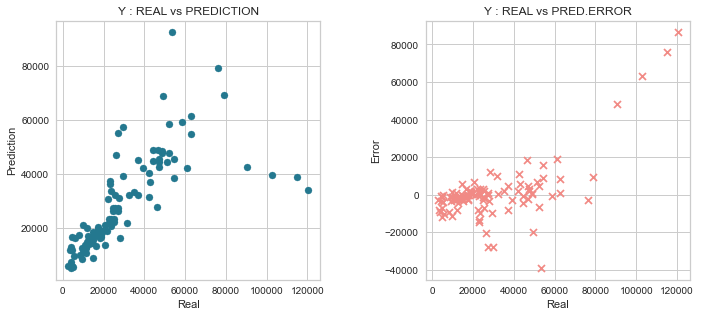

In [60]:
print('\n*** GDP MODEL.   3.2.2. GDP Prediction Model : XGBoost >> by selected features ***')
print('----------------------------------------------------------------------------------')

XGB_model(
    X_train = X_train[ols_feat], 
    y_train = y_train, 
    X_test = X_test[ols_feat], 
    y_test = y_test, 
    max_depth = 12, 
    eta = 0.05, iter_num = 500)

* #### XGBoost-GridSearch


*** GDP MODEL.   3.2.2. GDP Prediction Model : XGBoost-GridSearchCV >> by selected features ***
-----------------------------------------------------------------------------------------------
Fitting 5 folds for each of 100 candidates, totalling 500 fits

>>>Selected the best parametres:
--------------------------------
{'learning_rate': 0.05, 'max_depth': 14, 'n_estimators': 1000, 'objective': 'reg:squarederror', 'verbosity': 0}

[0]	test-mape:0.94430	train-mape:0.95164
[1]	test-mape:0.89086	train-mape:0.90570
[2]	test-mape:0.84238	train-mape:0.86211
[3]	test-mape:0.79536	train-mape:0.82042
[4]	test-mape:0.75168	train-mape:0.78071
[5]	test-mape:0.71217	train-mape:0.74362
[6]	test-mape:0.67384	train-mape:0.70820
[7]	test-mape:0.63795	train-mape:0.67471
[8]	test-mape:0.60551	train-mape:0.64369
[9]	test-mape:0.57691	train-mape:0.61311
[10]	test-mape:0.54800	train-mape:0.58458
[11]	test-mape:0.52275	train-mape:0.55695
[12]	test-mape:0.50363	train-mape:0.53087
[13]	test-mape:0.48422	train

[183]	test-mape:0.33180	train-mape:0.00121
[184]	test-mape:0.33181	train-mape:0.00118
[185]	test-mape:0.33181	train-mape:0.00114
[186]	test-mape:0.33182	train-mape:0.00111
[187]	test-mape:0.33183	train-mape:0.00108
[188]	test-mape:0.33184	train-mape:0.00105
[189]	test-mape:0.33184	train-mape:0.00102
[190]	test-mape:0.33185	train-mape:0.00099
[191]	test-mape:0.33186	train-mape:0.00098
[192]	test-mape:0.33187	train-mape:0.00096
[193]	test-mape:0.33187	train-mape:0.00093
[194]	test-mape:0.33187	train-mape:0.00090
[195]	test-mape:0.33189	train-mape:0.00090
[196]	test-mape:0.33189	train-mape:0.00087
[197]	test-mape:0.33190	train-mape:0.00086
[198]	test-mape:0.33190	train-mape:0.00084
[199]	test-mape:0.33191	train-mape:0.00081
[200]	test-mape:0.33192	train-mape:0.00080
[201]	test-mape:0.33193	train-mape:0.00078
[202]	test-mape:0.33193	train-mape:0.00076
[203]	test-mape:0.33193	train-mape:0.00074
[204]	test-mape:0.33194	train-mape:0.00072
[205]	test-mape:0.33194	train-mape:0.00071
[206]	test-

[374]	test-mape:0.33219	train-mape:0.00005
[375]	test-mape:0.33219	train-mape:0.00005
[376]	test-mape:0.33219	train-mape:0.00005
[377]	test-mape:0.33219	train-mape:0.00005
[378]	test-mape:0.33218	train-mape:0.00004
[379]	test-mape:0.33218	train-mape:0.00004
[380]	test-mape:0.33218	train-mape:0.00004
[381]	test-mape:0.33218	train-mape:0.00004
[382]	test-mape:0.33218	train-mape:0.00004
[383]	test-mape:0.33218	train-mape:0.00004
[384]	test-mape:0.33218	train-mape:0.00004
[385]	test-mape:0.33218	train-mape:0.00004
[386]	test-mape:0.33218	train-mape:0.00004
[387]	test-mape:0.33218	train-mape:0.00004
[388]	test-mape:0.33218	train-mape:0.00004
[389]	test-mape:0.33219	train-mape:0.00004
[390]	test-mape:0.33219	train-mape:0.00004
[391]	test-mape:0.33219	train-mape:0.00004
[392]	test-mape:0.33219	train-mape:0.00004
[393]	test-mape:0.33219	train-mape:0.00003
[394]	test-mape:0.33219	train-mape:0.00003
[395]	test-mape:0.33219	train-mape:0.00003
[396]	test-mape:0.33219	train-mape:0.00003
[397]	test-

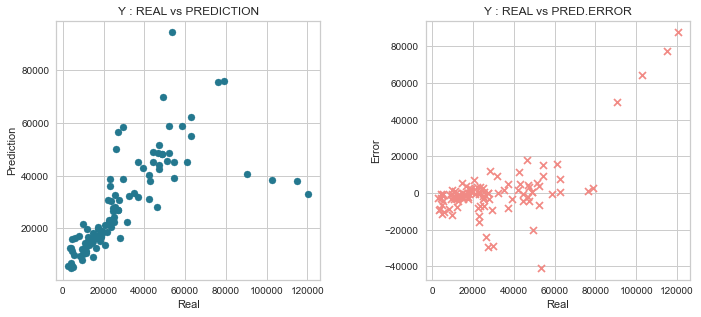

In [61]:
print('\n*** GDP MODEL.   3.2.2. GDP Prediction Model : XGBoost-GridSearchCV >> by selected features ***')
print('-----------------------------------------------------------------------------------------------')

XGB_Grid_model(
    X_train = X_train[ols_feat],
    y_train = y_train,
    X_test = X_test[ols_feat],
    y_test = y_test,
    learning_rate = [0.05, 0.1, 0.2, 0.3],
    max_depth = [6,8,10,12,14],
    n_estimators = [5, 10, 15, 20, 1000],
    n_jobs=5,
    iter_num = 500)

* #### B. RESULTS (BY SELECTED FEATURES)


>>> >>> LinearRegression >> by selected features;
>>> Results :
-------------
MSE: 18467.655662093337
MAPE: 0.6170688998283071


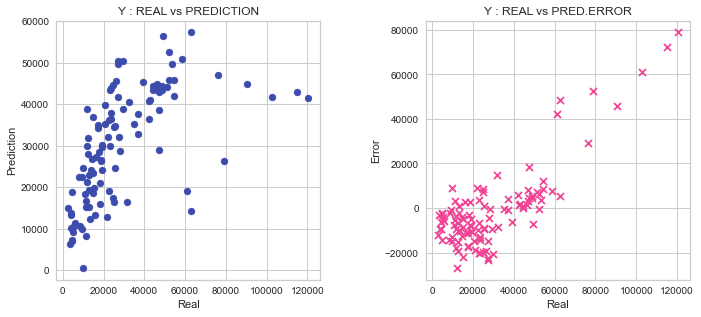


>>> >>> XGBoost >> by selected features;
>>> Results :
-------------
MSE: 15833.39575924843
MAPE: 0.3353433035546999


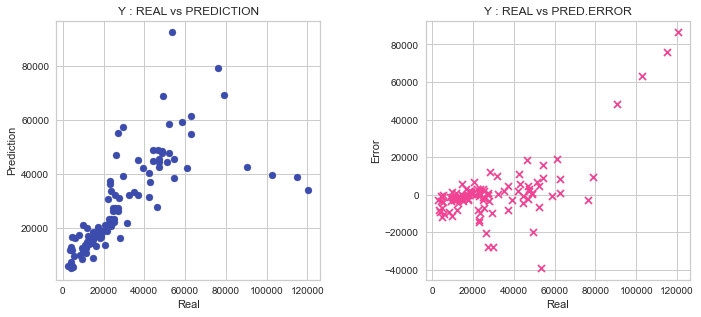


>>> >>> XGBoost-GridSearchCV >> by selected features;
>>> Results :
-------------
MSE: 16086.218801528968
MAPE: 0.3321843521990776


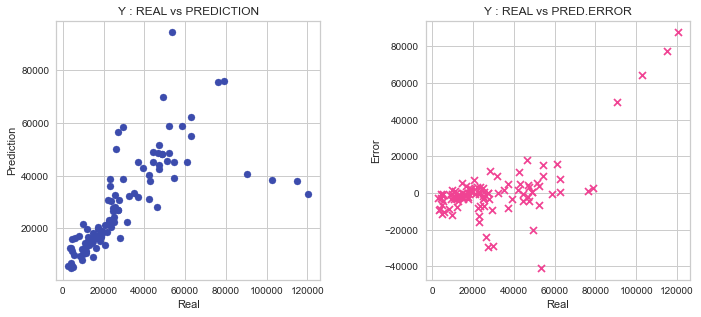

In [62]:
print('\n>>> >>> LinearRegression >> by selected features;')
model_results(y_test, LinReg_model.y_pred_lr)
pred_err_plot(y_test, LinReg_model.y_pred_lr, color_pred='#3c4cad', color_error='#f04393')

print('\n>>> >>> XGBoost >> by selected features;')
model_results(y_test, XGB_model.y_pred_xgb)
pred_err_plot(y_test, XGB_model.y_pred_xgb, color_pred='#3c4cad', color_error='#f04393')

print('\n>>> >>> XGBoost-GridSearchCV >> by selected features;')
model_results(y_test, XGB_Grid_model.y_pred_xgb_grid)
pred_err_plot(y_test, XGB_Grid_model.y_pred_xgb_grid, color_pred='#3c4cad', color_error='#f04393')

### 3.2.3. OUTLIERS ANALYSIS

In [63]:
print('\n*** GDP MODEL.   3.2.3. GDP Prediction Model : Analysis Of GDP Outliers ***')
print('---------------------------------------------------------------------------')

# df_split = df3_reg_eu_final.copy()

df_split_out = df_split[ols_feat][df_split['Gross domestic product per capita, current prices / U.S. dollars / Units']>60000]
outliers = round((df_split_out.shape[0]/df_split.shape[0]*100), 2)
outliers = str(outliers) + '%'

print(f'\n>>> Total GDP of EU countries len : {df_split.shape[0]}')
print(f'>>> "Outliers" len ( GDP of EU countries > 60000 ) : {df_split_out.shape[0]}')
print(f'>>> "Outliers" % of total : {outliers}')
print('---------------------------------------------------------------------------')


# get multiindex level labels & collect unique values
out_list = list(df_split_out.index.get_level_values(0))
# count by unique values
out_country = Counter(out_list).keys() # equals to list(set(words))
out_count = Counter(out_list).values() # counts the elements' frequency
# list of outliers countries and values
out_list = {'Country':  out_country,
        'out_count': out_count}
out_list = pd.DataFrame(out_list)
out_list.index = np.arange(1, len(out_list) + 1)
print(f'\n>>> List of outliers countries and values count : ')
display(out_list)
print('---------------------------------------------------------------------------')

print(f'\n>>> >>> Conclusion: Try Regression Models without Luxembourg.')
print('---------------------------------------------------------------------------')



*** GDP MODEL.   3.2.3. GDP Prediction Model : Analysis Of GDP Outliers ***
---------------------------------------------------------------------------

>>> Total GDP of EU countries len : 540
>>> "Outliers" len ( GDP of EU countries > 60000 ) : 31
>>> "Outliers" % of total : 5.74%
---------------------------------------------------------------------------

>>> List of outliers countries and values count : 


Country  out_count
1     Denmark          5
2     Ireland          7
3  Luxembourg         17
4      Sweden          2

---------------------------------------------------------------------------

>>> >>> Conclusion: Try Regression Models without Luxembourg.
---------------------------------------------------------------------------



*** GDP MODEL.   3.2.3. GDP Prediction Model : Histograms of GDP Before and After Removing Outliers ***
-------------------------------------------------------------------------------------------------------


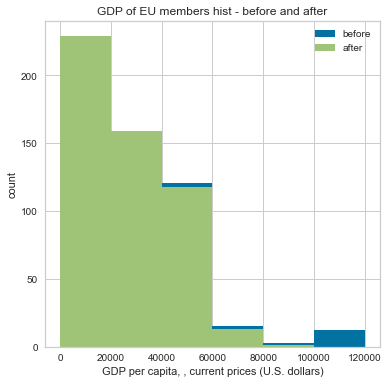

In [64]:
print('\n*** GDP MODEL.   3.2.3. GDP Prediction Model : Histograms of GDP Before and After Removing Outliers ***')
print('-------------------------------------------------------------------------------------------------------')

# DataFrame with selected variables (X) and GDP (y)
final_vars = ols_feat.copy()
y_var = 'Gross domestic product per capita, current prices / U.S. dollars / Units'
final_vars.append(y_var)
df_outl_full = df_split[final_vars]

# Luxembourg data before
# display(df_outl_full.iloc[df_outl_full.index.get_level_values('Country_EU') == 'Luxembourg'])

drop_out = df_outl_full.iloc[df_outl_full.index.get_level_values('Country_EU') == 'Luxembourg']
## drop-off "drop_out" with concat and drop_dublicates
df_outl_full = pd.concat([df_outl_full, drop_out, drop_out]).drop_duplicates(keep=False)

# Luxembourg data after
# display(df_outl_full.iloc[df_outl_full.index.get_level_values('Country_EU') == 'Luxembourg'])


fig = plt.figure(figsize=(6,6)); # siekiant nupiesti i viena grafika, reikia sukurti objekta fig
y = 'Gross domestic product per capita, current prices / U.S. dollars / Units'
h1 = plt.hist(df_split[y], bins=range(0, 140000, 20000), label = "before")
h2 = plt.hist(df_outl_full[y], bins=range(0, 140000, 20000), label = 'after')
plt.title('GDP of EU members hist - before and after')
plt.xlabel('GDP per capita, , current prices (U.S. dollars)')
plt.ylabel('count')
plt.legend();

In [65]:
print('\n*** GDP MODEL.   3.2.3. GDP Prediction Model : Splitting Data Without Selected Outliers to TRAIN & TEST ***')
print('------------------------------------------------------------------------------------------------------------')

X = df_outl_full
y = df_outl_full['Gross domestic product per capita, current prices / U.S. dollars / Units']
X_train_outl, X_test_outl = train_test_split(X, test_size=0.20, random_state=0)

y_train_outl = X_train_outl['Gross domestic product per capita, current prices / U.S. dollars / Units']
X_train_outl.drop('Gross domestic product per capita, current prices / U.S. dollars / Units', axis=1, inplace=True)

y_test_outl = X_test_outl['Gross domestic product per capita, current prices / U.S. dollars / Units']
X_test_outl.drop('Gross domestic product per capita, current prices / U.S. dollars / Units', axis=1, inplace=True)

print(f'X_train_outl shape: {X_train_outl.shape}')
print(f'X_test_outl shape: {X_test_outl.shape}')
print(f'y_train_outl shape: {y_train_outl.shape}')
print(f'y_test_outl shape: {y_test_outl.shape}')



*** GDP MODEL.   3.2.3. GDP Prediction Model : Splitting Data Without Selected Outliers to TRAIN & TEST ***
------------------------------------------------------------------------------------------------------------
X_train_outl shape: (416, 5)
X_test_outl shape: (104, 5)
y_train_outl shape: (416,)
y_test_outl shape: (104,)


* #### C. RESULTS BY SELECTED FEATURES WITHOUT OUTLIERS

* #### LinearRegression


*** GDP MODEL.   3.2.2. GDP Prediction Model : LinearRegression >> by selected features ***
-------------------------------------------------------------------------------------------
>>> Results :
-------------
MSE: 10813.304754486488
MAPE: 0.6953561196854265


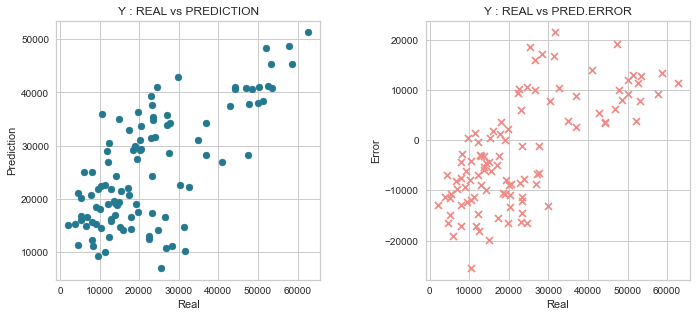

In [66]:
print('\n*** GDP MODEL.   3.2.2. GDP Prediction Model : LinearRegression >> by selected features ***')
print('-------------------------------------------------------------------------------------------')

LinReg_model(X_train_outl, y_train_outl, X_test_outl, y_test_outl)

* #### XGBoost


*** GDP MODEL.   3.2.2. GDP Prediction Model : XGBoost >> by selected features ***
----------------------------------------------------------------------------------
[0]	test-mape:0.94182	train-mape:0.95061
[1]	test-mape:0.88384	train-mape:0.90278
[2]	test-mape:0.83108	train-mape:0.85909
[3]	test-mape:0.78400	train-mape:0.81668
[4]	test-mape:0.73710	train-mape:0.77786
[5]	test-mape:0.69437	train-mape:0.74073
[6]	test-mape:0.65507	train-mape:0.70569
[7]	test-mape:0.61884	train-mape:0.67214
[8]	test-mape:0.58548	train-mape:0.64075
[9]	test-mape:0.55481	train-mape:0.61054
[10]	test-mape:0.52742	train-mape:0.58189
[11]	test-mape:0.50476	train-mape:0.55519
[12]	test-mape:0.48464	train-mape:0.52828
[13]	test-mape:0.46867	train-mape:0.50314
[14]	test-mape:0.45551	train-mape:0.47953
[15]	test-mape:0.44099	train-mape:0.45745
[16]	test-mape:0.42849	train-mape:0.43611
[17]	test-mape:0.41955	train-mape:0.41578
[18]	test-mape:0.40632	train-mape:0.39655
[19]	test-mape:0.39534	train-mape:0.37823
[20

[190]	test-mape:0.29189	train-mape:0.00322
[191]	test-mape:0.29186	train-mape:0.00313
[192]	test-mape:0.29184	train-mape:0.00305
[193]	test-mape:0.29185	train-mape:0.00301
[194]	test-mape:0.29184	train-mape:0.00292
[195]	test-mape:0.29182	train-mape:0.00284
[196]	test-mape:0.29184	train-mape:0.00279
[197]	test-mape:0.29182	train-mape:0.00275
[198]	test-mape:0.29183	train-mape:0.00272
[199]	test-mape:0.29182	train-mape:0.00267
[200]	test-mape:0.29185	train-mape:0.00263
[201]	test-mape:0.29185	train-mape:0.00260
[202]	test-mape:0.29186	train-mape:0.00257
[203]	test-mape:0.29188	train-mape:0.00254
[204]	test-mape:0.29188	train-mape:0.00250
[205]	test-mape:0.29189	train-mape:0.00247
[206]	test-mape:0.29188	train-mape:0.00244
[207]	test-mape:0.29189	train-mape:0.00241
[208]	test-mape:0.29187	train-mape:0.00237
[209]	test-mape:0.29186	train-mape:0.00231
[210]	test-mape:0.29185	train-mape:0.00229
[211]	test-mape:0.29186	train-mape:0.00226
[212]	test-mape:0.29186	train-mape:0.00224
[213]	test-

[381]	test-mape:0.29163	train-mape:0.00010
[382]	test-mape:0.29163	train-mape:0.00010
[383]	test-mape:0.29162	train-mape:0.00010
[384]	test-mape:0.29162	train-mape:0.00010
[385]	test-mape:0.29163	train-mape:0.00009
[386]	test-mape:0.29163	train-mape:0.00009
[387]	test-mape:0.29163	train-mape:0.00009
[388]	test-mape:0.29163	train-mape:0.00009
[389]	test-mape:0.29163	train-mape:0.00009
[390]	test-mape:0.29163	train-mape:0.00008
[391]	test-mape:0.29163	train-mape:0.00008
[392]	test-mape:0.29163	train-mape:0.00008
[393]	test-mape:0.29163	train-mape:0.00008
[394]	test-mape:0.29163	train-mape:0.00008
[395]	test-mape:0.29163	train-mape:0.00008
[396]	test-mape:0.29163	train-mape:0.00008
[397]	test-mape:0.29163	train-mape:0.00008
[398]	test-mape:0.29163	train-mape:0.00007
[399]	test-mape:0.29163	train-mape:0.00007
[400]	test-mape:0.29163	train-mape:0.00007
[401]	test-mape:0.29163	train-mape:0.00007
[402]	test-mape:0.29163	train-mape:0.00007
[403]	test-mape:0.29163	train-mape:0.00007
[404]	test-

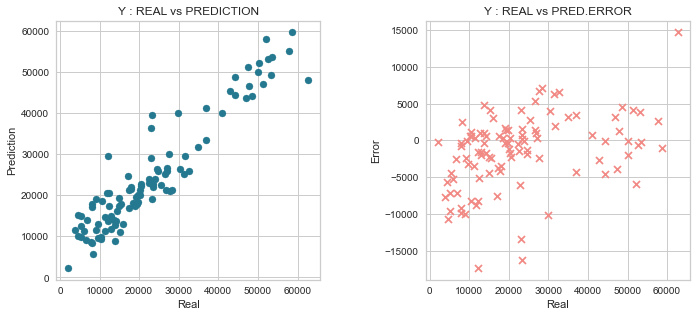

In [67]:
print('\n*** GDP MODEL.   3.2.2. GDP Prediction Model : XGBoost >> by selected features ***')
print('----------------------------------------------------------------------------------')

XGB_model(
    X_train = X_train_outl, 
    y_train = y_train_outl, 
    X_test = X_test_outl, 
    y_test = y_test_outl, 
    max_depth = 12, 
    eta = 0.05, iter_num = 500)

* #### XGBoost-GridSearch


*** GDP MODEL.   3.2.2. GDP Prediction Model : XGBoost-GridSearchCV >> Without Outliers ***
-----------------------------------------------------------------------------------------------
Fitting 5 folds for each of 100 candidates, totalling 500 fits

>>>Selected the best parametres:
--------------------------------
{'learning_rate': 0.05, 'max_depth': 12, 'n_estimators': 1000, 'objective': 'reg:squarederror', 'verbosity': 0}

[0]	test-mape:0.94182	train-mape:0.95061
[1]	test-mape:0.88384	train-mape:0.90278
[2]	test-mape:0.83108	train-mape:0.85909
[3]	test-mape:0.78400	train-mape:0.81668
[4]	test-mape:0.73710	train-mape:0.77786
[5]	test-mape:0.69437	train-mape:0.74073
[6]	test-mape:0.65507	train-mape:0.70569
[7]	test-mape:0.61884	train-mape:0.67214
[8]	test-mape:0.58548	train-mape:0.64075
[9]	test-mape:0.55481	train-mape:0.61054
[10]	test-mape:0.52742	train-mape:0.58189
[11]	test-mape:0.50476	train-mape:0.55519
[12]	test-mape:0.48464	train-mape:0.52828
[13]	test-mape:0.46867	train-map

[184]	test-mape:0.29196	train-mape:0.00345
[185]	test-mape:0.29194	train-mape:0.00343
[186]	test-mape:0.29193	train-mape:0.00340
[187]	test-mape:0.29193	train-mape:0.00334
[188]	test-mape:0.29190	train-mape:0.00330
[189]	test-mape:0.29188	train-mape:0.00327
[190]	test-mape:0.29189	train-mape:0.00322
[191]	test-mape:0.29186	train-mape:0.00313
[192]	test-mape:0.29184	train-mape:0.00305
[193]	test-mape:0.29185	train-mape:0.00301
[194]	test-mape:0.29184	train-mape:0.00292
[195]	test-mape:0.29182	train-mape:0.00284
[196]	test-mape:0.29184	train-mape:0.00279
[197]	test-mape:0.29182	train-mape:0.00275
[198]	test-mape:0.29183	train-mape:0.00272
[199]	test-mape:0.29182	train-mape:0.00267
[200]	test-mape:0.29185	train-mape:0.00263
[201]	test-mape:0.29185	train-mape:0.00260
[202]	test-mape:0.29186	train-mape:0.00257
[203]	test-mape:0.29188	train-mape:0.00254
[204]	test-mape:0.29188	train-mape:0.00250
[205]	test-mape:0.29189	train-mape:0.00247
[206]	test-mape:0.29188	train-mape:0.00244
[207]	test-

[375]	test-mape:0.29163	train-mape:0.00012
[376]	test-mape:0.29162	train-mape:0.00012
[377]	test-mape:0.29162	train-mape:0.00011
[378]	test-mape:0.29163	train-mape:0.00011
[379]	test-mape:0.29163	train-mape:0.00011
[380]	test-mape:0.29163	train-mape:0.00010
[381]	test-mape:0.29163	train-mape:0.00010
[382]	test-mape:0.29163	train-mape:0.00010
[383]	test-mape:0.29162	train-mape:0.00010
[384]	test-mape:0.29162	train-mape:0.00010
[385]	test-mape:0.29163	train-mape:0.00009
[386]	test-mape:0.29163	train-mape:0.00009
[387]	test-mape:0.29163	train-mape:0.00009
[388]	test-mape:0.29163	train-mape:0.00009
[389]	test-mape:0.29163	train-mape:0.00009
[390]	test-mape:0.29163	train-mape:0.00008
[391]	test-mape:0.29163	train-mape:0.00008
[392]	test-mape:0.29163	train-mape:0.00008
[393]	test-mape:0.29163	train-mape:0.00008
[394]	test-mape:0.29163	train-mape:0.00008
[395]	test-mape:0.29163	train-mape:0.00008
[396]	test-mape:0.29163	train-mape:0.00008
[397]	test-mape:0.29163	train-mape:0.00008
[398]	test-

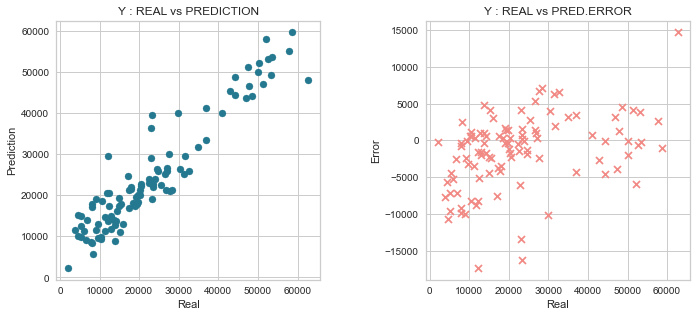

In [68]:
print('\n*** GDP MODEL.   3.2.2. GDP Prediction Model : XGBoost-GridSearchCV >> Without Outliers ***')
print('-----------------------------------------------------------------------------------------------')

XGB_Grid_model(
    X_train = X_train_outl,
    y_train = y_train_outl,
    X_test = X_test_outl,
    y_test = y_test_outl,
    learning_rate = [0.05, 0.1, 0.2, 0.3],
    max_depth = [6,8,10,12,14],
    n_estimators = [5, 10, 15, 20, 1000],
    n_jobs=5,
    iter_num = 500)

* #### C. RESULTS (BY SELECTED FEATURES WITHOUT OUTLIERS)


>>> >>> LinearRegression >> by selected features;
>>> Results :
-------------
MSE: 10813.304754486488
MAPE: 0.6953561196854265


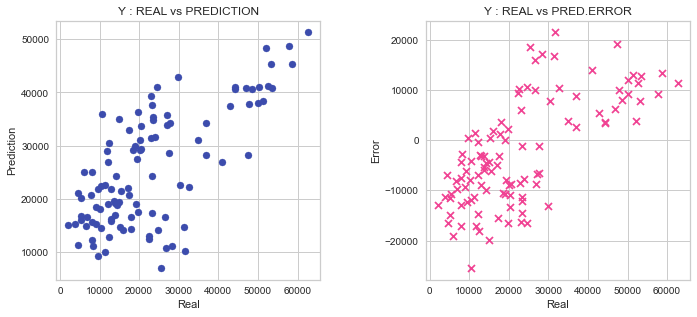


>>> >>> XGBoost >> by selected features;
>>> Results :
-------------
MSE: 5189.123440225953
MAPE: 0.29164227508808377


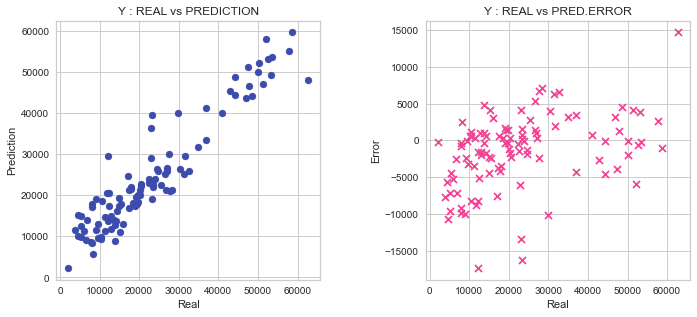


>>> >>> XGBoost-GridSearchCV >> by selected features;
>>> Results :
-------------
MSE: 5189.123440225953
MAPE: 0.29164227508808377


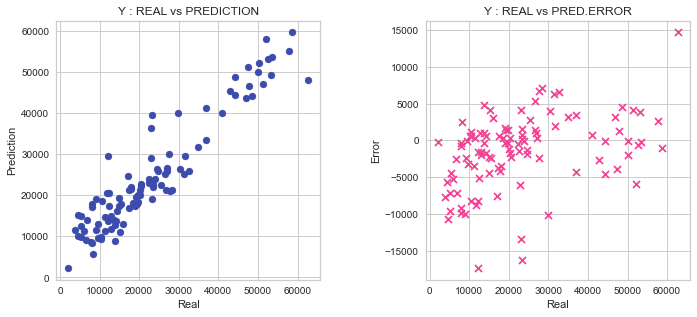

In [70]:
print('\n>>> >>> LinearRegression >> by selected features;')
model_results(y_test_outl, LinReg_model.y_pred_lr)
pred_err_plot(y_test_outl, LinReg_model.y_pred_lr, color_pred='#3c4cad', color_error='#f04393')

print('\n>>> >>> XGBoost >> by selected features;')
model_results(y_test_outl, XGB_model.y_pred_xgb)
pred_err_plot(y_test_outl, XGB_model.y_pred_xgb, color_pred='#3c4cad', color_error='#f04393')

print('\n>>> >>> XGBoost-GridSearchCV >> by selected features;')
model_results(y_test_outl, XGB_Grid_model.y_pred_xgb_grid)
pred_err_plot(y_test_outl, XGB_Grid_model.y_pred_xgb_grid, color_pred='#3c4cad', color_error='#f04393')

## 4. GDP PREDICTION MODEL EXECUTION

* #### SAVING DATA WITHOUT OUTLIERS FOR DATA REUSE IN FLASK APP

In [71]:
df_outl_full.to_csv('df_EU_final.csv')

* #### SELECTED VARIABLES DATA WITHOUT OUTLIERS OF EU MEMBERS
> Final DataFrame Used For GDP Prediction Model

In [80]:
# selecting by MultiIndex

df_outl_full[df_outl_full.index.get_level_values('Year') == 2019]

General government revenue / Percent of GDP /   \
Country_EU      Year                                                   
Austria         2019                                          49.169   
Belgium         2019                                          50.179   
Bulgaria        2019                                          35.077   
Croatia         2019                                          47.462   
Cyprus          2019                                          41.173   
Czech Republic  2019                                          41.368   
Denmark         2019                                          53.581   
Estonia         2019                                          39.985   
Finland         2019                                          52.279   
France          2019                                          52.287   
Germany         2019                                          46.462   
Greece          2019                                          48.004   
Hungary         2019                                          43.635   
Ireland         2019                                          24.720   
Italy           2019                                          47.076   
Latvia          2019                                          37.521   
Lithuania       2019                                          34.108   
Malta           2019                                          35.980   
Netherlands     2019                                          43.583   
Poland          2019                                          41.083   
Portugal        2019                                          42.524   
Romania         2019                                          28.912   
Slovak Republic 2019                                          41.339   
Slovenia        2019                                          43.723   
Spain           2019                                          39.201   
Sweden          2019                                          48.545   

                      General government total expenditure / National currency / Billions  \
Country_EU      Year                                                                        
Austria         2019                                            193.059                     
Belgium         2019                                            248.101                     
Bulgaria        2019                                             43.165                     
Croatia         2019                                            189.743                     
Cyprus          2019                                              8.850                     
Czech Republic  2019                                           2377.481                     
Denmark         2019                                           1147.822                     
Estonia         2019                                             10.945                     
Finland         2019                                            127.913                     
France          2019                                           1349.275                     
Germany         2019                                           1562.698                     
Greece          2019                                             87.630                     
Hungary         2019                                          21724.761                     
Ireland         2019                                             87.060                     
Italy           2019                                            871.003                     
Latvia          2019                                             11.531                     
Lithuania       2019                                             16.518                     
Malta           2019                                              5.004                     
Netherlands     2019                                            334.234                     
Poland          2019                                

* #### GDP PREDICTION BY INPUT VALUES

In [73]:
GDP_prediction()

>>> Please enter 5 values of subjects for GDP prediction.

1. "General government revenue / Percent of GDP / " : 34.108
2. "General government total expenditure / National currency / Billions" : 16.518
3. "Gross national savings / Percent of GDP / " : 20.809
4. "Total investment / Percent of GDP / " : 17.465
5. "Unemployment rate / Percent of total labor force / " : 6.254
Predicted GDP value:  [19557.361]
